# Import the cleaned dataset

In [40]:
import pandas as pd
import numpy as np

df = pd.read_csv("01_framingham_clean.csv")
df.head()

male  age  currentSmoker  cigsPerDay  BPMeds  prevalentStroke  \
0     1   39              0         0.0     0.0                0   
1     0   46              0         0.0     0.0                0   
2     1   48              1        20.0     0.0                0   
3     0   61              1        30.0     0.0                0   
4     0   46              1        23.0     0.0                0   

   prevalentHyp  diabetes  totChol  sysBP  diaBP   BMI  heartRate  glucose  \
0             0         0    195.0  106.0   70.0  27.0       80.0     77.0   
1             0         0    250.0  121.0   81.0  29.0       95.0     76.0   
2             0         0    245.0  127.5   80.0  25.0       75.0     70.0   
3             1         0    225.0  150.0   95.0  29.0       65.0    103.0   
4             0         0    285.0  130.0   84.0  23.0       85.0     85.0   

   education_1.0  education_2.0  education_3.0  education_4.0  TenYearCHD  
0              0              0              0              1           0  
1              0              1              0              0           0  
2              1              0              0              0           0  
3              0              0              1              0           1  
4              0              0              1              0           0

In [41]:
df["TenYearCHD"].value_counts()

TenYearCHD
0    3596
1     644
Name: count, dtype: int64

# Train/Test Split & Standarization

In [42]:
# train test val split
from sklearn.model_selection import train_test_split

X = df.drop(columns=["TenYearCHD"])
y = df["TenYearCHD"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

from sklearn.preprocessing import StandardScaler

# Initialize the scaler
scaler = StandardScaler()

# Fit on the training data and transform it
X_train = scaler.fit_transform(X_train)

# Use the same scaler to transform the test data
X_test = scaler.transform(X_test)

# Balance the scaled dataset

## Undersampling

In [43]:
# Apply undersampling to balance the classes in the training set
from imblearn.under_sampling import RandomUnderSampler
undersample = RandomUnderSampler(sampling_strategy=1)  # 1: equal balance between the classes
X_under, y_under = undersample.fit_resample(X_train, y_train)

## Oversampling

In [44]:
# Oversampling
from imblearn.over_sampling import RandomOverSampler

# oversample = RandomOverSampler(sampling_strategy='minority')
oversample = RandomOverSampler(sampling_strategy=1)
X_over, y_over = oversample.fit_resample(X_train, y_train)

## Synthetic Minority Oversampling Technique - SMOTE

In [45]:
# smote
from imblearn.over_sampling import SMOTE

# Smote of scaled values
smote = SMOTE(random_state=42)
X_smote, y_smote = smote.fit_resample(X_train, y_train)

# Generalized Functions for Machine Learning and Model Optimization

## Function for Machine Learning Model

In [93]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score, roc_curve, precision_score, recall_score, f1_score, precision_recall_curve

performance_df = pd.DataFrame(columns=["Model", "Sampling Method", "Status", "Accuracy", "Precision", "Recall", "F1 Score", "ROC AUC"])

def run_model(model, X_train, y_train, X_test, y_test, sample, model_status):

    global performance_df

    # Define the sample for the individual training
    if sample == "under":
        X_train = X_under
        y_train = y_under
    elif sample == "over":
        X_train = X_over
        y_train = y_over
    elif sample == "smote":
        X_train = X_smote
        y_train = y_smote
    else:
        pass

    # Fit the model
    model.fit(X_train, y_train)
    # Predict on the test set
    y_pred_test = model.predict(X_test)
    y_proba_test = model.predict_proba(X_test)[:, 1]

    # Calculate performance metrics for the test set
    acc_test = accuracy_score(y_test, y_pred_test)
    prec_test = precision_score(y_test, y_pred_test)
    rec_test = recall_score(y_test, y_pred_test)
    f1_test = f1_score(y_test, y_pred_test)
    roc_auc_test = roc_auc_score(y_test, y_proba_test)
    
    # Print performance on the test set
    print("Test Set Performance:")
    print("Confusion Matrix (Test):")
    print(confusion_matrix(y_test, y_pred_test))
    print("\nAccuracy of Model (Test):", acc_test * 100, "\n")
    print(classification_report(y_test, y_pred_test))

    # to make the handling of the results more useable for model selection, the model and its performance is saved in a separate df

    performance_df = pd.concat([performance_df, pd.DataFrame([{
        "Model": model.__class__.__name__,
        "Sampling Method": sample,
        "Status": model_status,
        "Accuracy": acc_test,
        "Precision": prec_test,
        "Recall": rec_test,
        "F1 Score": f1_test,
        "ROC AUC": roc_auc_test,
        "parameter": model.get_params()
    }])], ignore_index=True)

    return y_proba_test

## Functions to print ROC curves

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
import seaborn as sns
sns.set_style('whitegrid')

def plot_roc_curves(y_test, y_proba_under, y_proba_over, y_proba_smote, y_proba_test):
    # Calculate ROC curve and AUC for each sampling method

    fpr_train, tpr_train, _ = roc_curve(y_test, y_proba_test)
    roc_auc_train = auc(fpr_train, tpr_train)

    fpr_under, tpr_under, _ = roc_curve(y_test, y_proba_under)
    roc_auc_under = auc(fpr_under, tpr_under)

    fpr_over, tpr_over, _ = roc_curve(y_test, y_proba_over)
    roc_auc_over = auc(fpr_over, tpr_over)

    fpr_smote, tpr_smote, _ = roc_curve(y_test, y_proba_smote)
    roc_auc_smote = auc(fpr_smote, tpr_smote)



    # Plot ROC curves
    plt.figure(figsize=(8, 6))
    plt.plot(fpr_under, tpr_under, color='blue', lw=2, label=f'Under-sampling ROC (area = {roc_auc_under:.2f})')
    plt.plot(fpr_over, tpr_over, color='green', lw=2, label=f'Over-sampling ROC (area = {roc_auc_over:.2f})')
    plt.plot(fpr_smote, tpr_smote, color='red', lw=2, label=f'SMOTE ROC (area = {roc_auc_smote:.2f})')
    plt.plot(fpr_train, tpr_train, color='yellow', lw=2, label=f'Train ROC (area = {roc_auc_train:.2f})')
    plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')

    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curves for Different Sampling Methods')
    plt.legend(loc="lower right")
    plt.show()

## Function for ML model optimization - Try to optimize the f1 score, with a focus on df[df["TenYearCHD"]== 1]

In [94]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import make_scorer, f1_score

def model_optimizer(model, X_train, y_train, X_test, y_test,sample, param_grid):
    
    # Define the sample for the individual training
    if sample == "under":
        X_train = X_under
        y_train = y_under
    elif sample == "over":
        X_train = X_over
        y_train = y_over
    elif sample == "smote":
        X_train = X_smote
        y_train = y_smote
    else:
        pass
    
    # Try to focus on optimizing the F1 score with a focus on the positive class
    f1_scorer = make_scorer(f1_score, pos_label=1)
    
    # Use RandomizedSearchCV for optimization
    random_search = RandomizedSearchCV(
        model,
        param_distributions=param_grid,
        scoring=f1_scorer,
        n_iter=10,
        cv=5,
        n_jobs=-1,
        random_state=42
    )
    
    # Fit the random search to the sampled training data
    random_search.fit(X_train, y_train)
    
    # Print the best parameters and score found by RandomizedSearchCV
    print(f"Sampling Method: {sample}")
    print("Best parameters found:", random_search.best_params_)
    print("Best score:", random_search.best_score_)

    # Plot the results
    # Extract results
    results = random_search.cv_results_

    # Create a figure with multiple subplots
    plt.figure(figsize=(15, 6))

    mean_test_scores = results['mean_test_score']
    
    # Create labels that are more readable
    labels = []
    for params in results['params']:
        # print(params)
        label = str(params)
        labels.append(label)
    
    plt.bar(range(len(mean_test_scores)), mean_test_scores)
    plt.title('Mean Test Scores Across Parameter Combinations')
    plt.xlabel('Parameter Combination')
    plt.ylabel('Mean Accuracy')
    plt.xticks(range(len(mean_test_scores)), labels, rotation=45, ha='right', fontsize = 5)


    plt.tight_layout()
    plt.show()

# Logistic Regression

## Base classifier without tuning

In [ ]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(random_state=42)
y_proba_lr_under = run_model(lr, X_train, y_train, X_test, y_test, "under", "base model")
y_proba_lr_over = run_model(lr, X_train, y_train, X_test, y_test, "over", "base model")
y_proba_lr_smote = run_model(lr, X_train, y_train, X_test, y_test, "smote", "base model")
y_proba_lr_test = run_model(lr, X_train, y_train, X_test, y_test, "train", "base model")


Test Set Performance:
Confusion Matrix (Test):
[[492 233]
 [ 52  71]]

Accuracy of Model (Test): 66.39150943396226 

              precision    recall  f1-score   support

           0       0.90      0.68      0.78       725
           1       0.23      0.58      0.33       123

    accuracy                           0.66       848
   macro avg       0.57      0.63      0.55       848
weighted avg       0.81      0.66      0.71       848

Test Set Performance:
Confusion Matrix (Test):
[[485 240]
 [ 49  74]]

Accuracy of Model (Test): 65.91981132075472 

              precision    recall  f1-score   support

           0       0.91      0.67      0.77       725
           1       0.24      0.60      0.34       123

    accuracy                           0.66       848
   macro avg       0.57      0.64      0.55       848
weighted avg       0.81      0.66      0.71       848

Test Set Performance:
Confusion Matrix (Test):
[[480 245]
 [ 46  77]]

Accuracy of Model (Test): 65.683962264150

C:\Users\joell\AppData\Local\Temp\ipykernel_41296\3579022424.py:44: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  performance_df = pd.concat([performance_df, pd.DataFrame([{


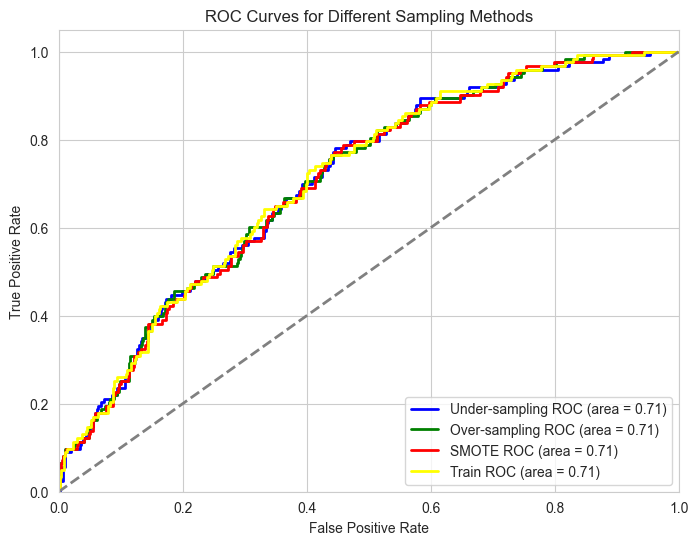

In [ ]:
# plot roc curves of all base models
plot_roc_curves(y_test, y_proba_lr_under, y_proba_lr_over, y_proba_lr_smote, y_proba_lr_test)

## Optimization parameter for all 3 sampling techniques

Sampling Method: under
Best parameters found: {'solver': 'liblinear', 'penalty': 'l1', 'C': 0.03359818286283781}
Best score: 0.6693041467769859


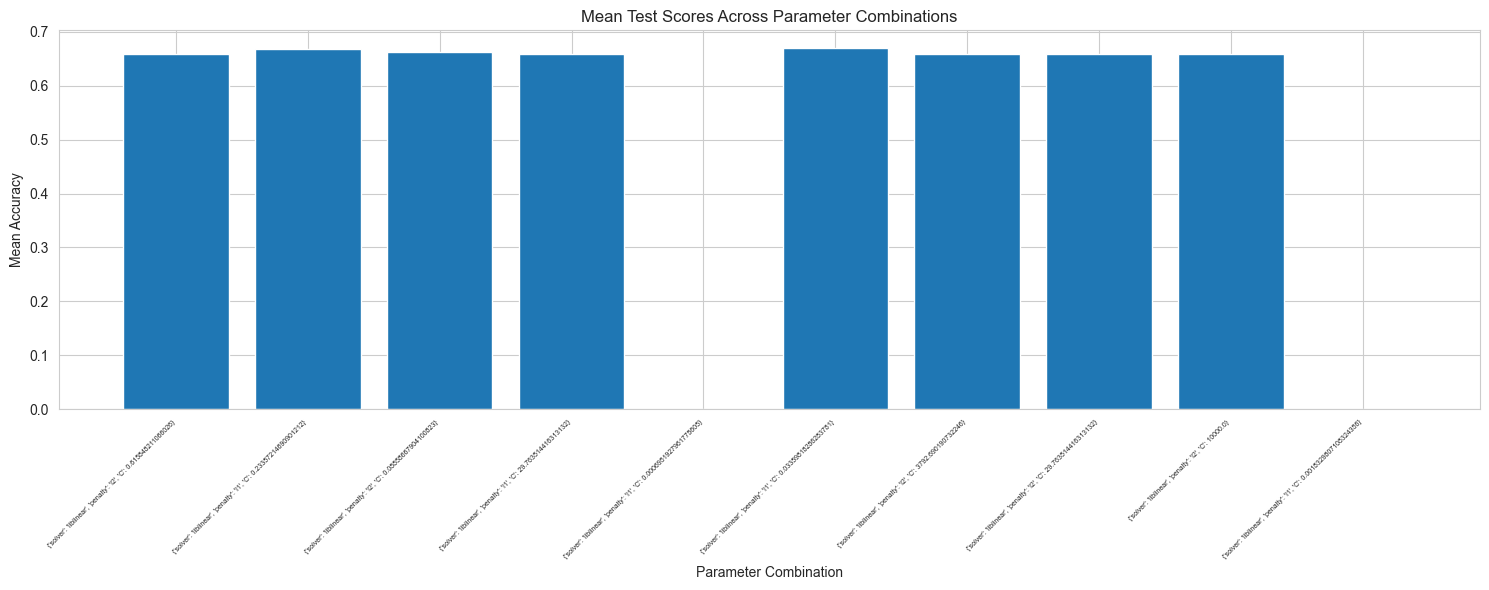

Sampling Method: over
Best parameters found: {'solver': 'liblinear', 'penalty': 'l1', 'C': 0.03359818286283781}
Best score: 0.6977876702274076


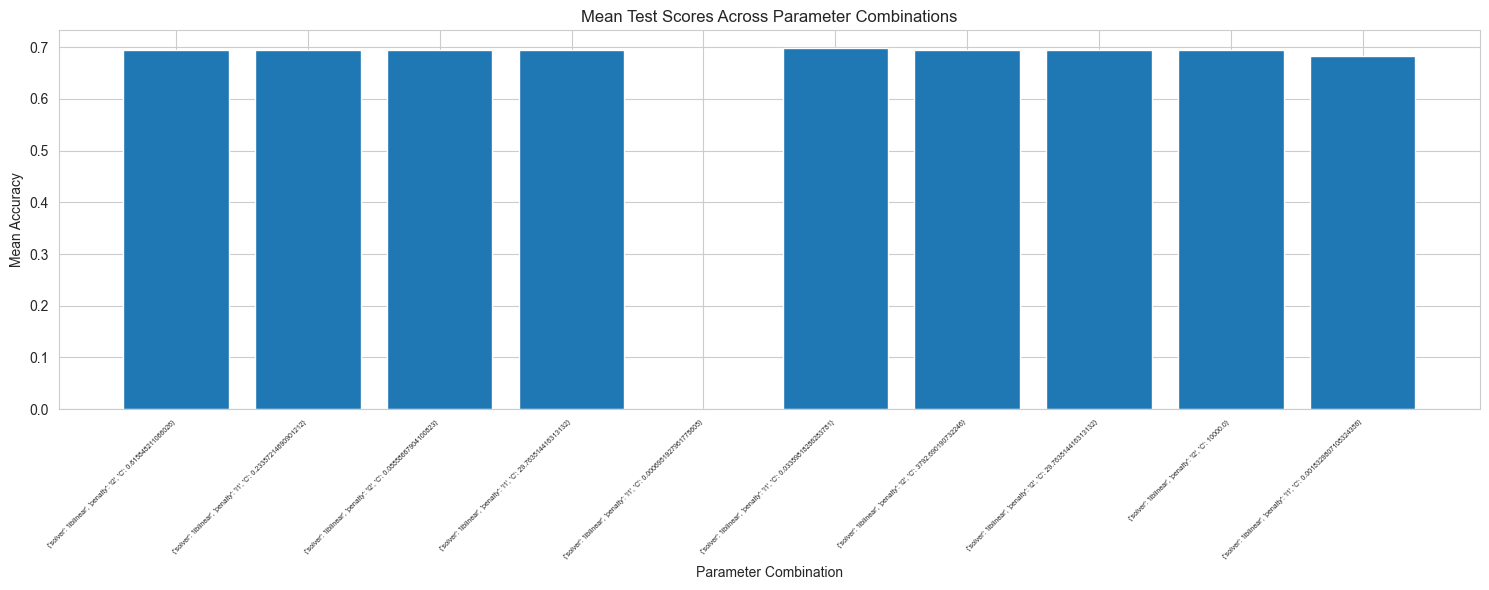

Sampling Method: smote
Best parameters found: {'solver': 'liblinear', 'penalty': 'l1', 'C': 0.03359818286283781}
Best score: 0.6825480569772087


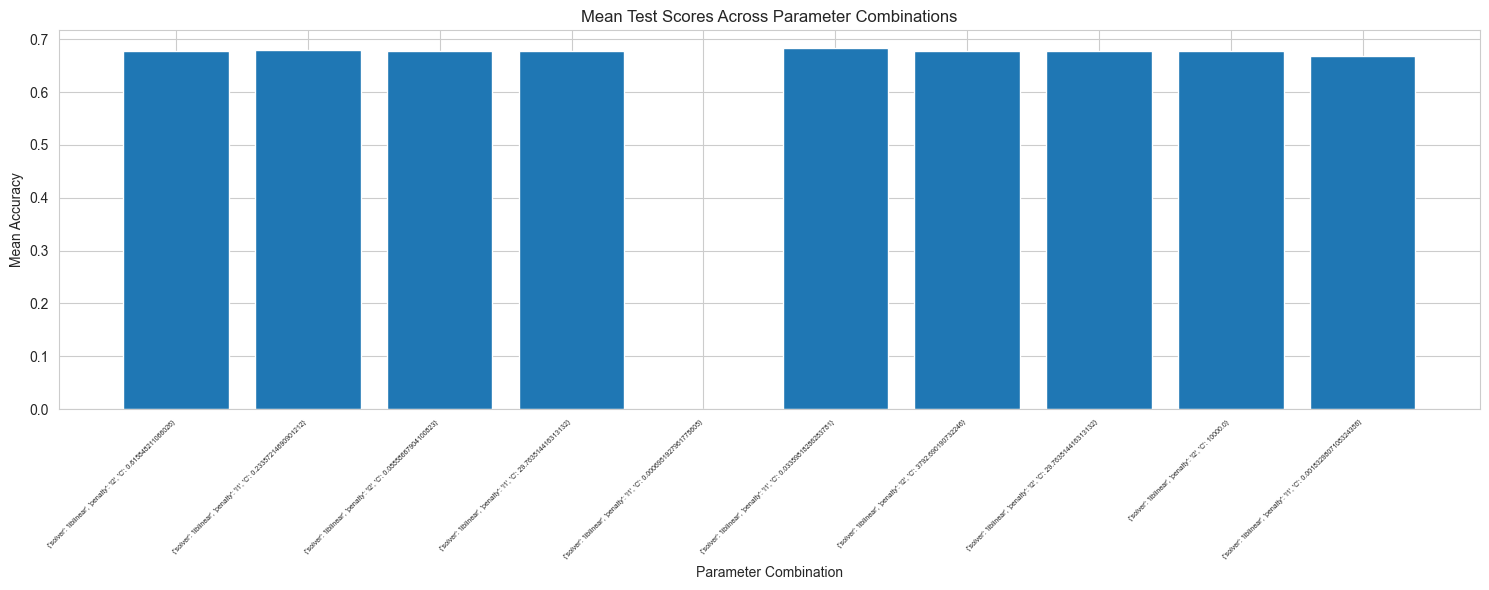

Sampling Method: train
Best parameters found: {'solver': 'liblinear', 'penalty': 'l2', 'C': 0.615848211066026}
Best score: 0.16101571619475527


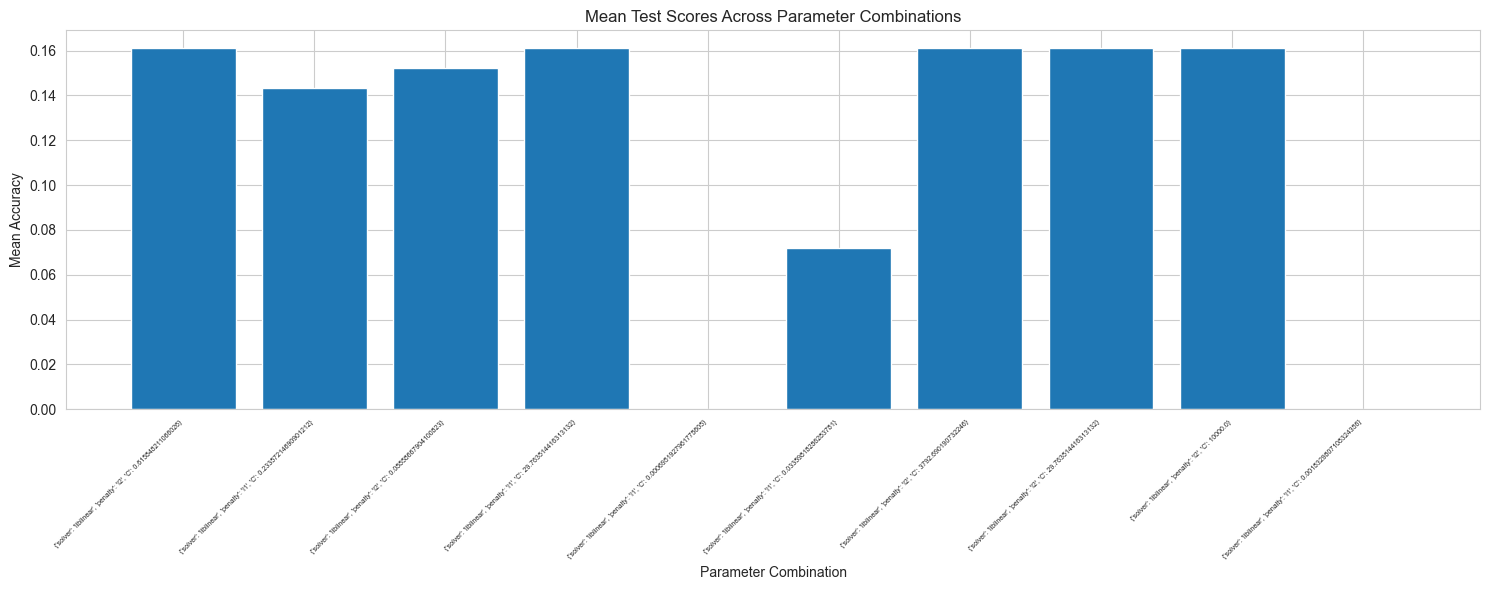

In [97]:
# define a parameter grid to tune the hyperparameters of the model
param_grid_lr = {
    'C': np.logspace(-4, 4, 20),
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear']
}

model_optimizer(lr, X_train, y_train, X_test, y_test,"under", param_grid_lr)
model_optimizer(lr, X_train, y_train, X_test, y_test,"over", param_grid_lr)
model_optimizer(lr, X_train, y_train, X_test, y_test,"smote", param_grid_lr)
model_optimizer(lr, X_train, y_train, X_test, y_test,"train", param_grid_lr)

## Run optimized models

Test Set Performance:
Confusion Matrix (Test):
[[440 285]
 [ 40  83]]

Accuracy of Model (Test): 61.67452830188679 

              precision    recall  f1-score   support

           0       0.92      0.61      0.73       725
           1       0.23      0.67      0.34       123

    accuracy                           0.62       848
   macro avg       0.57      0.64      0.53       848
weighted avg       0.82      0.62      0.67       848

Test Set Performance:
Confusion Matrix (Test):
[[486 239]
 [ 45  78]]

Accuracy of Model (Test): 66.50943396226415 

              precision    recall  f1-score   support

           0       0.92      0.67      0.77       725
           1       0.25      0.63      0.35       123

    accuracy                           0.67       848
   macro avg       0.58      0.65      0.56       848
weighted avg       0.82      0.67      0.71       848

Test Set Performance:
Confusion Matrix (Test):
[[474 251]
 [ 46  77]]

Accuracy of Model (Test): 64.976415094339

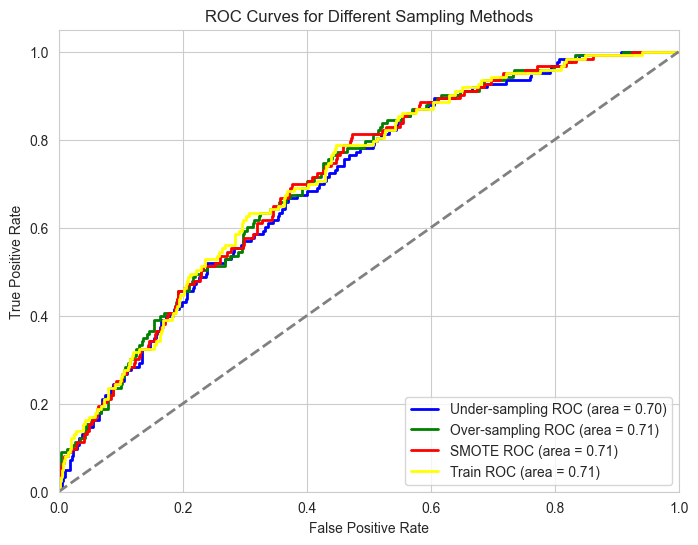

In [52]:
lr = LogisticRegression(solver= 'liblinear', penalty= 'l1', C= 0.03359818286283781)
y_proba_lr_under_opt = run_model(lr, X_train, y_train, X_test, y_test, "under", "optimized model")
y_proba_lr_over_opt = run_model(lr, X_train, y_train, X_test, y_test, "over", "optimized model")
y_proba_lr_smote_opt = run_model(lr, X_train, y_train, X_test, y_test, "smote", "optimized model")
y_proba_lr_train_opt = run_model(lr, X_train, y_train, X_test, y_test, "train", "optimized model")

# plot roc curves for optimized models
plot_roc_curves(y_test, y_proba_lr_under_opt, y_proba_lr_over_opt, y_proba_lr_smote_opt, y_proba_lr_train_opt)

# Naive Bayes

## Base classifier without tuning

In [53]:
from sklearn.naive_bayes import GaussianNB

nb = GaussianNB()
y_proba_nb_under = run_model(nb, X_train, y_train, X_test, y_test, "under", "base model")
y_proba_nb_over = run_model(nb, X_train, y_train, X_test, y_test, "over", "base model")
y_proba_nb_smote = run_model(nb, X_train, y_train, X_test, y_test, "smote", "base model")
y_proba_nb_train = run_model(nb, X_train, y_train, X_test, y_test, "train", "base model")


Test Set Performance:
Confusion Matrix (Test):
[[670  55]
 [ 96  27]]

Accuracy of Model (Test): 82.19339622641509 

              precision    recall  f1-score   support

           0       0.87      0.92      0.90       725
           1       0.33      0.22      0.26       123

    accuracy                           0.82       848
   macro avg       0.60      0.57      0.58       848
weighted avg       0.80      0.82      0.81       848

Test Set Performance:
Confusion Matrix (Test):
[[660  65]
 [ 90  33]]

Accuracy of Model (Test): 81.72169811320755 

              precision    recall  f1-score   support

           0       0.88      0.91      0.89       725
           1       0.34      0.27      0.30       123

    accuracy                           0.82       848
   macro avg       0.61      0.59      0.60       848
weighted avg       0.80      0.82      0.81       848

Test Set Performance:
Confusion Matrix (Test):
[[657  68]
 [ 89  34]]

Accuracy of Model (Test): 81.485849056603

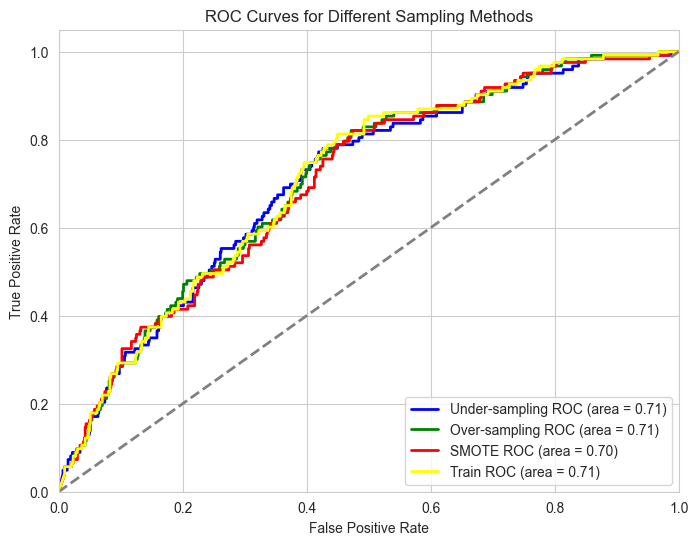

In [54]:
plot_roc_curves(y_test, y_proba_nb_under, y_proba_nb_over, y_proba_nb_smote, y_proba_nb_train)

## Optimization parameter for all 3 sampling techniques

Sampling Method: under
Best parameters found: {'var_smoothing': 0.001}
Best score: 0.4056423968188674


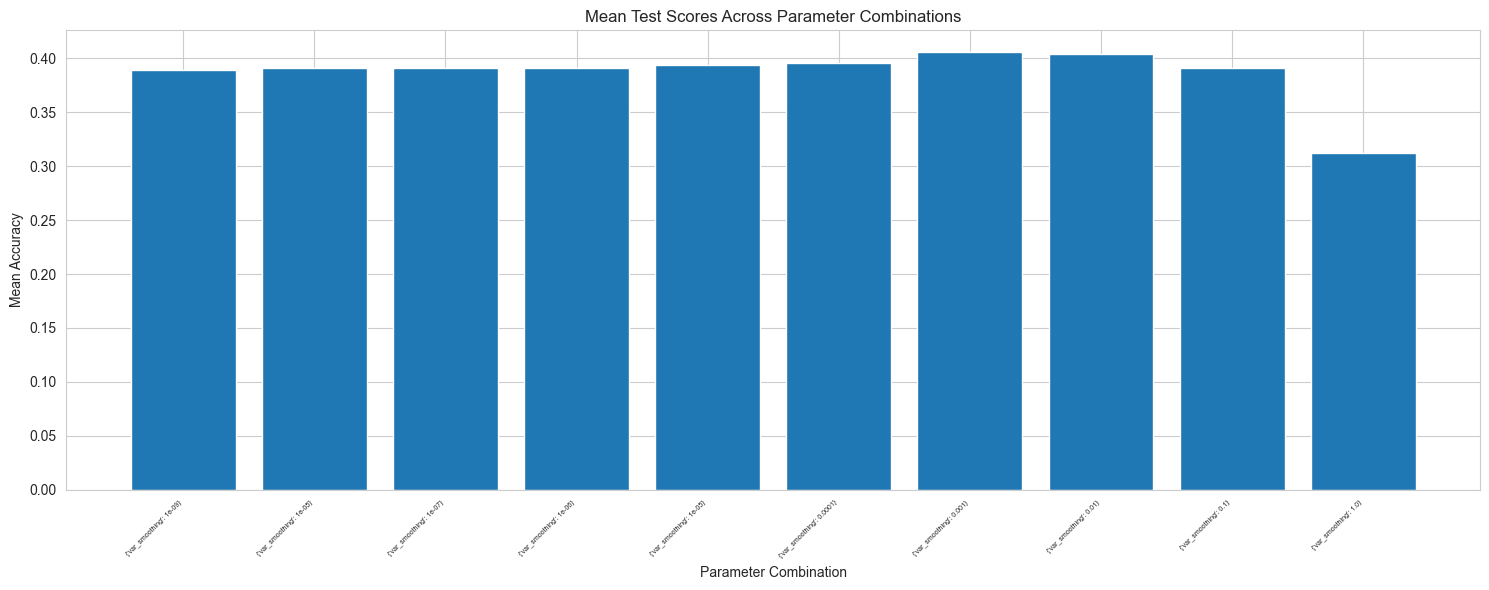

Sampling Method: over
Best parameters found: {'var_smoothing': 1e-09}
Best score: 0.45136298889911564


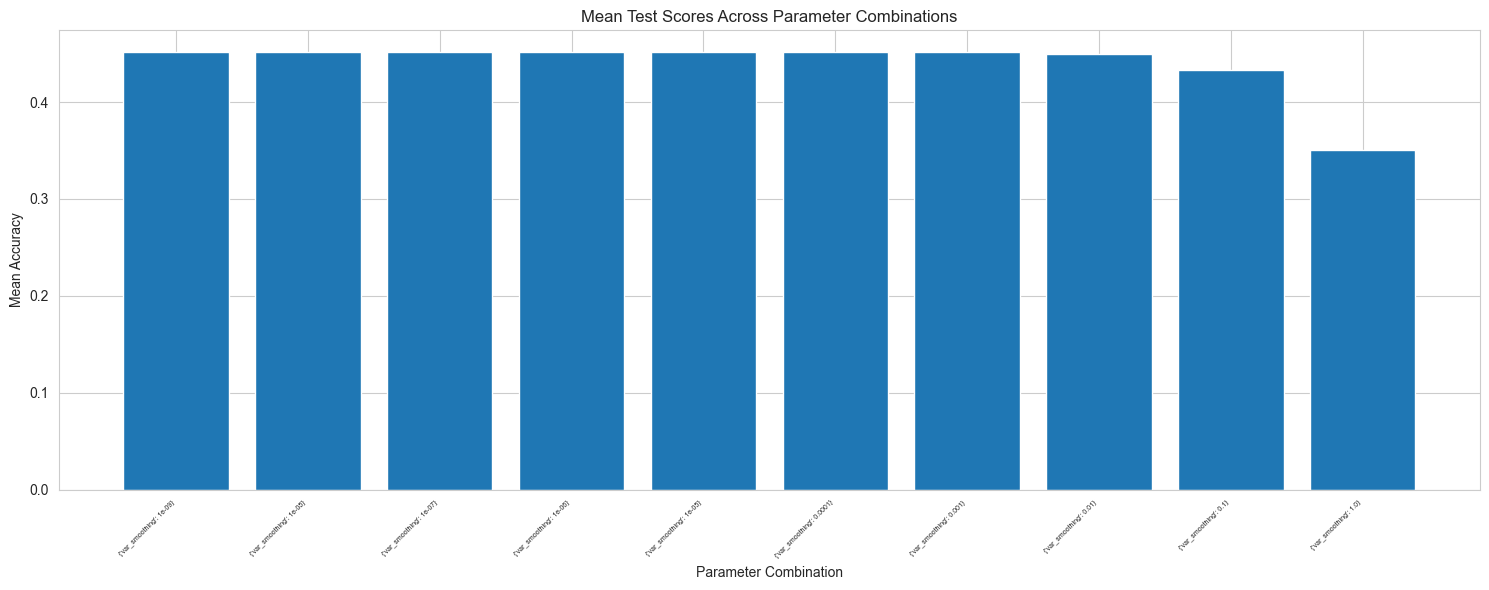

Sampling Method: smote
Best parameters found: {'var_smoothing': 1e-09}
Best score: 0.42824429281717846


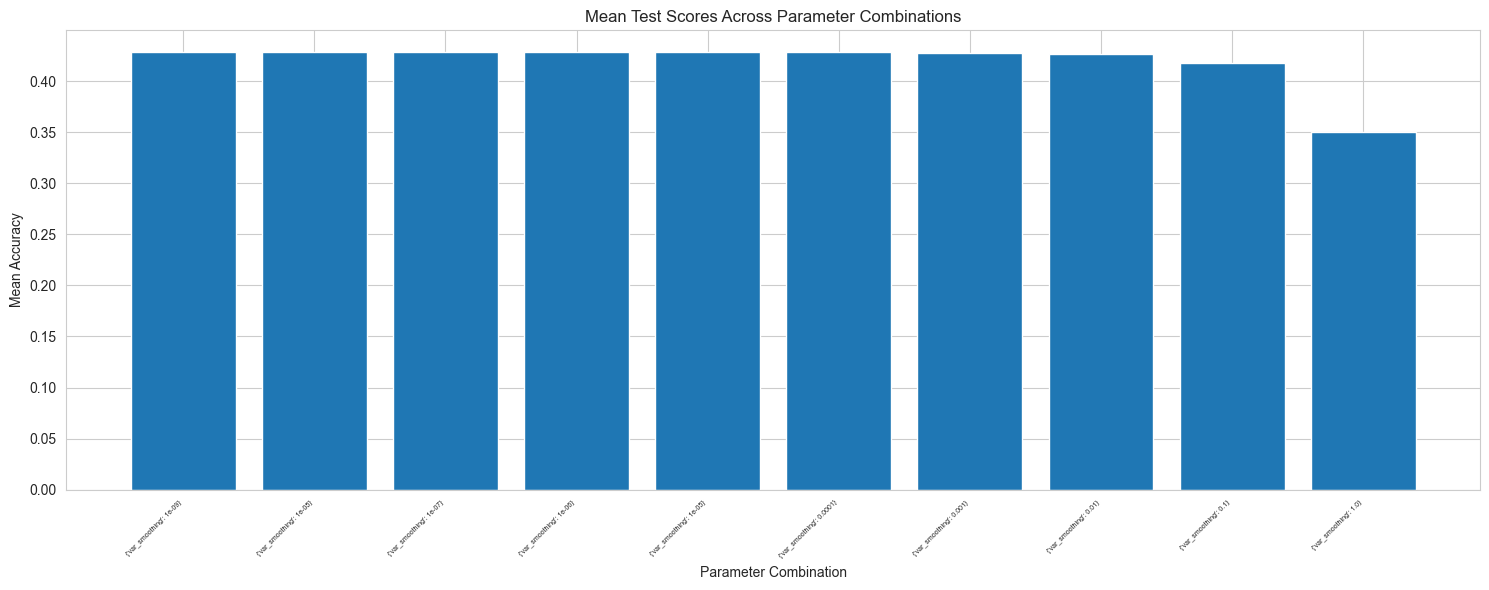

Sampling Method: train
Best parameters found: {'var_smoothing': 1e-09}
Best score: 0.27459875947055645


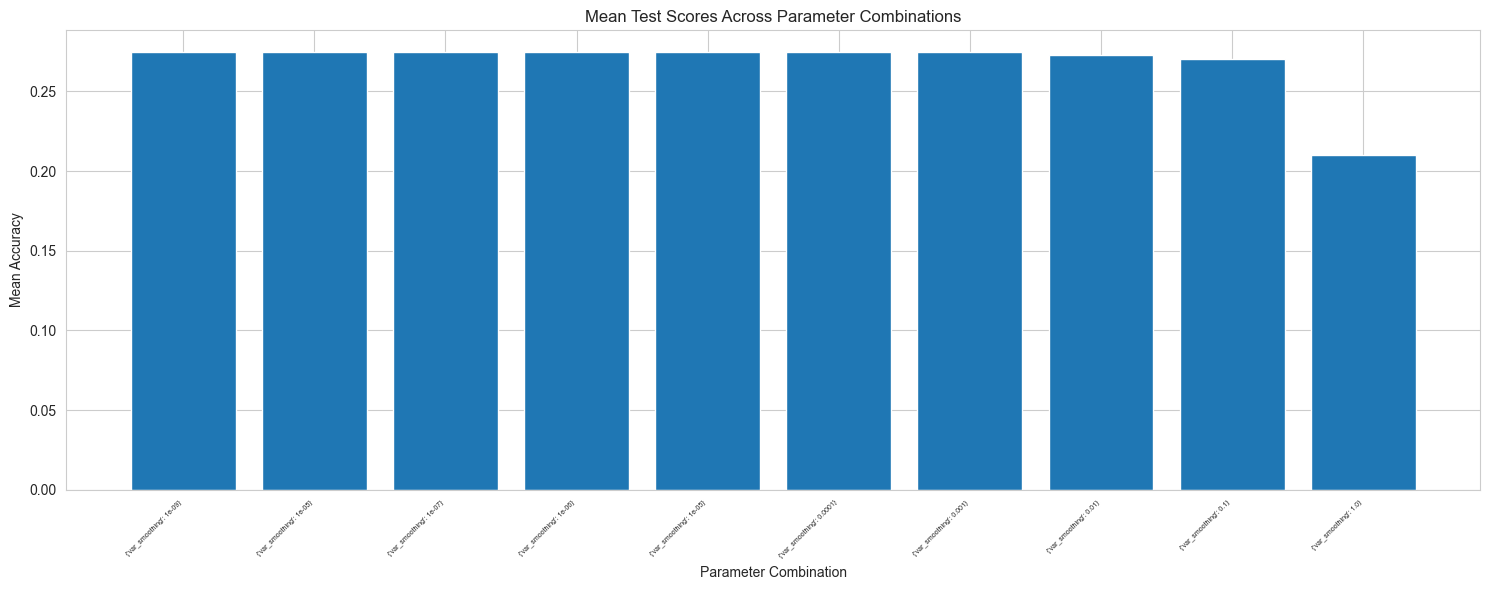

In [55]:
# define a parameter grid to tune the hyperparameters of the model
param_grid_nb = {
    'var_smoothing': np.logspace(-9, 0, 10)  # A range from 1e-9 to 1 
}

model_optimizer(nb, X_train, y_train, X_test, y_test,"under", param_grid_nb)
model_optimizer(nb, X_train, y_train, X_test, y_test,"over", param_grid_nb)
model_optimizer(nb, X_train, y_train, X_test, y_test,"smote", param_grid_nb)
model_optimizer(nb, X_train, y_train, X_test, y_test,"train", param_grid_nb)

## Run optimized Models

Test Set Performance:
Confusion Matrix (Test):
[[671  54]
 [ 96  27]]

Accuracy of Model (Test): 82.31132075471697 

              precision    recall  f1-score   support

           0       0.87      0.93      0.90       725
           1       0.33      0.22      0.26       123

    accuracy                           0.82       848
   macro avg       0.60      0.57      0.58       848
weighted avg       0.80      0.82      0.81       848

Test Set Performance:
Confusion Matrix (Test):
[[660  65]
 [ 90  33]]

Accuracy of Model (Test): 81.72169811320755 

              precision    recall  f1-score   support

           0       0.88      0.91      0.89       725
           1       0.34      0.27      0.30       123

    accuracy                           0.82       848
   macro avg       0.61      0.59      0.60       848
weighted avg       0.80      0.82      0.81       848

Test Set Performance:
Confusion Matrix (Test):
[[657  68]
 [ 89  34]]

Accuracy of Model (Test): 81.485849056603

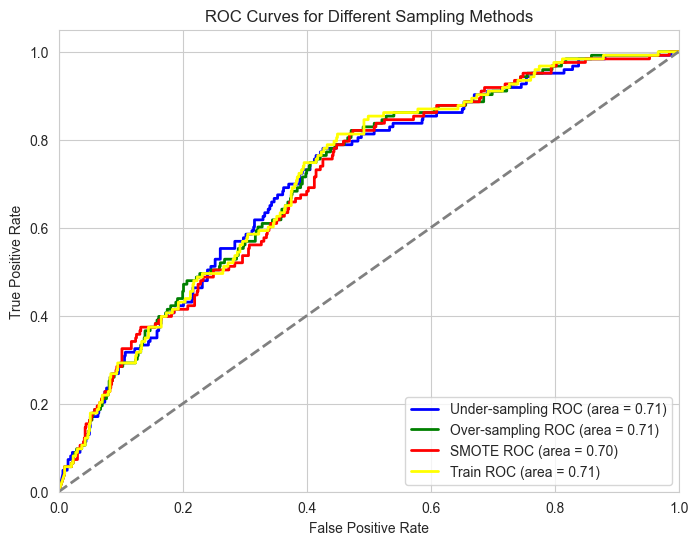

In [56]:
# create an instance of the model with the optimized hyperparameters
nb_under = GaussianNB(var_smoothing= 0.01)
nb_over= GaussianNB(var_smoothing= 1e-09)
nb_smote= GaussianNB(var_smoothing= 1e-09)
nb_train= GaussianNB(var_smoothing= 1e-09)


y_proba_nb_under_opt = run_model(nb_under, X_train, y_train, X_test, y_test, "under", "optimized model")
y_proba_nb_over_opt = run_model(nb_over, X_train, y_train, X_test, y_test, "over", "optimized model")
y_proba_nb_smote_opt = run_model(nb_smote, X_train, y_train, X_test, y_test, "smote", "optimized model")
y_proba_nb_train_opt = run_model(nb_train, X_train, y_train, X_test, y_test, "train", "optimized model")


# plot roc curves for optimized models
plot_roc_curves(y_test, y_proba_nb_under_opt, y_proba_nb_over_opt, y_proba_nb_smote_opt, y_proba_nb_train_opt)

# Decision Tree

## Base classifier without tuning

In [57]:
# decision tree
from sklearn.tree import DecisionTreeClassifier

dt = DecisionTreeClassifier(random_state=42)
y_proba_dt_under = run_model(dt, X_train, y_train, X_test, y_test, "under", "base model")
y_proba_dt_over = run_model(dt, X_train, y_train, X_test, y_test, "over", "base model")
y_proba_dt_smote = run_model(dt, X_train, y_train, X_test, y_test, "smote", "base model")
y_proba_dt_train = run_model(dt, X_train, y_train, X_test, y_test, "train", "base model")


Test Set Performance:
Confusion Matrix (Test):
[[407 318]
 [ 60  63]]

Accuracy of Model (Test): 55.42452830188679 

              precision    recall  f1-score   support

           0       0.87      0.56      0.68       725
           1       0.17      0.51      0.25       123

    accuracy                           0.55       848
   macro avg       0.52      0.54      0.47       848
weighted avg       0.77      0.55      0.62       848

Test Set Performance:
Confusion Matrix (Test):
[[643  82]
 [105  18]]

Accuracy of Model (Test): 77.94811320754717 

              precision    recall  f1-score   support

           0       0.86      0.89      0.87       725
           1       0.18      0.15      0.16       123

    accuracy                           0.78       848
   macro avg       0.52      0.52      0.52       848
weighted avg       0.76      0.78      0.77       848

Test Set Performance:
Confusion Matrix (Test):
[[571 154]
 [ 87  36]]

Accuracy of Model (Test): 71.580188679245

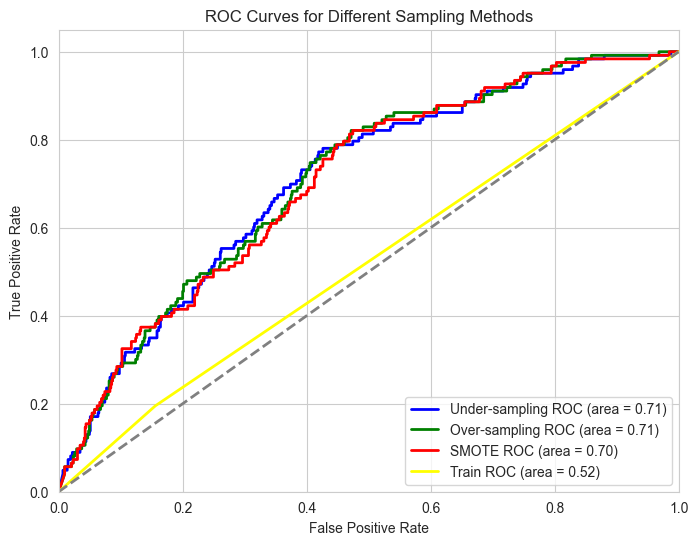

In [58]:
plot_roc_curves(y_test, y_proba_nb_under, y_proba_nb_over, y_proba_nb_smote, y_proba_dt_train)

## Optimization parameter for all 3 sampling techniques

Sampling Method: under
Best parameters found: {'splitter': 'best', 'random_state': 42, 'min_samples_split': 10, 'min_samples_leaf': 20, 'min_impurity_decrease': 0.0, 'max_leaf_nodes': 10, 'max_features': 0.1, 'max_depth': None, 'criterion': 'entropy', 'class_weight': 'balanced'}
Best score: 0.6249830395159832


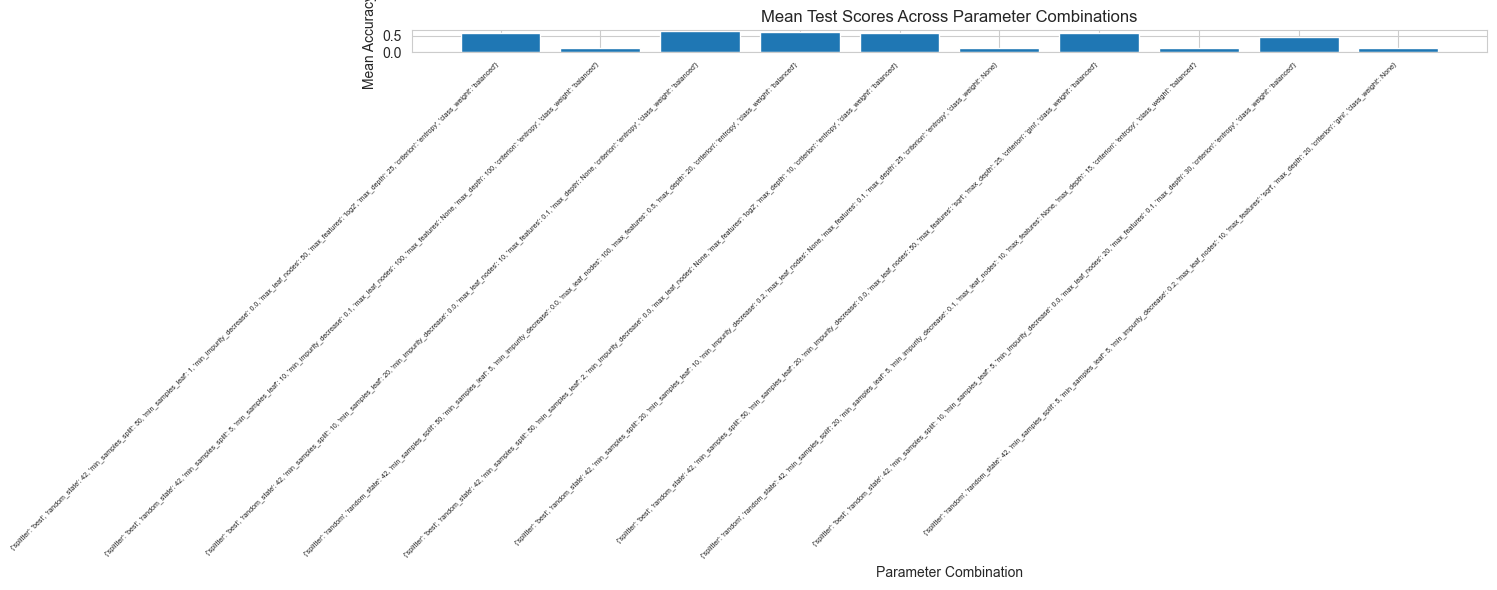

Sampling Method: over
Best parameters found: {'splitter': 'best', 'random_state': 42, 'min_samples_split': 50, 'min_samples_leaf': 2, 'min_impurity_decrease': 0.0, 'max_leaf_nodes': None, 'max_features': 'log2', 'max_depth': 10, 'criterion': 'entropy', 'class_weight': 'balanced'}
Best score: 0.7111707774590857


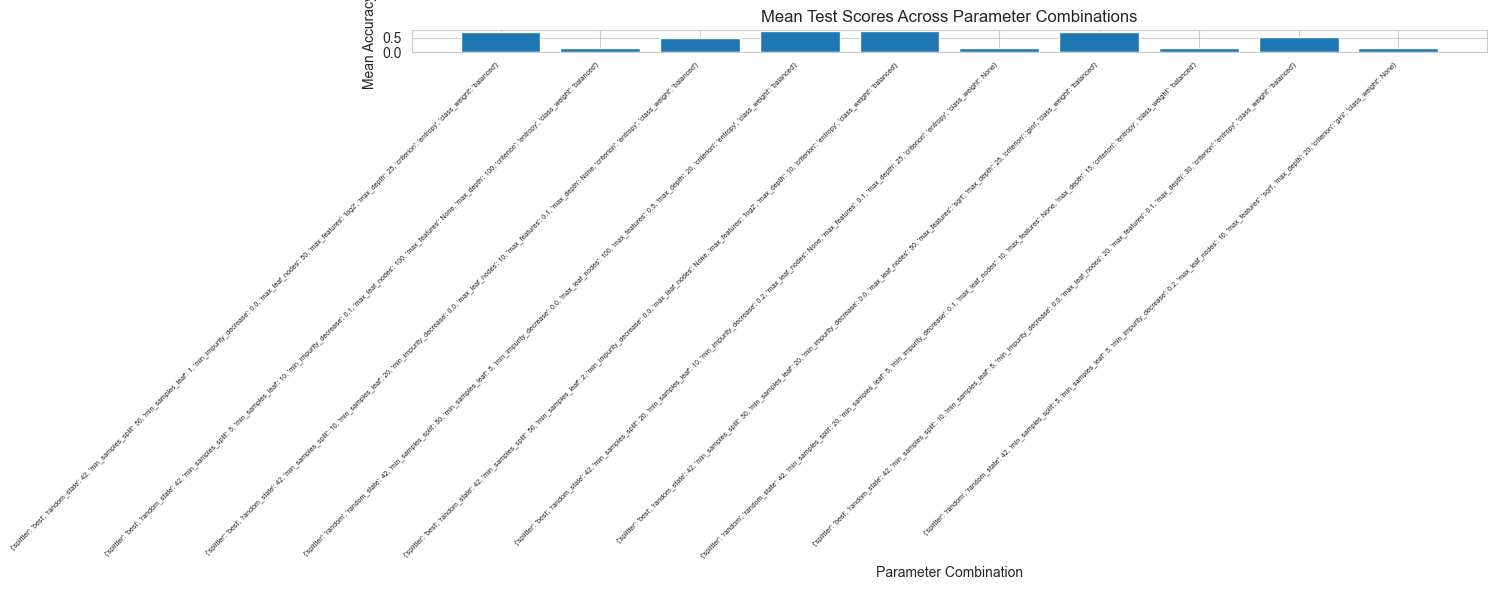

Sampling Method: smote
Best parameters found: {'splitter': 'best', 'random_state': 42, 'min_samples_split': 50, 'min_samples_leaf': 2, 'min_impurity_decrease': 0.0, 'max_leaf_nodes': None, 'max_features': 'log2', 'max_depth': 10, 'criterion': 'entropy', 'class_weight': 'balanced'}
Best score: 0.7049896641082476


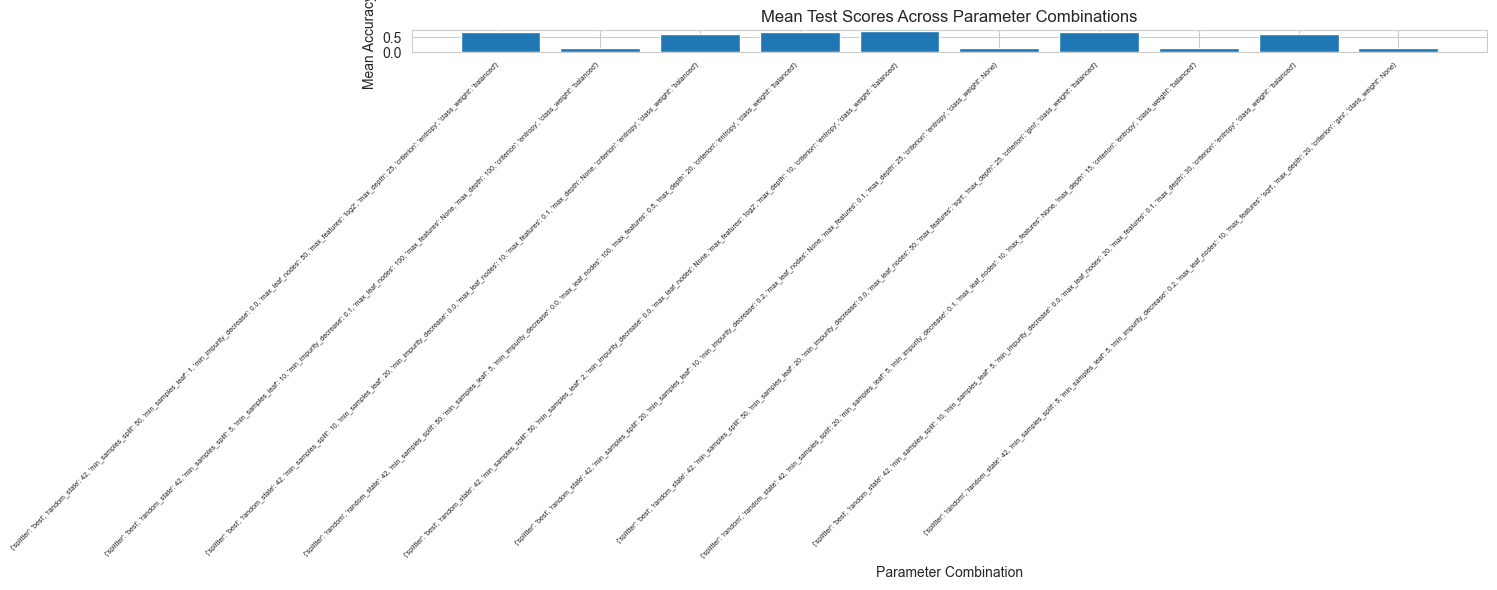

Sampling Method: train
Best parameters found: {'splitter': 'random', 'random_state': 42, 'min_samples_split': 50, 'min_samples_leaf': 5, 'min_impurity_decrease': 0.0, 'max_leaf_nodes': 100, 'max_features': 0.5, 'max_depth': 20, 'criterion': 'entropy', 'class_weight': 'balanced'}
Best score: 0.33858083859135657


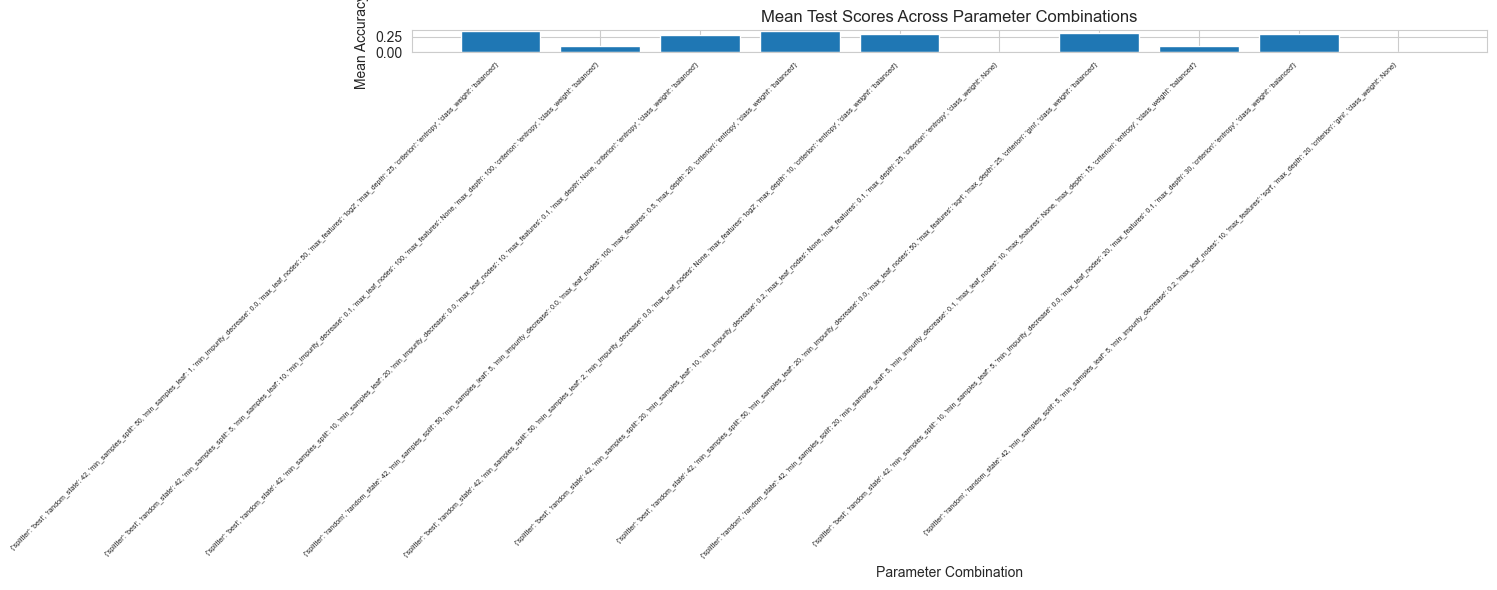

In [59]:
# define a parameter grid to tune the hyperparameters of the model
param_grid_dt = {
    "criterion": ["gini", "entropy"],  # Gini impurity or Entropy
    "splitter": ["best", "random"],    # Best split strategy or random
    "max_depth": [None, 5, 10, 15, 20, 25, 30, 50, 100],  # Various depths for the tree
    "min_samples_split": [2, 5, 10, 20, 50],  # Minimum samples required to split
    "min_samples_leaf": [1, 2, 5, 10, 20],  # Minimum samples required at leaf nodes
    "max_features": [None, "sqrt", "log2", 0.1, 0.5],  # Feature selection strategies
    "max_leaf_nodes": [None, 10, 20, 50, 100],  # Limit the number of leaf nodes
    "min_impurity_decrease": [0.0, 0.1, 0.2],  # Minimum impurity decrease to split
    "class_weight": [None, "balanced"],  # Weight classes for imbalanced datasets
    "random_state": [42]
}

model_optimizer(dt, X_train, y_train, X_test, y_test,"under", param_grid_dt)
model_optimizer(dt, X_train, y_train, X_test, y_test,"over", param_grid_dt)
model_optimizer(dt, X_train, y_train, X_test, y_test,"smote", param_grid_dt)
model_optimizer(dt, X_train, y_train, X_test, y_test,"train", param_grid_dt)

## Run optimized Models

Test Set Performance:
Confusion Matrix (Test):
[[450 275]
 [ 47  76]]

Accuracy of Model (Test): 62.02830188679245 

              precision    recall  f1-score   support

           0       0.91      0.62      0.74       725
           1       0.22      0.62      0.32       123

    accuracy                           0.62       848
   macro avg       0.56      0.62      0.53       848
weighted avg       0.81      0.62      0.68       848

Test Set Performance:
Confusion Matrix (Test):
[[470 255]
 [ 58  65]]

Accuracy of Model (Test): 63.089622641509436 

              precision    recall  f1-score   support

           0       0.89      0.65      0.75       725
           1       0.20      0.53      0.29       123

    accuracy                           0.63       848
   macro avg       0.55      0.59      0.52       848
weighted avg       0.79      0.63      0.68       848

Test Set Performance:
Confusion Matrix (Test):
[[516 209]
 [ 66  57]]

Accuracy of Model (Test): 67.57075471698

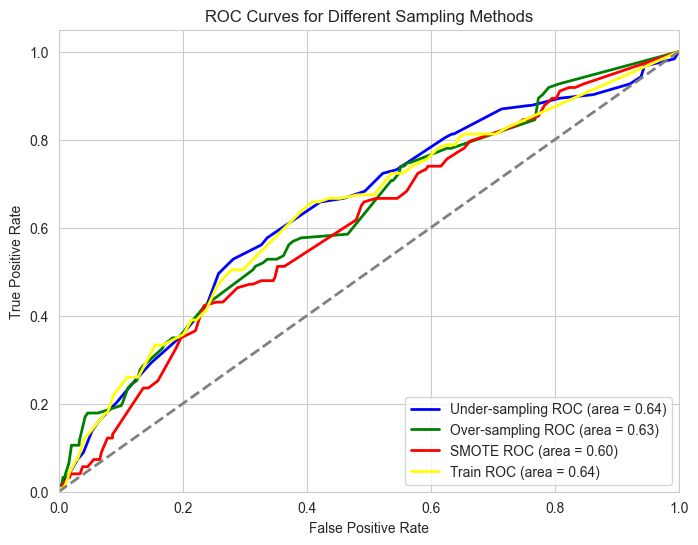

In [60]:
# create an instance of the model with the optimized hyperparameters
dt_under = DecisionTreeClassifier(splitter= 'random', min_samples_split= 50, min_samples_leaf= 5, min_impurity_decrease= 0.0, max_leaf_nodes= 100, max_features= 0.5, max_depth= 20, criterion= 'entropy', class_weight= 'balanced', random_state= 42)
dt_over = DecisionTreeClassifier(splitter= 'best', min_samples_split= 50, min_samples_leaf= 2, min_impurity_decrease= 0.0, max_leaf_nodes= None, max_features= "log2", max_depth= 10, criterion= 'entropy', class_weight= 'balanced', random_state= 42)
dt_smote = DecisionTreeClassifier(splitter= 'best', min_samples_split= 50, min_samples_leaf= 2, min_impurity_decrease= 0.0, max_leaf_nodes= None, max_features= "log2", max_depth= 10, criterion= 'entropy', class_weight= 'balanced', random_state= 42)
dt_train = DecisionTreeClassifier(splitter= 'random', min_samples_split= 50, min_samples_leaf= 5, min_impurity_decrease= 0.0, max_leaf_nodes= 100, max_features= 0.5, max_depth= 20, criterion= 'entropy', class_weight= 'balanced', random_state= 42)

y_proba_dt_under_opt = run_model(dt_under, X_train, y_train, X_test, y_test, "under", "optimized model")
y_proba_dt_over_opt = run_model(dt_over, X_train, y_train, X_test, y_test, "over", "optimized model")
y_proba_dt_smote_opt = run_model(dt_smote, X_train, y_train, X_test, y_test, "smote", "optimized model")
y_proba_dt_train_opt = run_model(dt_smote, X_train, y_train, X_test, y_test, "train", "optimized model")


# plot roc curves for optimized models
plot_roc_curves(y_test, y_proba_dt_under_opt, y_proba_dt_over_opt, y_proba_dt_smote_opt, y_proba_dt_train_opt)

# Random Forest

## Base classifier without tuning

In [61]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(random_state=42)
y_proba_rf_under = run_model(rf, X_train, y_train, X_test, y_test, "under", "base model")
y_proba_rf_over = run_model(rf, X_train, y_train, X_test, y_test, "over", "base model")
y_proba_rf_smote = run_model(rf, X_train, y_train, X_test, y_test, "smote", "base model")
y_proba_rf_train = run_model(rf, X_train, y_train, X_test, y_test, "train", "base model")

Test Set Performance:
Confusion Matrix (Test):
[[488 237]
 [ 52  71]]

Accuracy of Model (Test): 65.91981132075472 

              precision    recall  f1-score   support

           0       0.90      0.67      0.77       725
           1       0.23      0.58      0.33       123

    accuracy                           0.66       848
   macro avg       0.57      0.63      0.55       848
weighted avg       0.81      0.66      0.71       848

Test Set Performance:
Confusion Matrix (Test):
[[699  26]
 [108  15]]

Accuracy of Model (Test): 84.19811320754717 

              precision    recall  f1-score   support

           0       0.87      0.96      0.91       725
           1       0.37      0.12      0.18       123

    accuracy                           0.84       848
   macro avg       0.62      0.54      0.55       848
weighted avg       0.79      0.84      0.81       848

Test Set Performance:
Confusion Matrix (Test):
[[665  60]
 [102  21]]

Accuracy of Model (Test): 80.896226415094

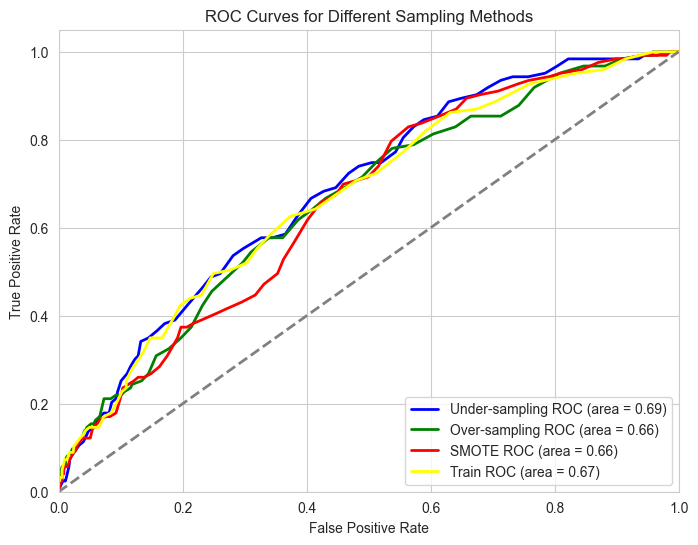

In [62]:
# plot roc curves of all base models
plot_roc_curves(y_test, y_proba_rf_under, y_proba_rf_over, y_proba_rf_smote, y_proba_rf_train)

## Optimization parameter for all 3 sampling techniques

c:\Users\joell\anaconda3\envs\DTH\Lib\site-packages\sklearn\model_selection\_validation.py:540: FitFailedWarning: 
15 fits failed out of a total of 50.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
10 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\joell\anaconda3\envs\DTH\Lib\site-packages\sklearn\model_selection\_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\joell\anaconda3\envs\DTH\Lib\site-packages\sklearn\base.py", line 1466, in wrapper
    estimator._validate_params()
  File "c:\Users\joell\anaconda3\envs\DTH\Lib\site-packages\sklearn\base.py", line 666, in _validate_params
    validate_parameter_constraints(
  File "c:\User

Sampling Method: under
Best parameters found: {'warm_start': True, 'random_state': 42, 'oob_score': False, 'n_estimators': 300, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_samples': 0.8, 'max_features': None, 'max_depth': 20, 'criterion': 'gini', 'class_weight': 'balanced', 'bootstrap': True}
Best score: 0.6643661926080117


C:\Users\joell\AppData\Local\Temp\ipykernel_41296\340764079.py:64: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


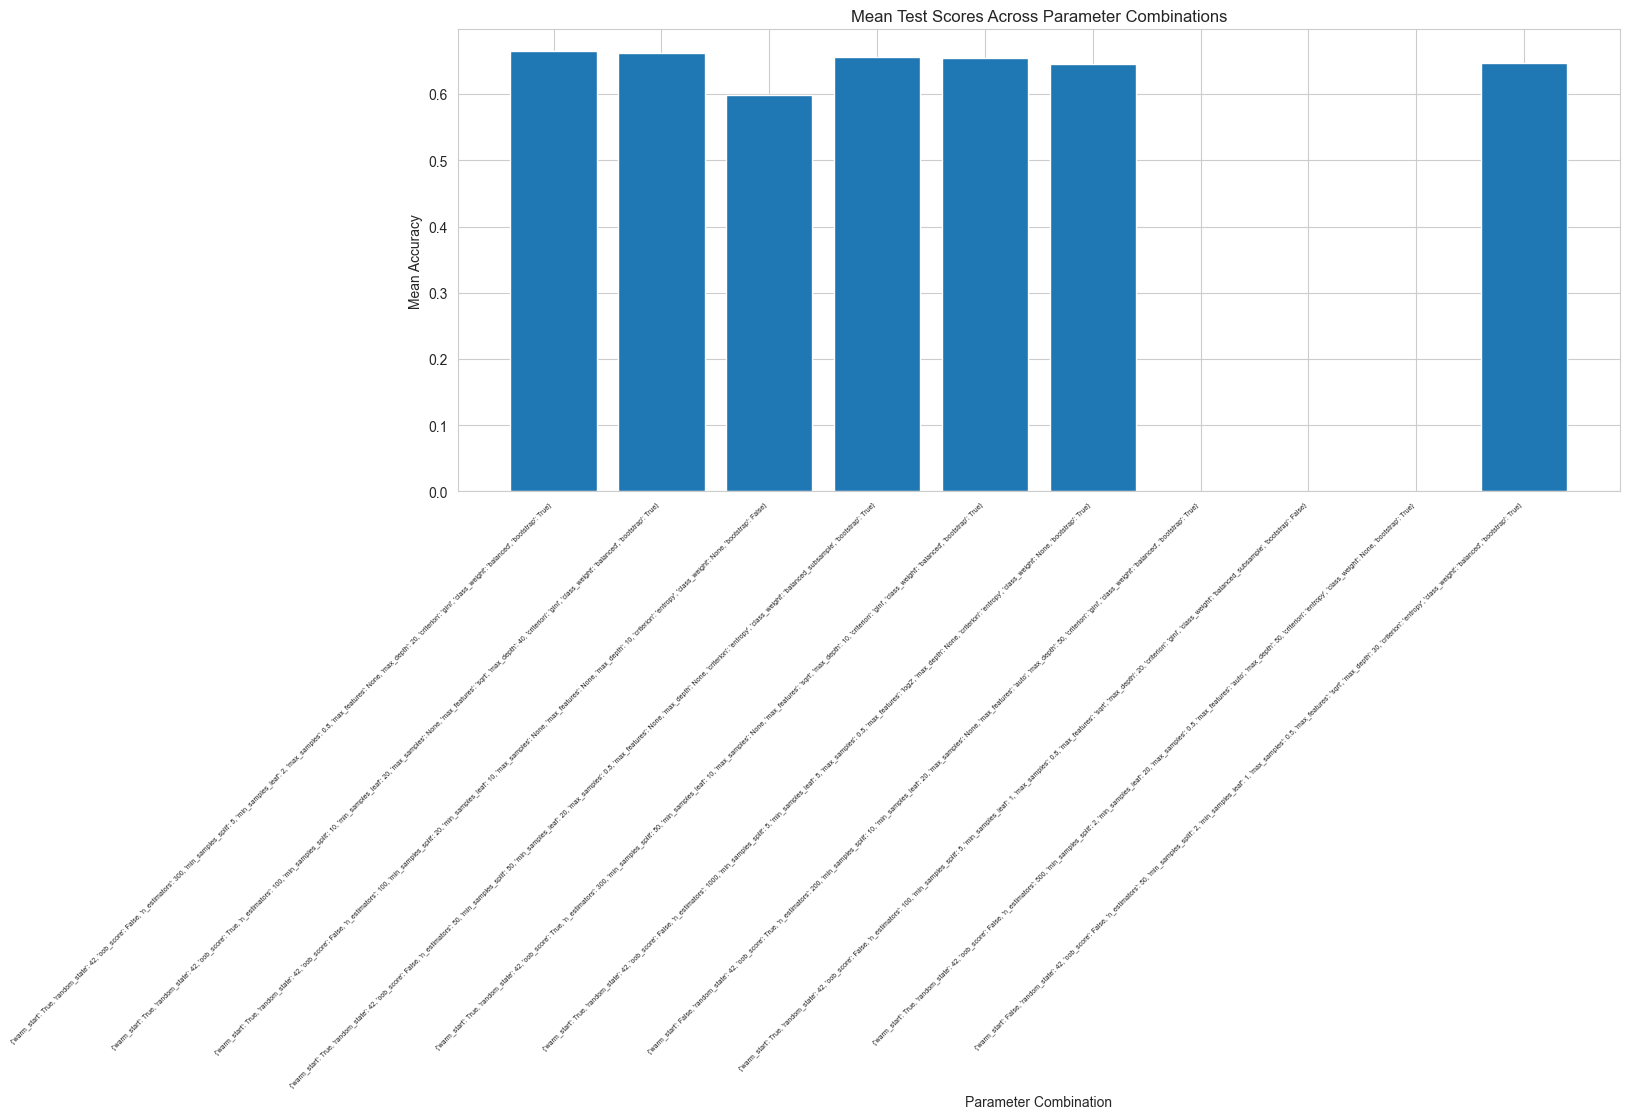

c:\Users\joell\anaconda3\envs\DTH\Lib\site-packages\sklearn\model_selection\_validation.py:540: FitFailedWarning: 
15 fits failed out of a total of 50.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
10 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\joell\anaconda3\envs\DTH\Lib\site-packages\sklearn\model_selection\_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\joell\anaconda3\envs\DTH\Lib\site-packages\sklearn\base.py", line 1466, in wrapper
    estimator._validate_params()
  File "c:\Users\joell\anaconda3\envs\DTH\Lib\site-packages\sklearn\base.py", line 666, in _validate_params
    validate_parameter_constraints(
  File "c:\User

Sampling Method: over
Best parameters found: {'warm_start': True, 'random_state': 42, 'oob_score': False, 'n_estimators': 300, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_samples': 0.8, 'max_features': None, 'max_depth': 20, 'criterion': 'gini', 'class_weight': 'balanced', 'bootstrap': True}
Best score: 0.9479805752621873


C:\Users\joell\AppData\Local\Temp\ipykernel_41296\340764079.py:64: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


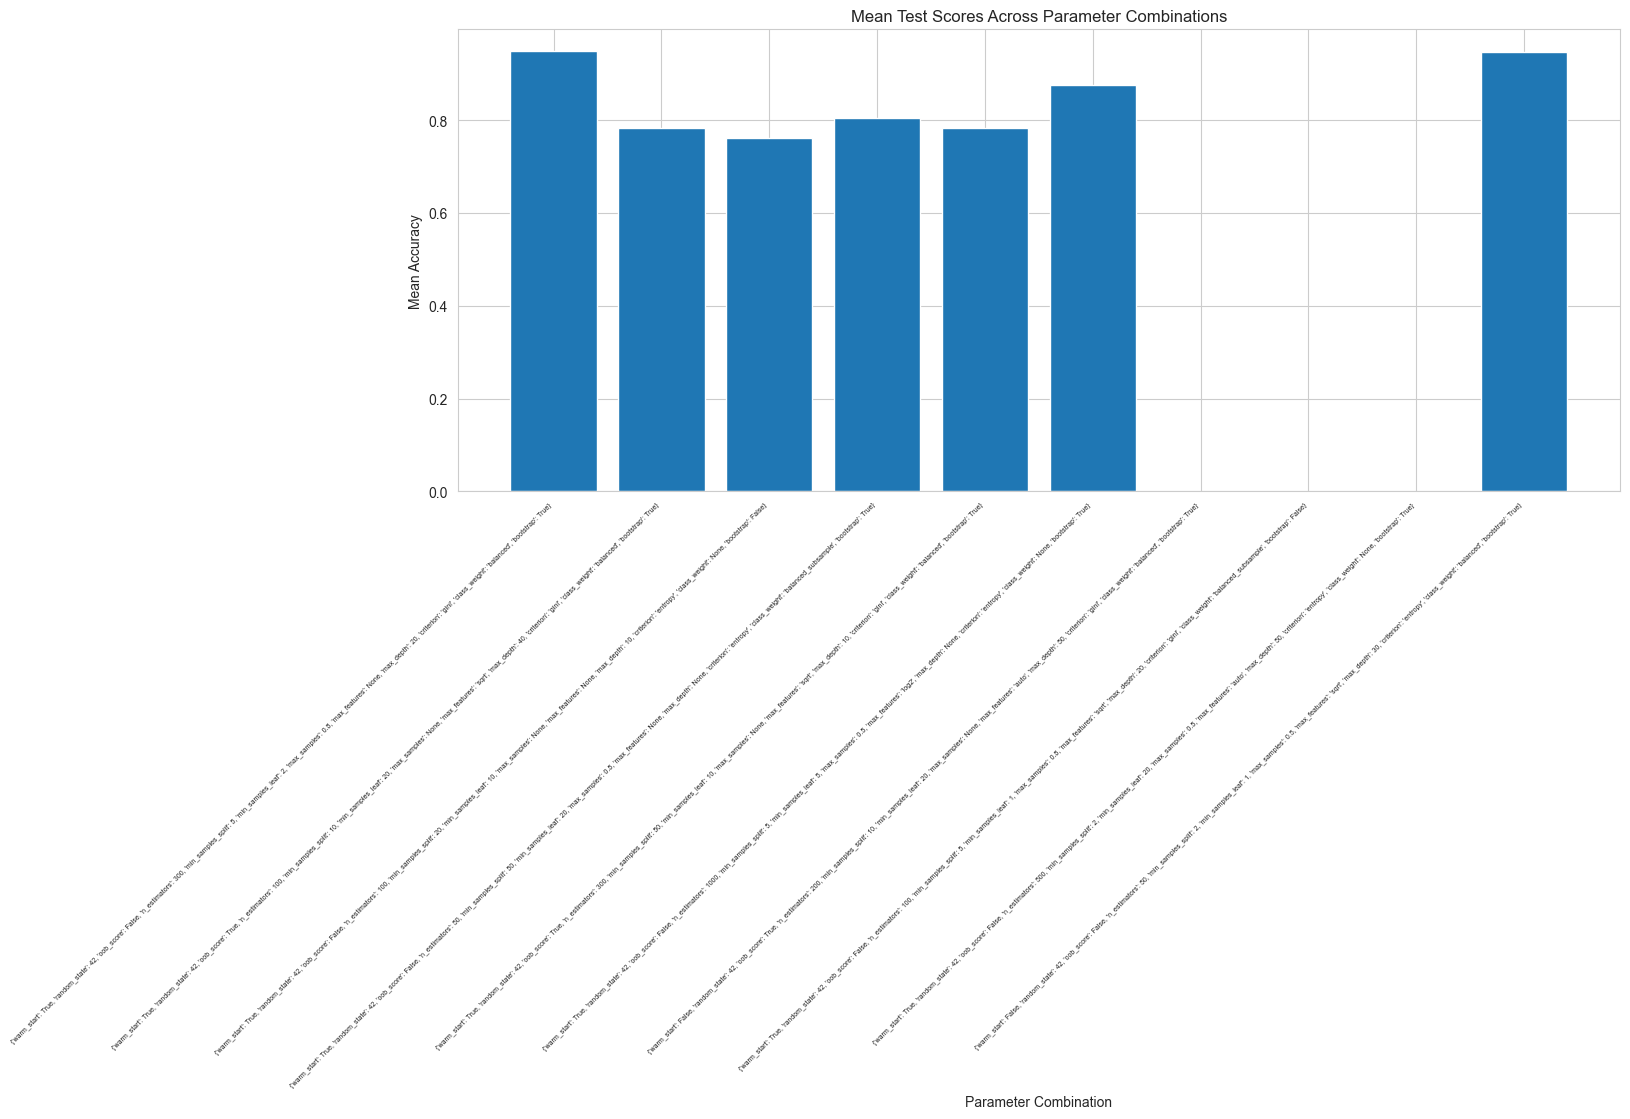

c:\Users\joell\anaconda3\envs\DTH\Lib\site-packages\sklearn\model_selection\_validation.py:540: FitFailedWarning: 
15 fits failed out of a total of 50.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
7 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\joell\anaconda3\envs\DTH\Lib\site-packages\sklearn\model_selection\_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\joell\anaconda3\envs\DTH\Lib\site-packages\sklearn\base.py", line 1466, in wrapper
    estimator._validate_params()
  File "c:\Users\joell\anaconda3\envs\DTH\Lib\site-packages\sklearn\base.py", line 666, in _validate_params
    validate_parameter_constraints(
  File "c:\Users

Sampling Method: smote
Best parameters found: {'warm_start': False, 'random_state': 42, 'oob_score': False, 'n_estimators': 50, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_samples': 0.5, 'max_features': 'sqrt', 'max_depth': 30, 'criterion': 'entropy', 'class_weight': 'balanced', 'bootstrap': True}
Best score: 0.8743510352619805


C:\Users\joell\AppData\Local\Temp\ipykernel_41296\340764079.py:64: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


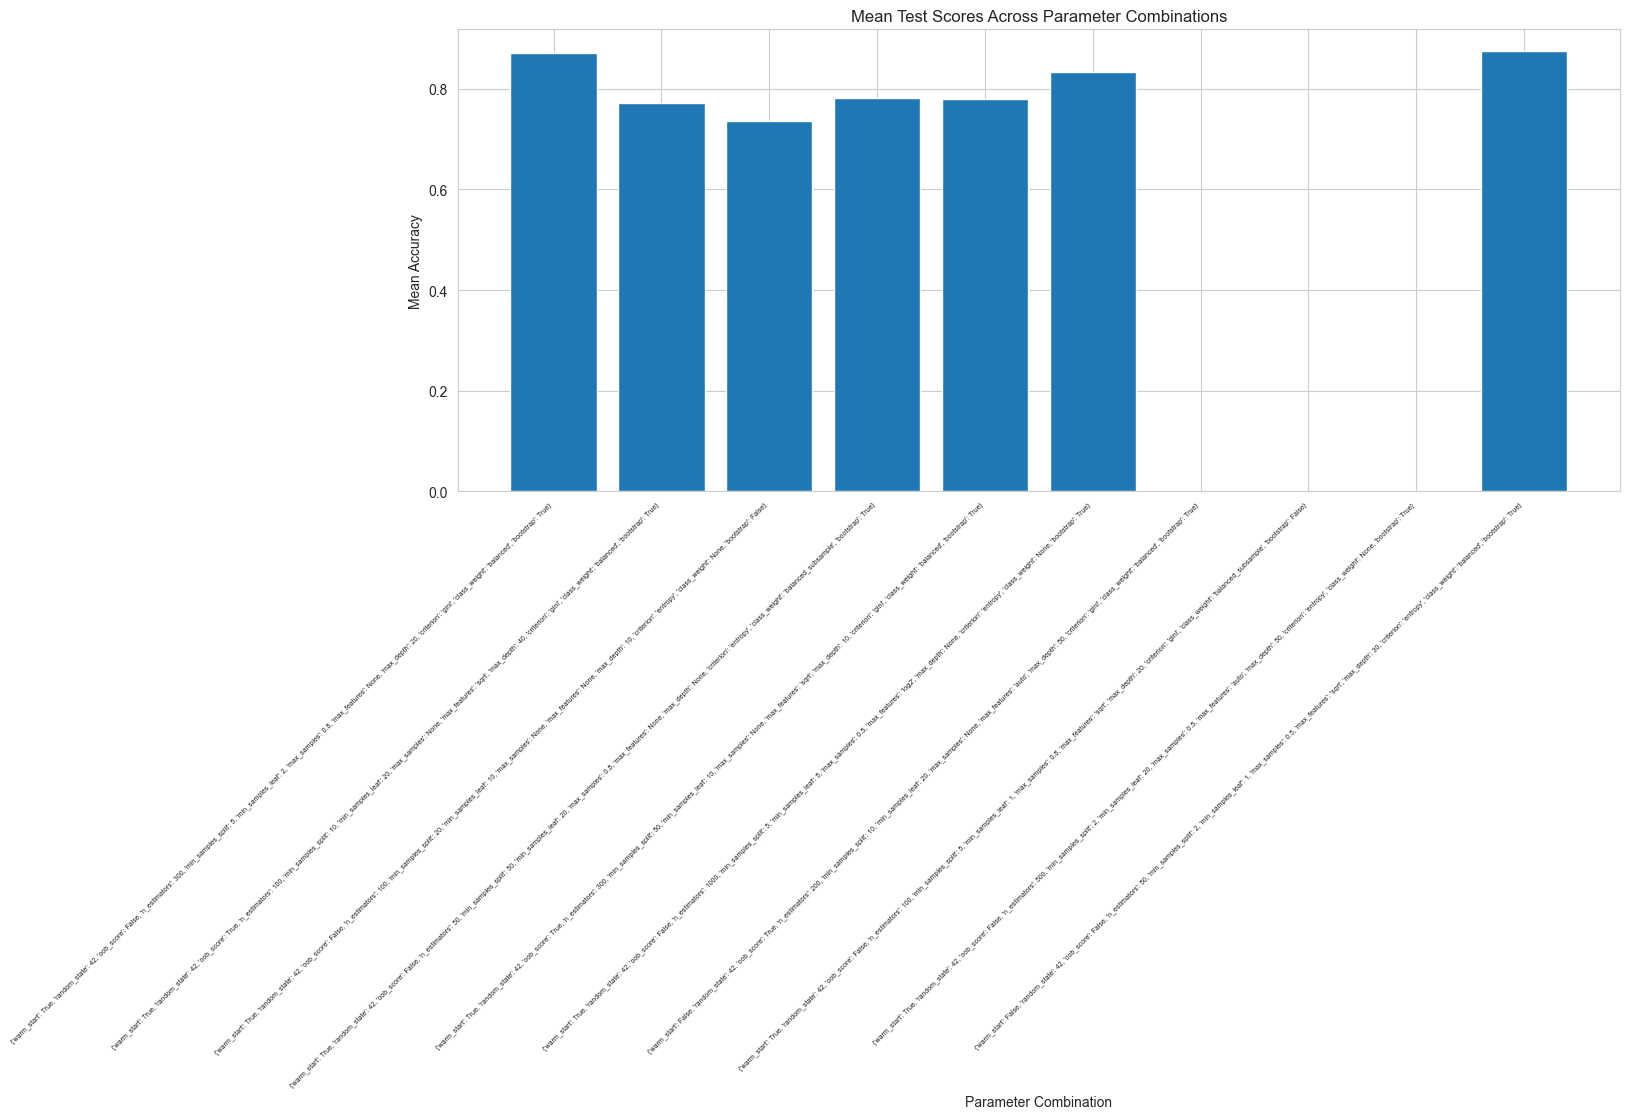

c:\Users\joell\anaconda3\envs\DTH\Lib\site-packages\sklearn\model_selection\_validation.py:540: FitFailedWarning: 
15 fits failed out of a total of 50.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
10 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\joell\anaconda3\envs\DTH\Lib\site-packages\sklearn\model_selection\_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\joell\anaconda3\envs\DTH\Lib\site-packages\sklearn\base.py", line 1466, in wrapper
    estimator._validate_params()
  File "c:\Users\joell\anaconda3\envs\DTH\Lib\site-packages\sklearn\base.py", line 666, in _validate_params
    validate_parameter_constraints(
  File "c:\User

Sampling Method: train
Best parameters found: {'warm_start': True, 'random_state': 42, 'oob_score': True, 'n_estimators': 100, 'min_samples_split': 10, 'min_samples_leaf': 20, 'max_samples': None, 'max_features': 'sqrt', 'max_depth': 40, 'criterion': 'gini', 'class_weight': 'balanced', 'bootstrap': True}
Best score: 0.38725921035305255


C:\Users\joell\AppData\Local\Temp\ipykernel_41296\340764079.py:64: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


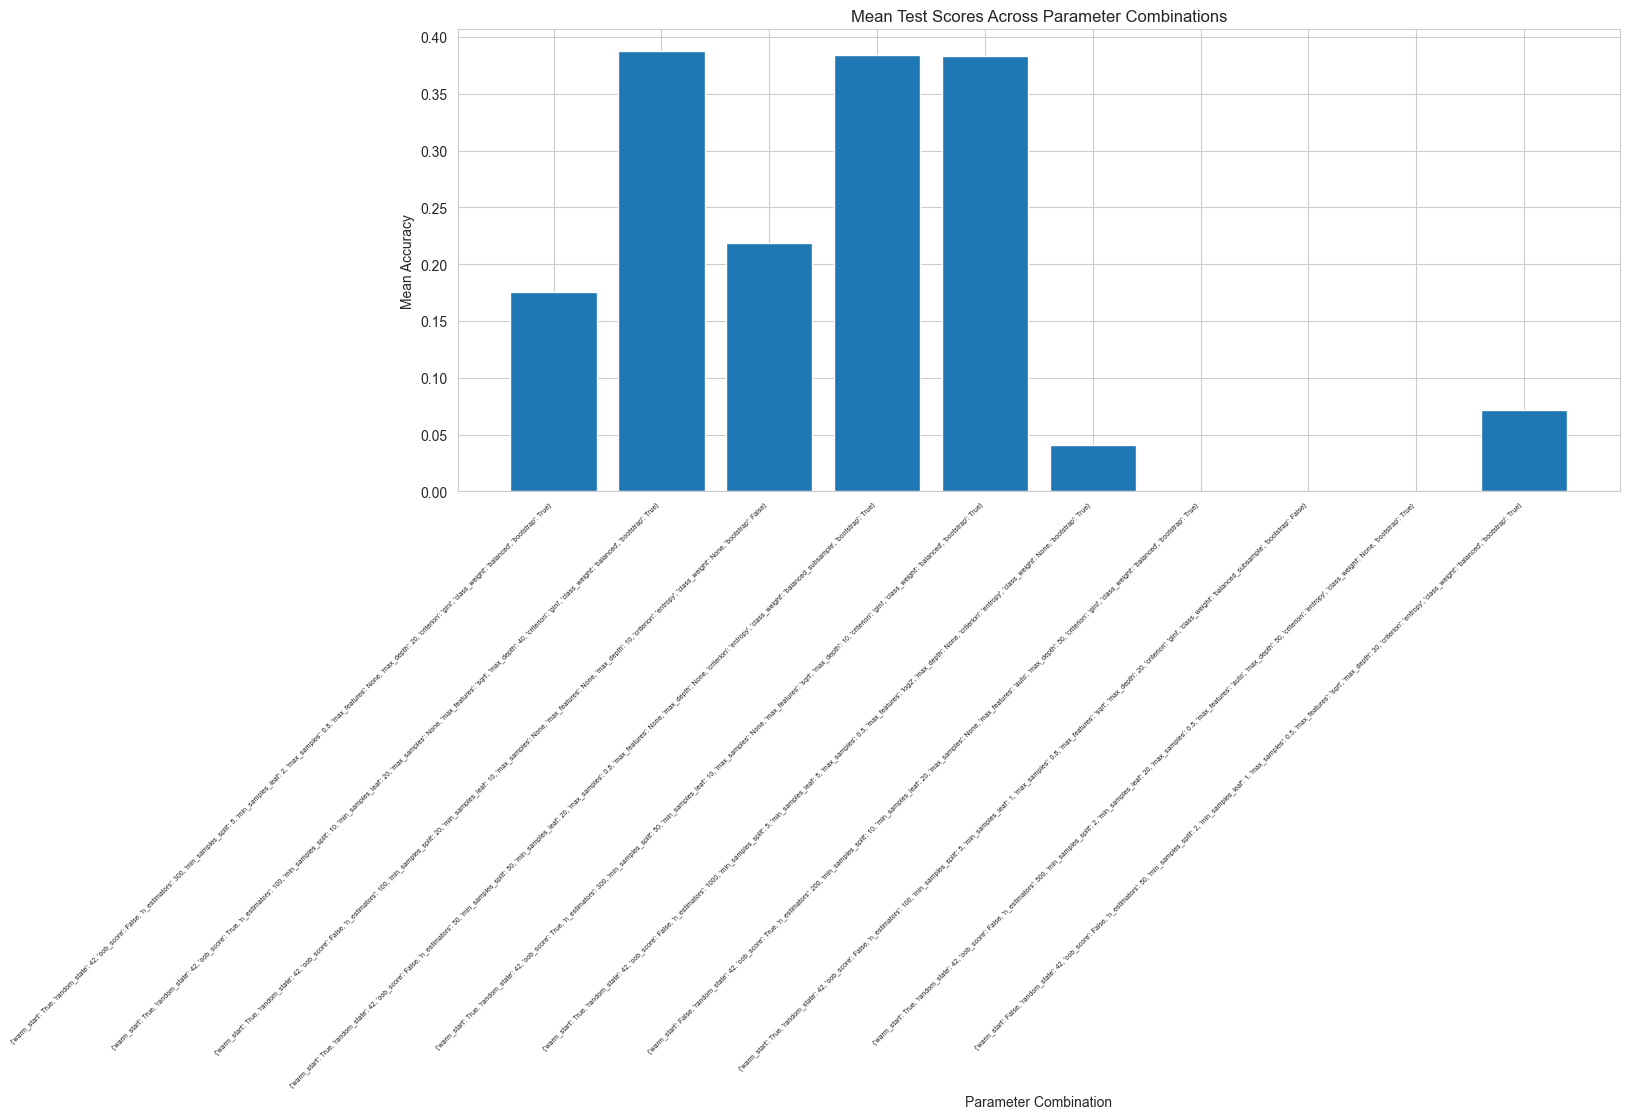

In [63]:
# define a parameter grid to tune the hyperparameters of the model
param_grid_rf = {
    "n_estimators": [50, 100, 200, 300, 500, 1000],  # Number of trees in the forest
    "max_depth": [None, 10, 20, 30, 40, 50, 100],  # Maximum depth of the tree
    "min_samples_split": [2, 5, 10, 20, 50],  # Minimum number of samples required to split an internal node
    "min_samples_leaf": [1, 2, 5, 10, 20],  # Minimum number of samples required to be at a leaf node
    "max_features": ["auto", "sqrt", "log2", None],  # Number of features to consider for the best split
    "bootstrap": [True, False],  # Whether bootstrap samples are used when building trees
    "oob_score": [True, False],  # Whether to use out-of-bag samples to estimate the generalization accuracy
    "max_samples": [None, 0.5, 0.8],  # The number of samples to use for fitting
    "class_weight": [None, "balanced", "balanced_subsample"],  # Weighting of classes in the dataset
    "criterion": ["gini", "entropy"],  # The function to measure the quality of a split
    "warm_start": [True, False],  # Whether to reuse the solution of the previous call to fit and add more estimators
    "random_state": [42]  # Random state for reproducibility
}

model_optimizer(rf, X_train, y_train, X_test, y_test,"under", param_grid_rf)
model_optimizer(rf, X_train, y_train, X_test, y_test,"over", param_grid_rf)
model_optimizer(rf, X_train, y_train, X_test, y_test,"smote", param_grid_rf)
model_optimizer(rf, X_train, y_train, X_test, y_test,"train", param_grid_rf)

## Run optimized models

Test Set Performance:
Confusion Matrix (Test):
[[494 231]
 [ 53  70]]

Accuracy of Model (Test): 66.50943396226415 

              precision    recall  f1-score   support

           0       0.90      0.68      0.78       725
           1       0.23      0.57      0.33       123

    accuracy                           0.67       848
   macro avg       0.57      0.63      0.55       848
weighted avg       0.81      0.67      0.71       848



c:\Users\joell\anaconda3\envs\DTH\Lib\site-packages\sklearn\ensemble\_forest.py:861: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn(


Test Set Performance:
Confusion Matrix (Test):
[[673  52]
 [103  20]]

Accuracy of Model (Test): 81.72169811320755 

              precision    recall  f1-score   support

           0       0.87      0.93      0.90       725
           1       0.28      0.16      0.21       123

    accuracy                           0.82       848
   macro avg       0.57      0.55      0.55       848
weighted avg       0.78      0.82      0.80       848

Test Set Performance:
Confusion Matrix (Test):
[[633  92]
 [ 94  29]]

Accuracy of Model (Test): 78.06603773584906 

              precision    recall  f1-score   support

           0       0.87      0.87      0.87       725
           1       0.24      0.24      0.24       123

    accuracy                           0.78       848
   macro avg       0.56      0.55      0.55       848
weighted avg       0.78      0.78      0.78       848

Test Set Performance:
Confusion Matrix (Test):
[[719   6]
 [117   6]]

Accuracy of Model (Test): 85.495283018867

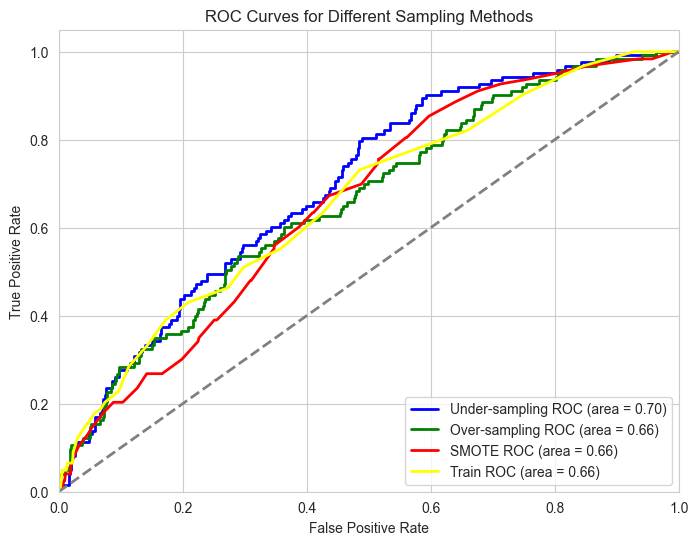

In [64]:
# create an instance of the model with the optimized hyperparameters
rf_under = RandomForestClassifier(warm_start= True, oob_score= False,n_estimators= 1000, min_samples_split= 5,min_samples_leaf= 5, max_samples= 0.5, max_features= 'log2', max_depth= None, criterion= 'entropy', class_weight= None, bootstrap= True, random_state= 42)
rf_over = RandomForestClassifier(warm_start= True, oob_score= False, n_estimators= 300, min_samples_split= 5, min_samples_leaf= 2, max_samples= 0.8, max_features= None, max_depth= 20, criterion= 'gini', class_weight= 'balanced', bootstrap= True, random_state= 42)
rf_smote = RandomForestClassifier(warm_start= False, oob_score= False, n_estimators= 50, min_samples_split= 2, min_samples_leaf= 1, max_samples= 0.5, max_features= "sqrt", max_depth= 30, criterion= 'entropy', class_weight= 'balanced', bootstrap= True, random_state= 42)
rf_train = RandomForestClassifier(warm_start= False, oob_score= False, n_estimators= 50, min_samples_split= 2, min_samples_leaf= 1, max_samples= 0.5, max_features= "sqrt", max_depth= 30, criterion= 'entropy', class_weight= 'balanced', bootstrap= True, random_state= 42)

y_proba_rf_under_opt = run_model(rf_under, X_train, y_train, X_test, y_test, "under", "optimized model")
y_proba_rf_over_opt = run_model(rf_over, X_train, y_train, X_test, y_test, "over", "optimized model")
y_proba_rf_smote_opt = run_model(rf_smote, X_train, y_train, X_test, y_test, "smote", "optimized model")
y_proba_rf_train_opt = run_model(rf_train, X_train, y_train, X_test, y_test, "train", "optimized model")

# plot roc curves for optimized models
plot_roc_curves(y_test, y_proba_rf_under_opt, y_proba_rf_over_opt, y_proba_rf_smote_opt, y_proba_rf_train_opt)

# KNeighborsClassifier

## Base classifier without tuning

In [65]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier()
y_proba_knn_under = run_model(knn, X_train, y_train, X_test, y_test, "under", "base model")
y_proba_knn_over = run_model(knn, X_train, y_train, X_test, y_test, "over", "base model")
y_proba_knn_smote = run_model(knn, X_train, y_train, X_test, y_test, "smote", "base model")
y_proba_knn_train = run_model(knn, X_train, y_train, X_test, y_test, "train", "base model")

Test Set Performance:
Confusion Matrix (Test):
[[479 246]
 [ 58  65]]

Accuracy of Model (Test): 64.15094339622641 

              precision    recall  f1-score   support

           0       0.89      0.66      0.76       725
           1       0.21      0.53      0.30       123

    accuracy                           0.64       848
   macro avg       0.55      0.59      0.53       848
weighted avg       0.79      0.64      0.69       848

Test Set Performance:
Confusion Matrix (Test):
[[523 202]
 [ 76  47]]

Accuracy of Model (Test): 67.21698113207547 

              precision    recall  f1-score   support

           0       0.87      0.72      0.79       725
           1       0.19      0.38      0.25       123

    accuracy                           0.67       848
   macro avg       0.53      0.55      0.52       848
weighted avg       0.77      0.67      0.71       848

Test Set Performance:
Confusion Matrix (Test):
[[504 221]
 [ 69  54]]

Accuracy of Model (Test): 65.801886792452

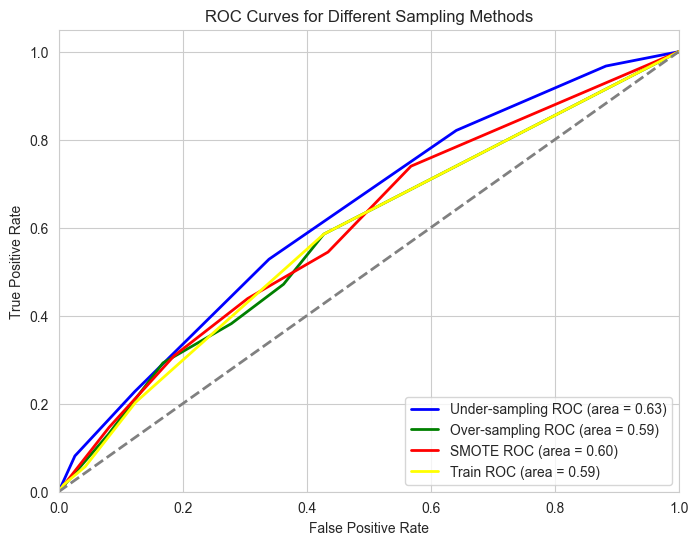

In [66]:
# plot roc curves of all base models
plot_roc_curves(y_test, y_proba_knn_under, y_proba_knn_over, y_proba_knn_smote, y_proba_knn_train)

## Optimization parameter for all 3 sampling techniques

Sampling Method: under
Best parameters found: {'weights': 'uniform', 'p': 2, 'n_neighbors': 7, 'n_jobs': -1, 'metric': 'euclidean', 'leaf_size': 30, 'algorithm': 'ball_tree'}
Best score: 0.5945691916234553


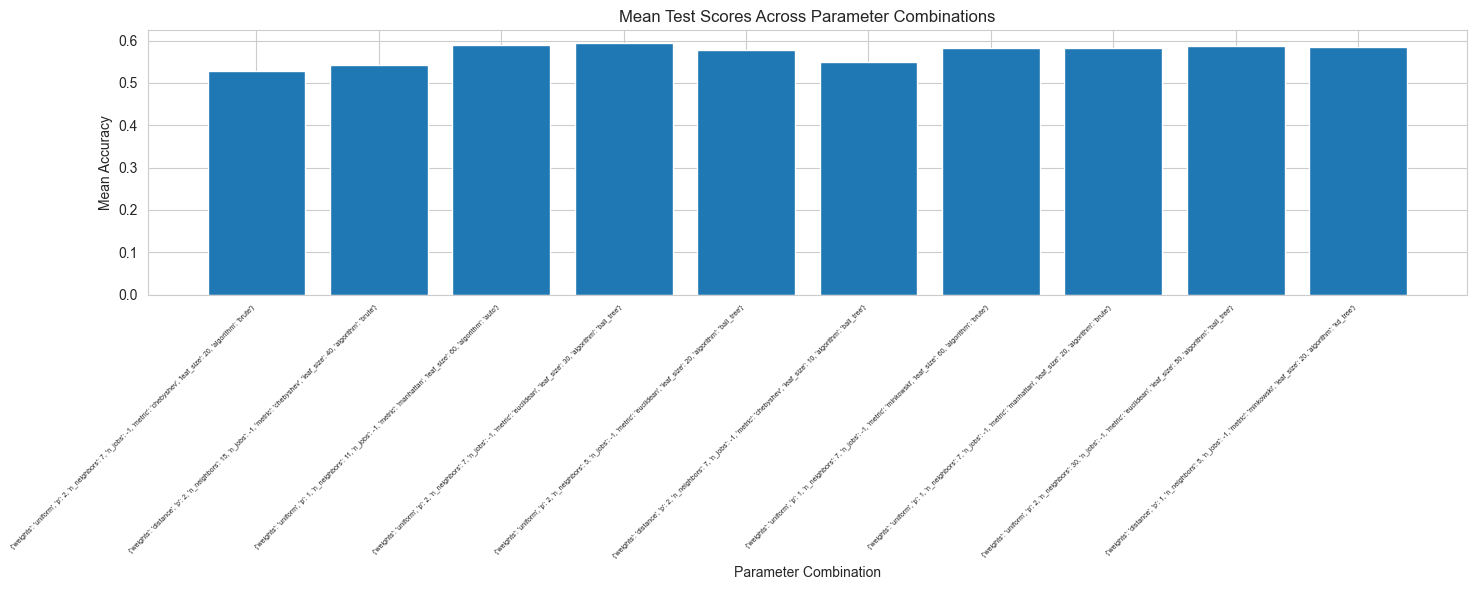

Sampling Method: over
Best parameters found: {'weights': 'distance', 'p': 2, 'n_neighbors': 15, 'n_jobs': -1, 'metric': 'chebyshev', 'leaf_size': 40, 'algorithm': 'brute'}
Best score: 0.8521218268507174


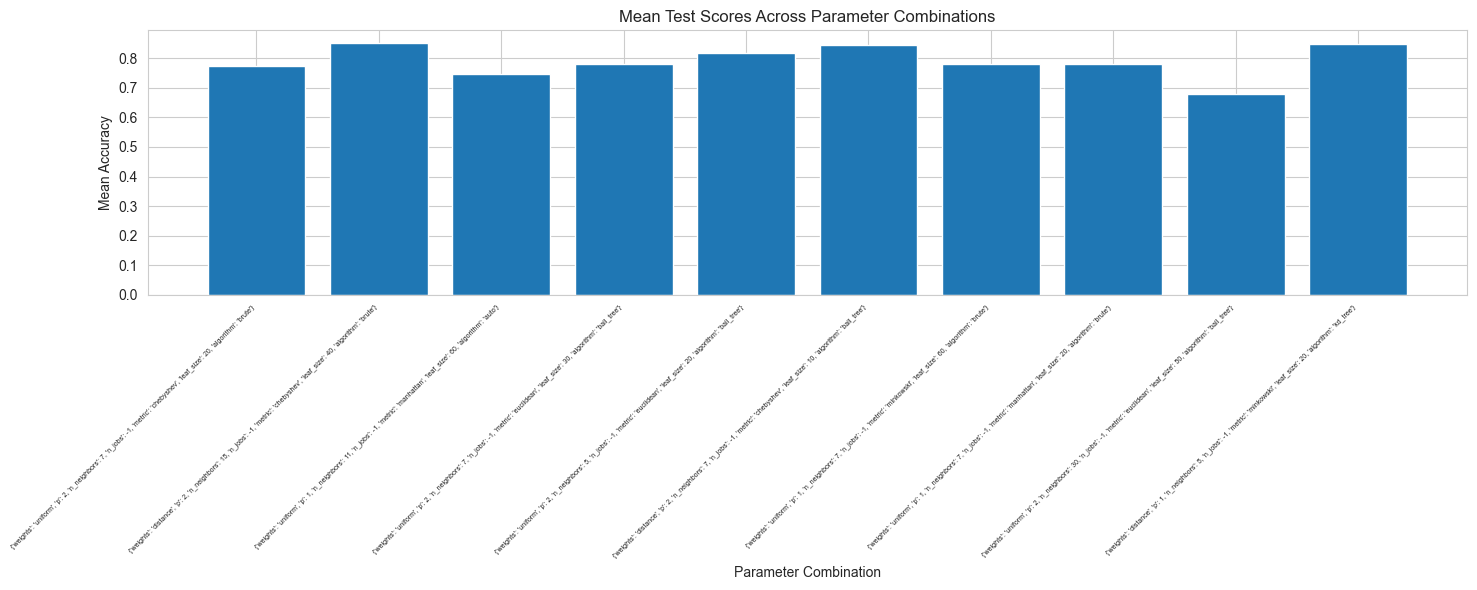

Sampling Method: smote
Best parameters found: {'weights': 'distance', 'p': 1, 'n_neighbors': 5, 'n_jobs': -1, 'metric': 'minkowski', 'leaf_size': 20, 'algorithm': 'kd_tree'}
Best score: 0.8428240366064852


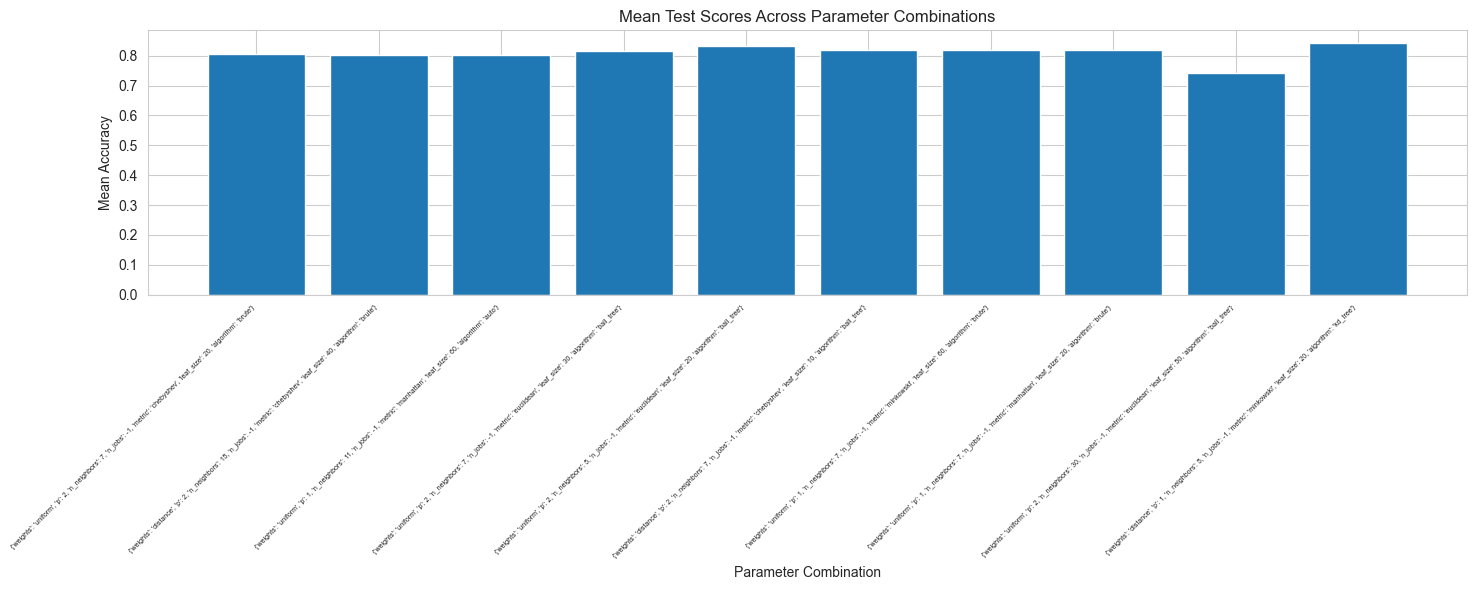

Sampling Method: train
Best parameters found: {'weights': 'uniform', 'p': 2, 'n_neighbors': 5, 'n_jobs': -1, 'metric': 'euclidean', 'leaf_size': 20, 'algorithm': 'ball_tree'}
Best score: 0.17303880300015306


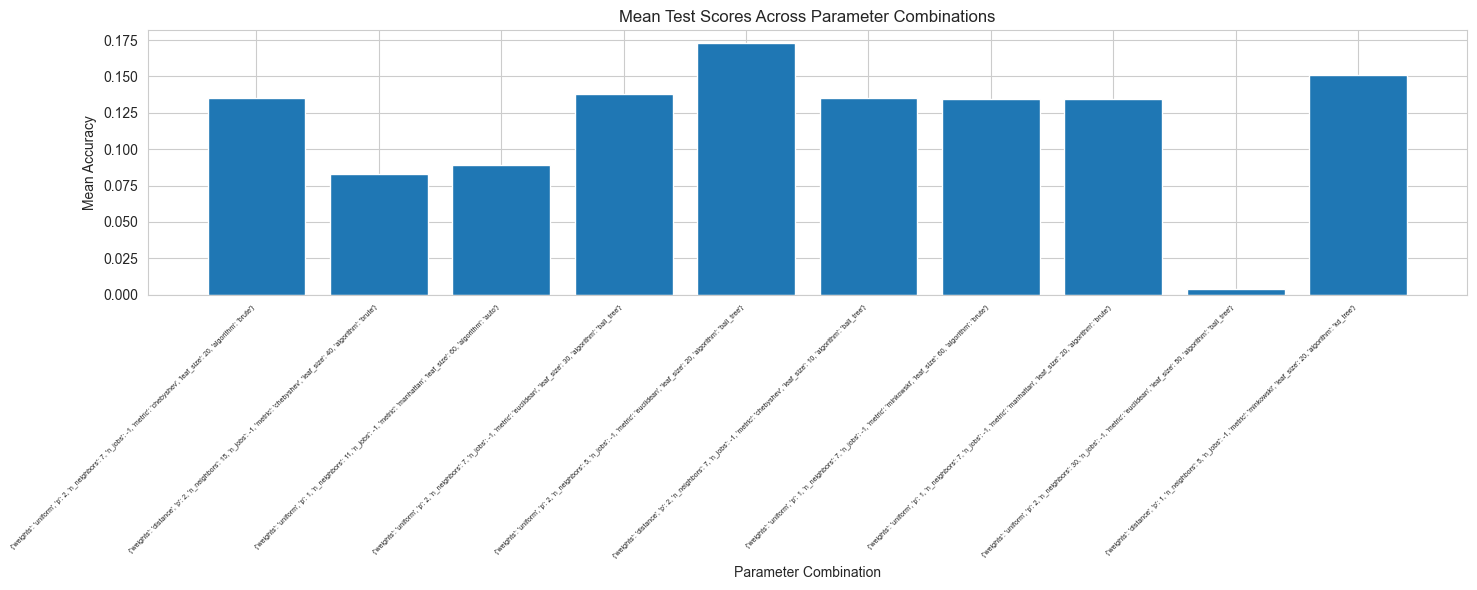

In [67]:
param_grid_knn = {
    "n_neighbors": [1, 3, 5, 7, 9, 11, 15, 20, 25, 30],  # Number of neighbors to use
    "weights": ["uniform", "distance"],  # Weight function used in prediction
    "algorithm": ["auto", "ball_tree", "kd_tree", "brute"],  # Algorithm used to compute nearest neighbors
    "leaf_size": [10, 20, 30, 40, 50, 60],  # Leaf size passed to BallTree or KDTree
    "p": [1, 2],  # Power parameter for the Minkowski metric (1=Manhattan, 2=Euclidean)
    "metric": ["euclidean", "manhattan", "minkowski", "chebyshev"],  # Distance metric to use
    "n_jobs": [-1],  # Number of parallel jobs to run (use -1 for all processors)
}
model_optimizer(knn, X_train, y_train, X_test, y_test,"under", param_grid_knn)
model_optimizer(knn, X_train, y_train, X_test, y_test,"over", param_grid_knn)
model_optimizer(knn, X_train, y_train, X_test, y_test,"smote", param_grid_knn)
model_optimizer(knn, X_train, y_train, X_test, y_test,"train", param_grid_knn)


## Run optimized models

Test Set Performance:
Confusion Matrix (Test):
[[509 216]
 [ 51  72]]

Accuracy of Model (Test): 68.51415094339622 

              precision    recall  f1-score   support

           0       0.91      0.70      0.79       725
           1       0.25      0.59      0.35       123

    accuracy                           0.69       848
   macro avg       0.58      0.64      0.57       848
weighted avg       0.81      0.69      0.73       848

Test Set Performance:
Confusion Matrix (Test):
[[511 214]
 [ 63  60]]

Accuracy of Model (Test): 67.33490566037736 

              precision    recall  f1-score   support

           0       0.89      0.70      0.79       725
           1       0.22      0.49      0.30       123

    accuracy                           0.67       848
   macro avg       0.55      0.60      0.54       848
weighted avg       0.79      0.67      0.72       848

Test Set Performance:
Confusion Matrix (Test):
[[509 216]
 [ 67  56]]

Accuracy of Model (Test): 66.627358490566

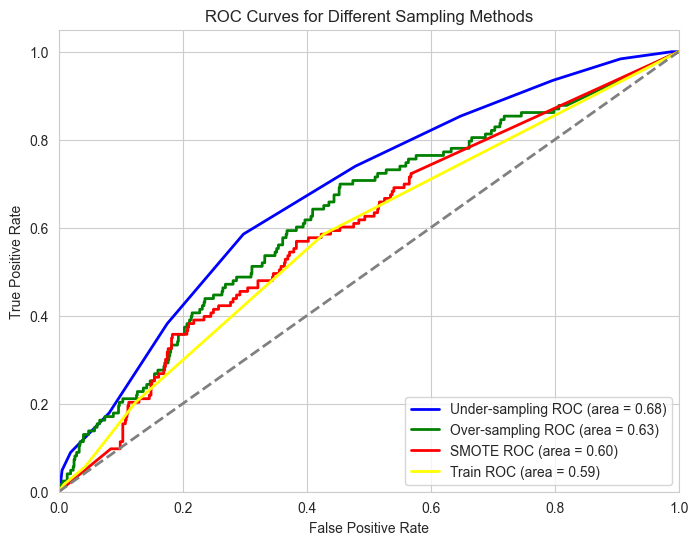

In [68]:
# create an instance of the model with the optimized hyperparameters
knn_under = KNeighborsClassifier(n_neighbors= 11, weights= 'uniform', p= 1, n_jobs= -1, metric= 'manhattan', leaf_size= 60, algorithm= 'auto')
knn_over = KNeighborsClassifier(n_neighbors= 15, weights= 'distance', p= 2, n_jobs= -1, metric= 'chebyshev', leaf_size= 40, algorithm= 'brute')
knn_smote = KNeighborsClassifier(n_neighbors= 5, weights= 'distance', p= 1, n_jobs= -1, metric= 'minkowski', leaf_size= 20, algorithm= 'kd_tree')
knn_train = KNeighborsClassifier(n_neighbors= 5, weights= 'uniform', p= 2, n_jobs= -1, metric= 'euclidean', leaf_size= 20, algorithm= 'ball_tree')

y_proba_knn_under_opt = run_model(knn_under, X_train, y_train, X_test, y_test, "under", "optimized model")
y_proba_knn_over_opt = run_model(knn_over, X_train, y_train, X_test, y_test, "over", "optimized model")
y_proba_knn_smote_opt = run_model(knn_smote, X_train, y_train, X_test, y_test, "smote", "optimized model")
y_proba_knn_train_opt = run_model(knn_train, X_train, y_train, X_test, y_test, "train", "optimized model")

# plot roc curves for optimized models
plot_roc_curves(y_test, y_proba_knn_under_opt, y_proba_knn_over_opt, y_proba_knn_smote_opt, y_proba_knn_train_opt)

# Extreme Gradient Boost

## Base classifier without tuning

In [69]:
from xgboost import XGBClassifier

xgb = XGBClassifier()
y_proba_xgb_under = run_model(xgb, X_train, y_train, X_test, y_test, "under", "base model")
y_proba_xgb_over = run_model(xgb, X_train, y_train, X_test, y_test, "over", "base model")
y_proba_xgb_smote = run_model(xgb, X_train, y_train, X_test, y_test, "smote", "base model")
y_proba_xgb_train = run_model(xgb, X_train, y_train, X_test, y_test, "train", "base model")

Test Set Performance:
Confusion Matrix (Test):
[[455 270]
 [ 49  74]]

Accuracy of Model (Test): 62.382075471698116 

              precision    recall  f1-score   support

           0       0.90      0.63      0.74       725
           1       0.22      0.60      0.32       123

    accuracy                           0.62       848
   macro avg       0.56      0.61      0.53       848
weighted avg       0.80      0.62      0.68       848

Test Set Performance:
Confusion Matrix (Test):
[[653  72]
 [ 97  26]]

Accuracy of Model (Test): 80.07075471698113 

              precision    recall  f1-score   support

           0       0.87      0.90      0.89       725
           1       0.27      0.21      0.24       123

    accuracy                           0.80       848
   macro avg       0.57      0.56      0.56       848
weighted avg       0.78      0.80      0.79       848

Test Set Performance:
Confusion Matrix (Test):
[[679  46]
 [111  12]]

Accuracy of Model (Test): 81.48584905660

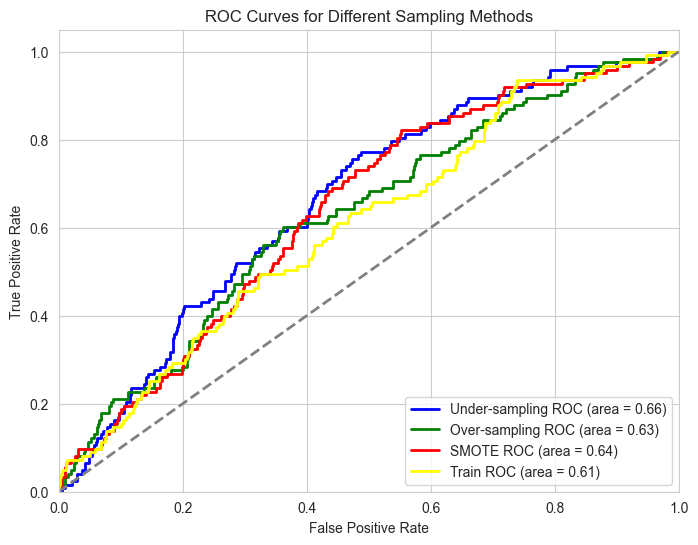

In [70]:
# plot roc curves of all base models
plot_roc_curves(y_test, y_proba_xgb_under, y_proba_xgb_over, y_proba_xgb_smote, y_proba_xgb_train)

## Optimization parameter for all 3 sampling techniques

Sampling Method: under
Best parameters found: {'tree_method': 'exact', 'subsample': 0.5, 'scale_pos_weight': 10, 'reg_lambda': 10, 'reg_alpha': 0.01, 'random_state': 42, 'objective': 'reg:squarederror', 'n_estimators': 100, 'min_child_weight': 7, 'max_depth': 5, 'learning_rate': 0.1, 'gamma': 1.0, 'colsample_bytree': 0.9, 'colsample_bylevel': 0.5, 'booster': 'dart'}
Best score: 0.6804528025710785


C:\Users\joell\AppData\Local\Temp\ipykernel_41296\340764079.py:64: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


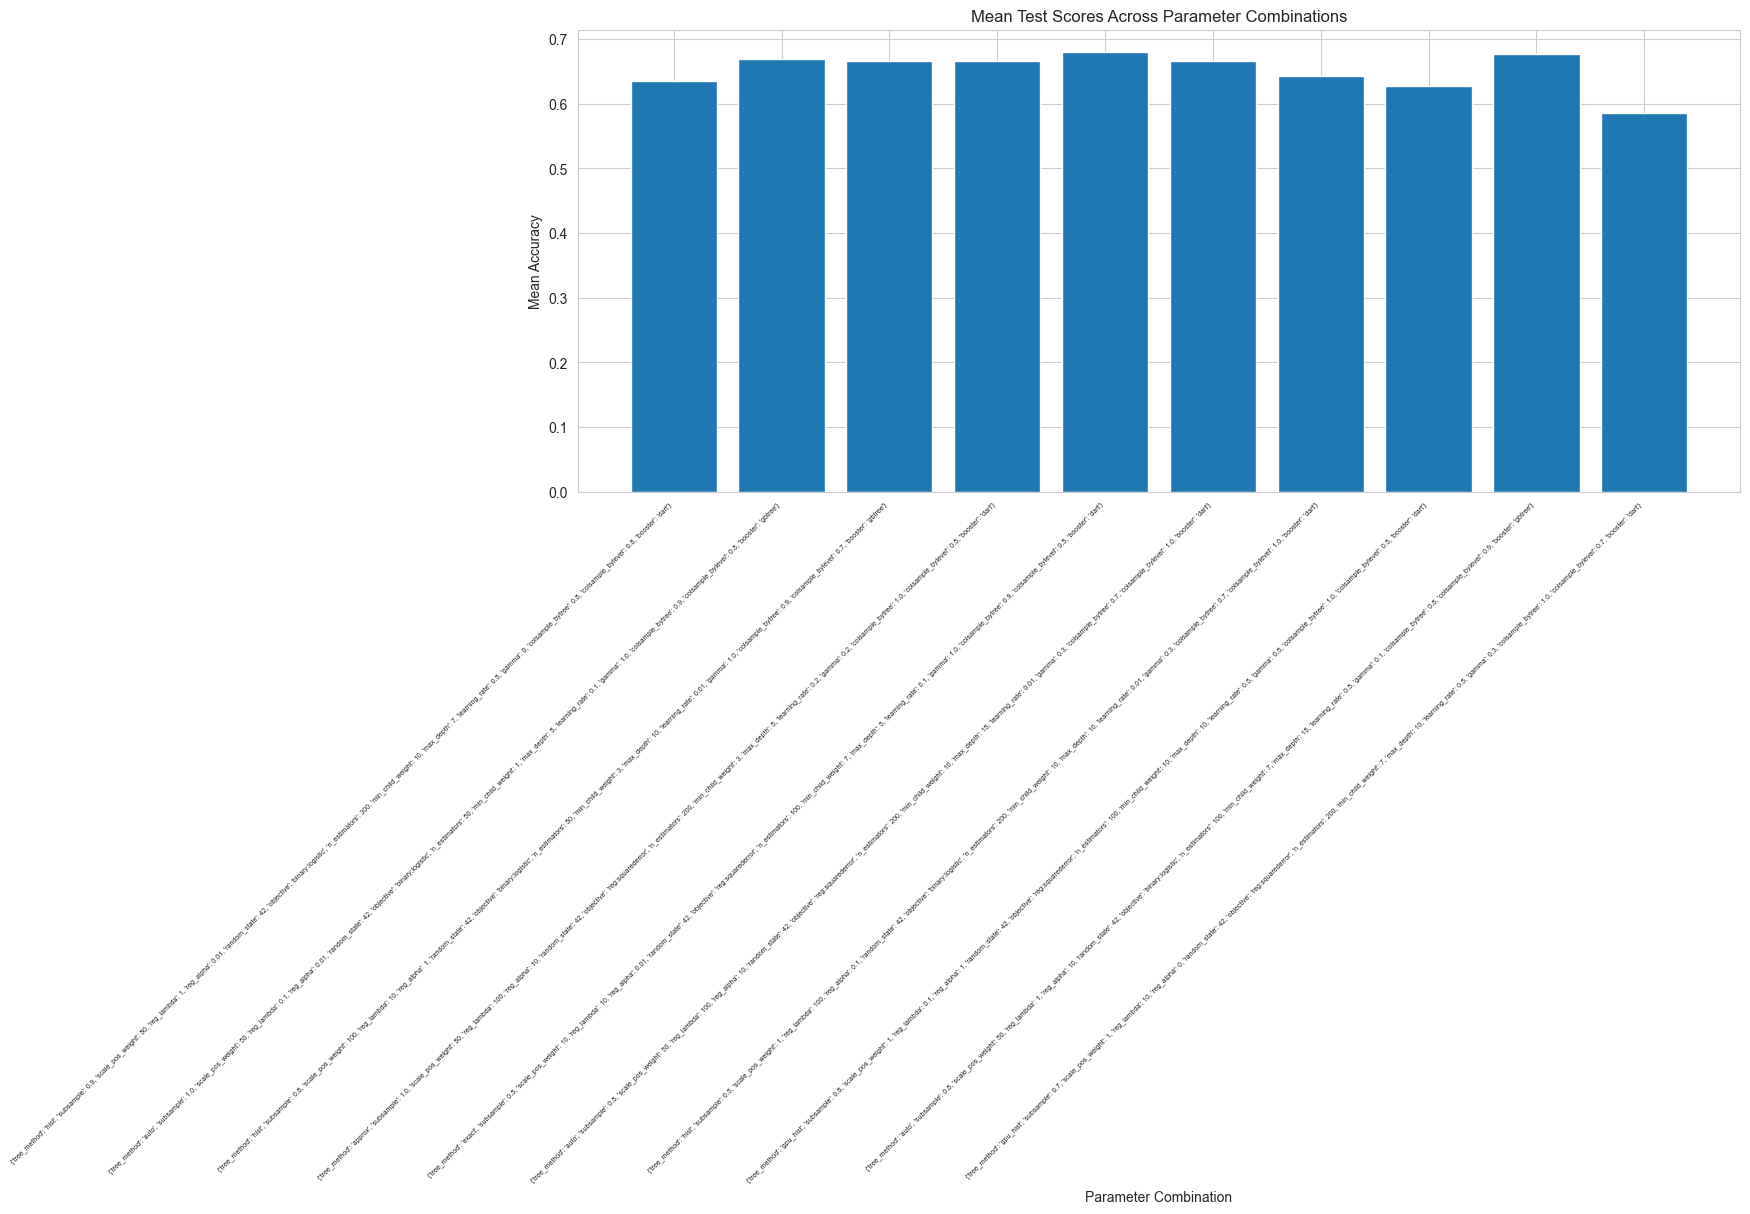

Sampling Method: over
Best parameters found: {'tree_method': 'hist', 'subsample': 0.9, 'scale_pos_weight': 50, 'reg_lambda': 1, 'reg_alpha': 0.01, 'random_state': 42, 'objective': 'binary:logistic', 'n_estimators': 300, 'min_child_weight': 10, 'max_depth': 7, 'learning_rate': 0.5, 'gamma': 0, 'colsample_bytree': 0.8, 'colsample_bylevel': 0.8, 'booster': 'dart'}
Best score: 0.8937771630930087


C:\Users\joell\AppData\Local\Temp\ipykernel_41296\340764079.py:64: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


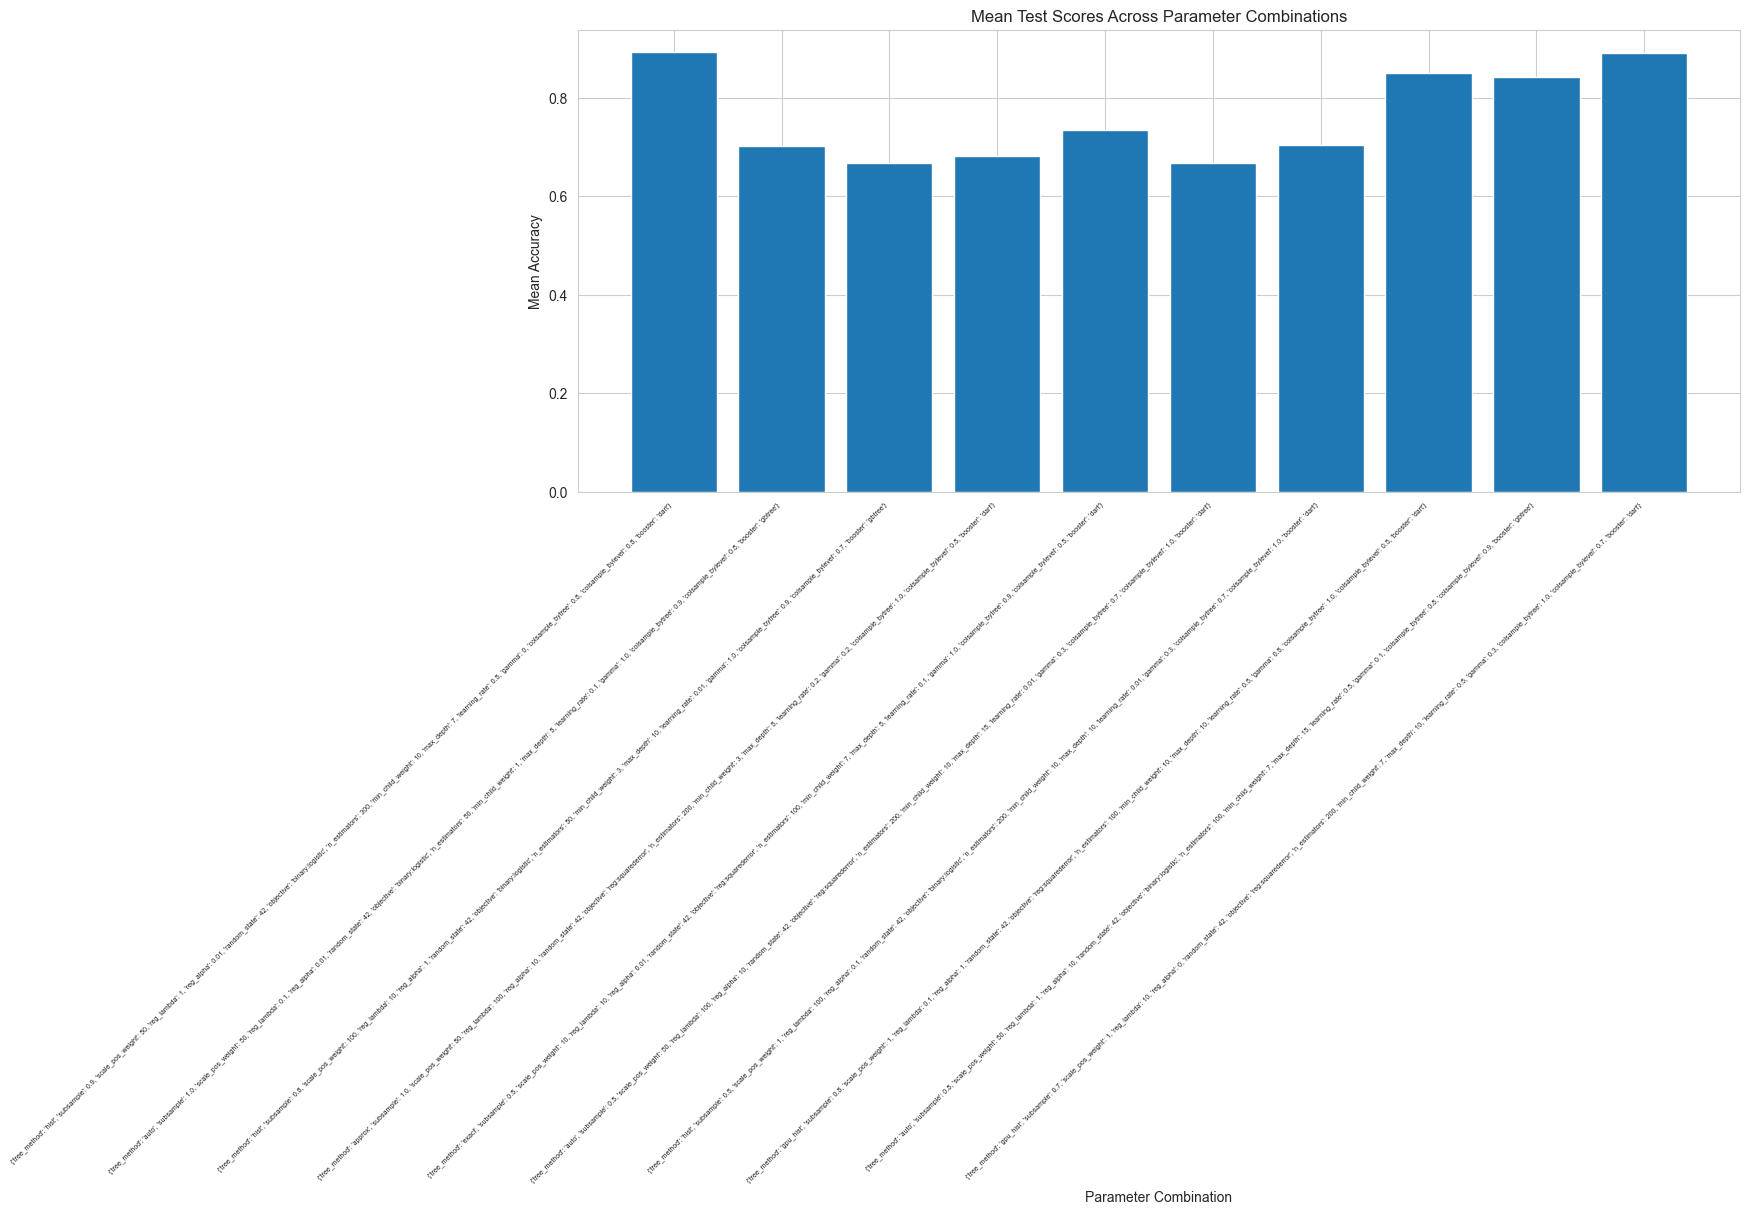

Sampling Method: smote
Best parameters found: {'tree_method': 'hist', 'subsample': 0.9, 'scale_pos_weight': 50, 'reg_lambda': 1, 'reg_alpha': 0.01, 'random_state': 42, 'objective': 'binary:logistic', 'n_estimators': 300, 'min_child_weight': 10, 'max_depth': 7, 'learning_rate': 0.5, 'gamma': 0, 'colsample_bytree': 0.8, 'colsample_bylevel': 0.8, 'booster': 'dart'}
Best score: 0.8190781961039061


C:\Users\joell\AppData\Local\Temp\ipykernel_41296\340764079.py:64: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


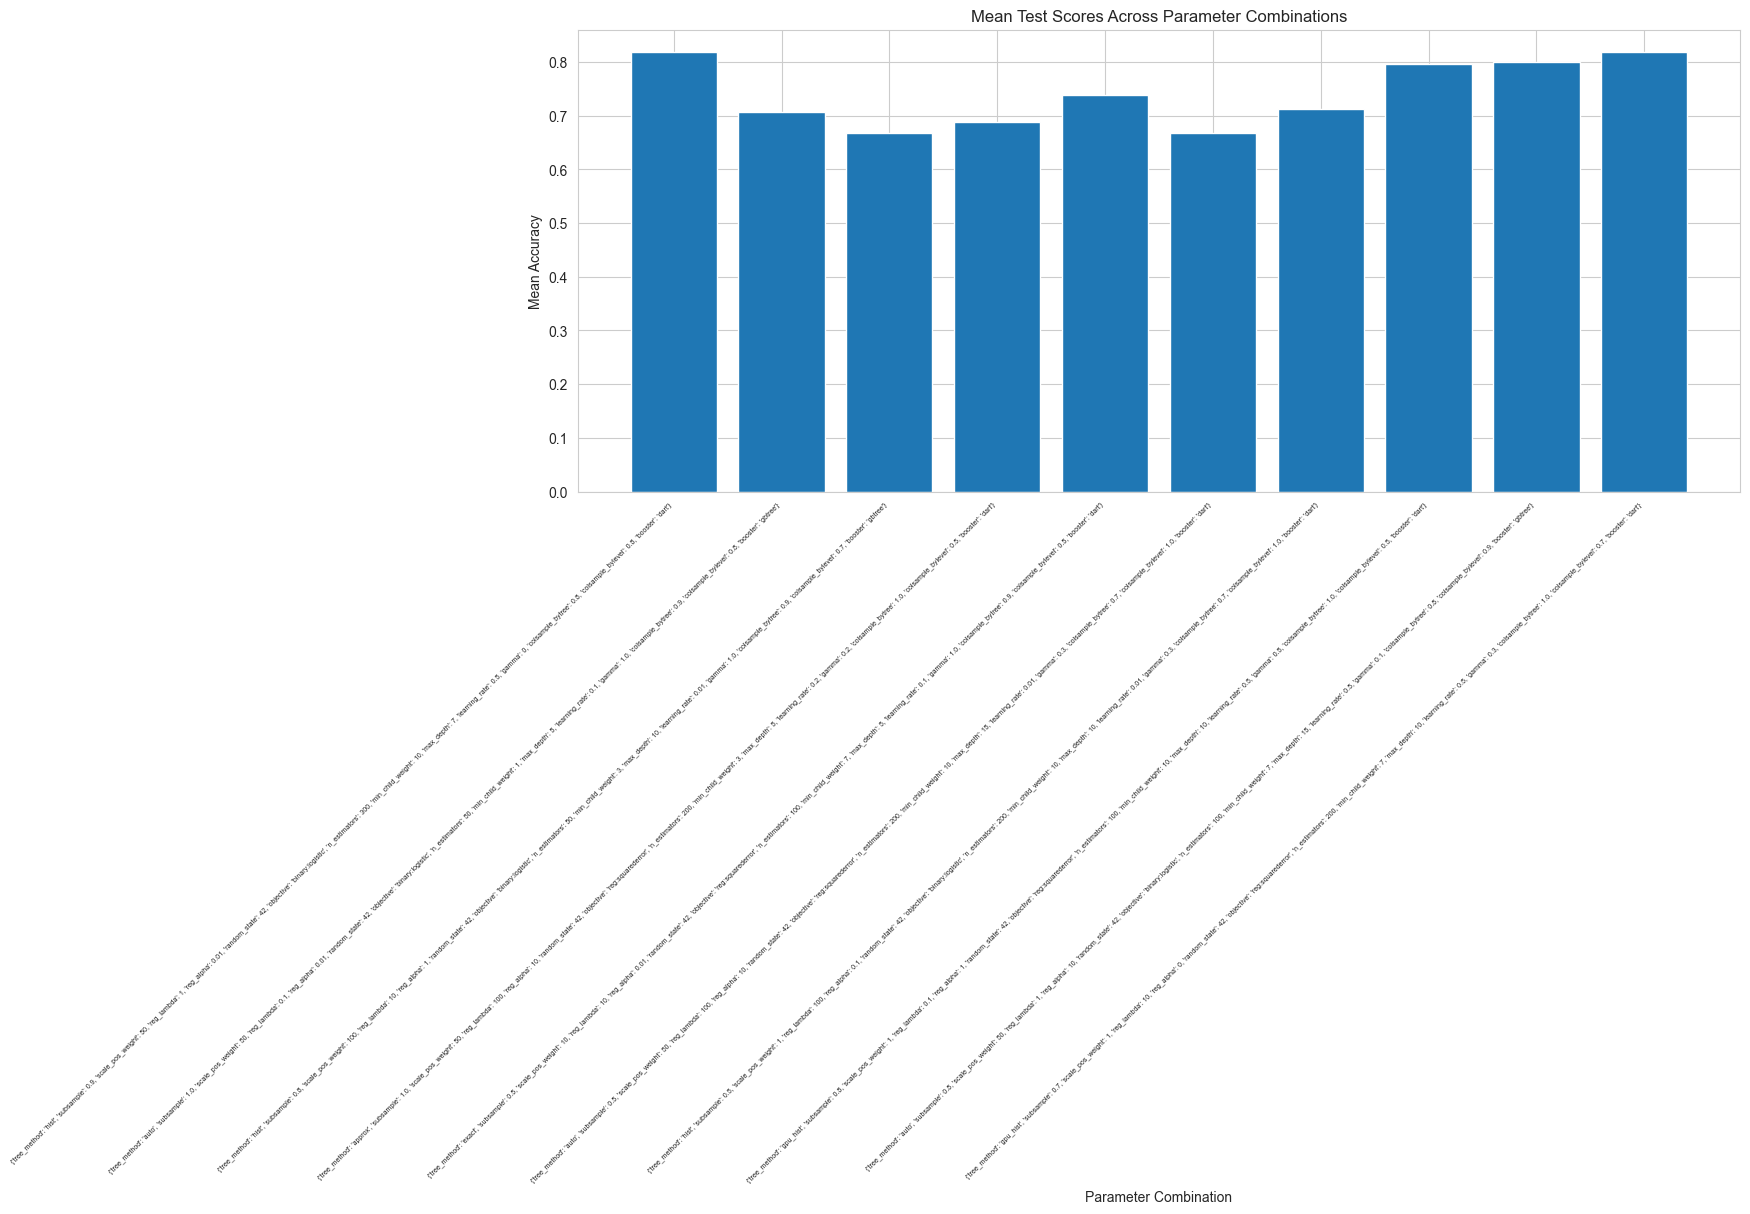

Sampling Method: train
Best parameters found: {'tree_method': 'exact', 'subsample': 0.5, 'scale_pos_weight': 10, 'reg_lambda': 10, 'reg_alpha': 0.01, 'random_state': 42, 'objective': 'reg:squarederror', 'n_estimators': 100, 'min_child_weight': 7, 'max_depth': 5, 'learning_rate': 0.1, 'gamma': 1.0, 'colsample_bytree': 0.9, 'colsample_bylevel': 0.5, 'booster': 'dart'}
Best score: 0.3297050195476915


C:\Users\joell\AppData\Local\Temp\ipykernel_41296\340764079.py:64: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


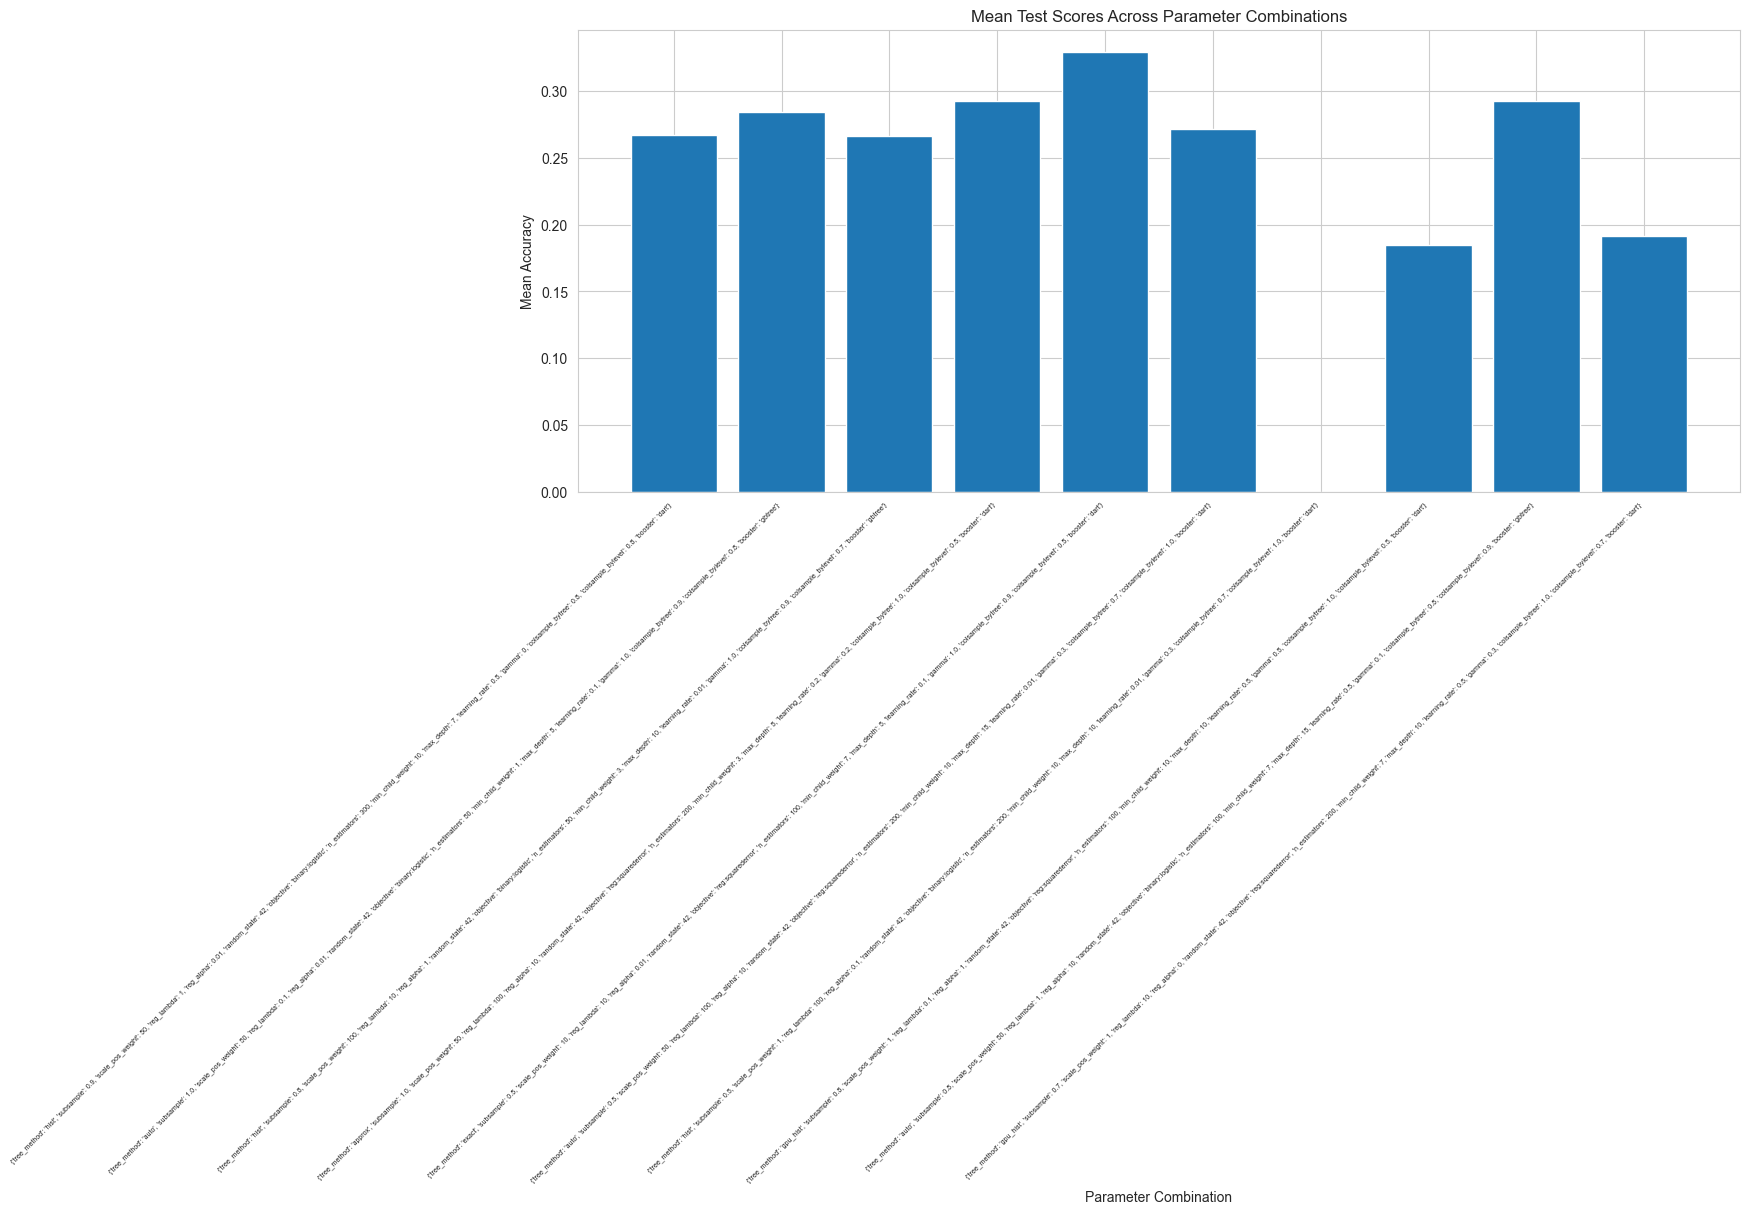

In [71]:
param_grid_xgb = {
    "n_estimators": [50, 100, 200, 300],  # Including values from results
    "learning_rate": [0.01, 0.1, 0.2, 0.5],  # From suggestions and results
    "max_depth": [3, 5, 7, 10, 15, 20],  # Incorporates observed values
    "min_child_weight": [1, 3, 5, 7, 10],  # Observed and suggested
    "subsample": [0.5, 0.7, 0.8, 0.9, 1.0],  # Suggestions and results
    "colsample_bytree": [0.5, 0.7, 0.8, 0.9, 1.0],  # Observed and extended
    "colsample_bylevel": [0.5, 0.7, 0.8, 0.9, 1.0],  # Include observed values
    "gamma": [0, 0.1, 0.2, 0.3, 0.5, 1.0],  # Suggested and results
    "reg_alpha": [0, 0.01, 0.1, 1, 10],  # Suggestions and results
    "reg_lambda": [0.1, 1, 10, 100],  # Suggestions and results
    "scale_pos_weight": [1, 10, 25, 50, 100],  # Observed and suggested
    "objective": ["binary:logistic", "reg:squarederror"],  # Observed objectives
    "booster": ["gbtree", "dart"],  # Observed and suggested
    "tree_method": ["auto", "exact", "approx", "hist", "gpu_hist"],  # Include observed
    "random_state": [42]  # Fixed for reproducibility
}


model_optimizer(xgb, X_train, y_train, X_test, y_test,"under", param_grid_xgb)
model_optimizer(xgb, X_train, y_train, X_test, y_test,"over", param_grid_xgb)
model_optimizer(xgb, X_train, y_train, X_test, y_test,"smote", param_grid_xgb)
model_optimizer(xgb, X_train, y_train, X_test, y_test,"train", param_grid_xgb)


## Run optimized models

Test Set Performance:
Confusion Matrix (Test):
[[  3 722]
 [  0 123]]

Accuracy of Model (Test): 14.858490566037736 

              precision    recall  f1-score   support

           0       1.00      0.00      0.01       725
           1       0.15      1.00      0.25       123

    accuracy                           0.15       848
   macro avg       0.57      0.50      0.13       848
weighted avg       0.88      0.15      0.04       848

Test Set Performance:
Confusion Matrix (Test):
[[659  66]
 [107  16]]

Accuracy of Model (Test): 79.59905660377359 

              precision    recall  f1-score   support

           0       0.86      0.91      0.88       725
           1       0.20      0.13      0.16       123

    accuracy                           0.80       848
   macro avg       0.53      0.52      0.52       848
weighted avg       0.76      0.80      0.78       848

Test Set Performance:
Confusion Matrix (Test):
[[593 132]
 [ 86  37]]

Accuracy of Model (Test): 74.29245283018

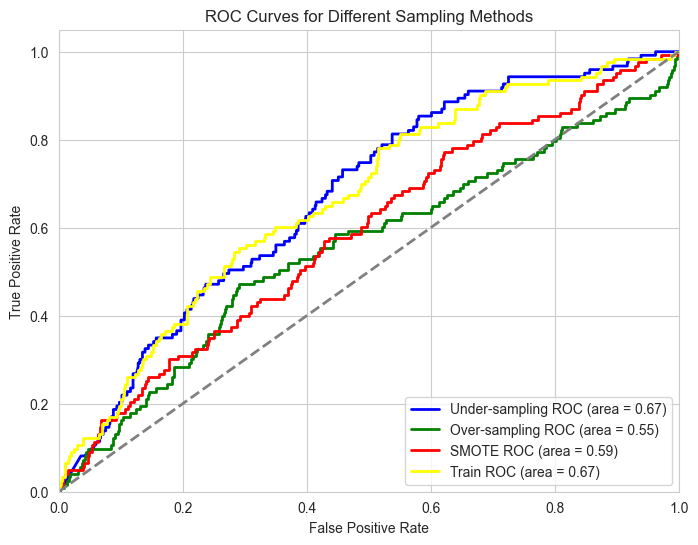

In [72]:
# create an instance of the model with the optimized hyperparameters
xgb_under = XGBClassifier(tree_method= 'auto', subsample= 0.9, scale_pos_weight= 25, reg_lambda= 0.1, reg_alpha= 10, random_state= 42, objective= 'binary:logistic', n_estimators= 200, min_child_weight= 7, max_depth= 5, learning_rate= 0.01, gamma= 0.5, colsample_bytree= 0.9, colsample_bylevel= 1.0, booster= 'dart')
xgb_over = XGBClassifier(tree_method= 'auto', subsample= 0.8, scale_pos_weight= 100, reg_lambda= 10, reg_alpha= 0.01, random_state= 42, objective= 'reg:squarederror', n_estimators= 200, min_child_weight= 7, max_depth= 20, learning_rate= 0.5, gamma= 0, colsample_bytree= 1.0, colsample_bylevel= 1.0, booster= 'dart')
xgb_smote = XGBClassifier(tree_method= 'auto', subsample= 0.8, scale_pos_weight= 100, reg_lambda= 10, reg_alpha= 0.01, random_state= 42, objective= 'reg:squarederror', n_estimators= 200, min_child_weight= 7, max_depth= 20, learning_rate= 0.5, gamma= 0, colsample_bytree= 1.0, colsample_bylevel= 1.0, booster= 'dart')
xgb_train = XGBClassifier(tree_method= 'exact', subsample= 0.5, scale_pos_weight= 10, reg_lambda= 10, reg_alpha= 0.001, random_state= 42, objective= 'reg:squarederror', n_estimators= 100, min_child_weight= 7, max_depth= 5, learning_rate= 0.1, gamma= 1.0, colsample_bytree= 0.9, colsample_bylevel= 0.5, booster= 'dart')

y_proba_xgb_under_opt = run_model(xgb_under, X_train, y_train, X_test, y_test, "under", "optimized model")
y_proba_xgb_over_opt = run_model(xgb_over, X_train, y_train, X_test, y_test, "over", "optimized model")
y_proba_xgb_smote_opt = run_model(xgb_smote, X_train, y_train, X_test, y_test, "smote", "optimized model")
y_proba_xgb_train_opt = run_model(xgb_train, X_train, y_train, X_test, y_test, "train", "optimized model")

# plot roc curves for optimized models
plot_roc_curves(y_test, y_proba_xgb_under_opt, y_proba_xgb_over_opt, y_proba_xgb_smote_opt, y_proba_xgb_train_opt)

# Support Vector Machines

## Base classifier without tuning

In [73]:
from sklearn.svm import SVC

svc = SVC(probability=True, random_state=42)
y_proba_svc_under = run_model(svc, X_train, y_train, X_test, y_test, "under", "base model")
y_proba_svc_over = run_model(svc, X_train, y_train, X_test, y_test, "over", "base model")
y_proba_svc_smote = run_model(svc, X_train, y_train, X_test, y_test, "smote", "base model")
y_proba_svc_train = run_model(svc, X_train, y_train, X_test, y_test, "train", "base model")

Test Set Performance:
Confusion Matrix (Test):
[[515 210]
 [ 58  65]]

Accuracy of Model (Test): 68.39622641509435 

              precision    recall  f1-score   support

           0       0.90      0.71      0.79       725
           1       0.24      0.53      0.33       123

    accuracy                           0.68       848
   macro avg       0.57      0.62      0.56       848
weighted avg       0.80      0.68      0.73       848

Test Set Performance:
Confusion Matrix (Test):
[[521 204]
 [ 60  63]]

Accuracy of Model (Test): 68.86792452830188 

              precision    recall  f1-score   support

           0       0.90      0.72      0.80       725
           1       0.24      0.51      0.32       123

    accuracy                           0.69       848
   macro avg       0.57      0.62      0.56       848
weighted avg       0.80      0.69      0.73       848

Test Set Performance:
Confusion Matrix (Test):
[[520 205]
 [ 73  50]]

Accuracy of Model (Test): 67.216981132075

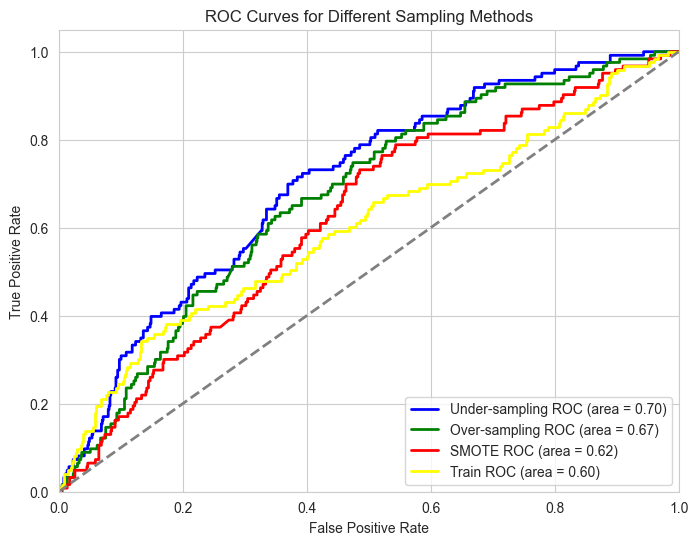

In [74]:
# plot roc curves of all base models
plot_roc_curves(y_test, y_proba_svc_under, y_proba_svc_over, y_proba_svc_smote, y_proba_svc_train)

## Optimization parameter for all 3 sampling techniques

Sampling Method: under
Best parameters found: {'tol': 0.01, 'shrinking': True, 'random_state': 42, 'max_iter': 1000, 'kernel': 'rbf', 'gamma': 0.1, 'degree': 3, 'coef0': 0.0, 'class_weight': None, 'C': 0.1}
Best score: 0.6671095234874829


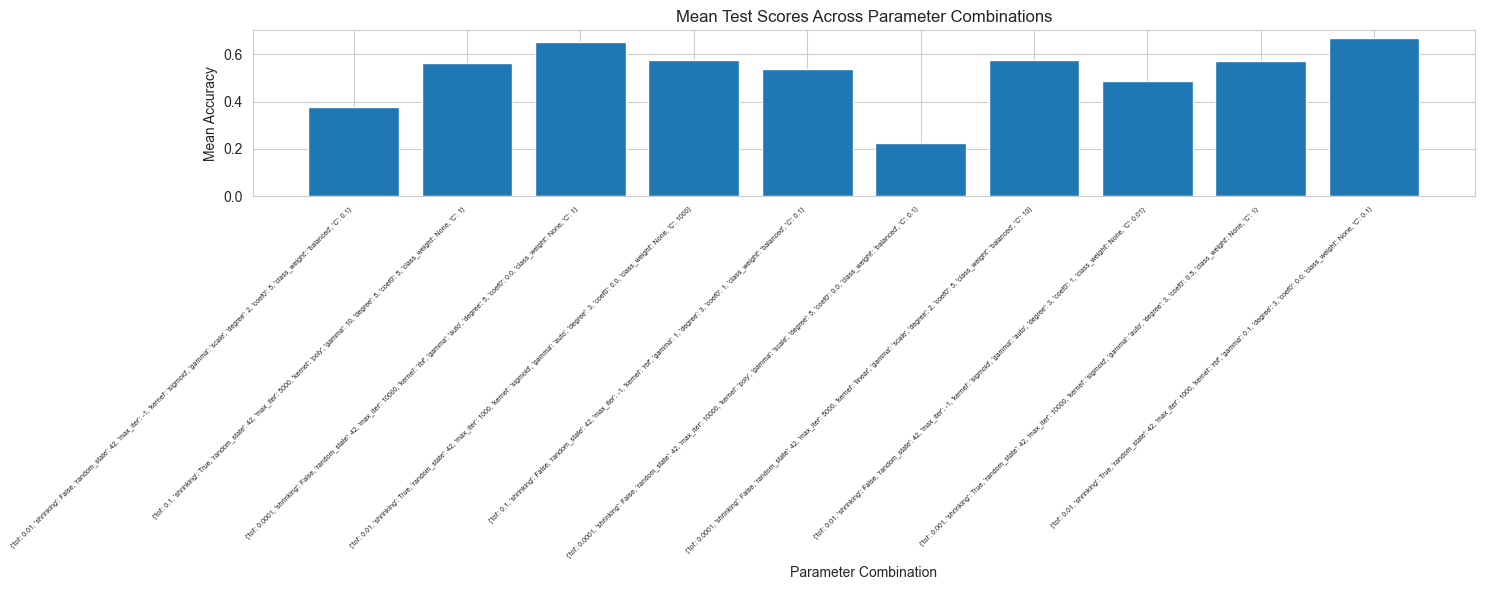

Sampling Method: over
Best parameters found: {'tol': 0.1, 'shrinking': False, 'random_state': 42, 'max_iter': -1, 'kernel': 'rbf', 'gamma': 1, 'degree': 3, 'coef0': 1, 'class_weight': 'balanced', 'C': 0.1}
Best score: 0.8675136988722645


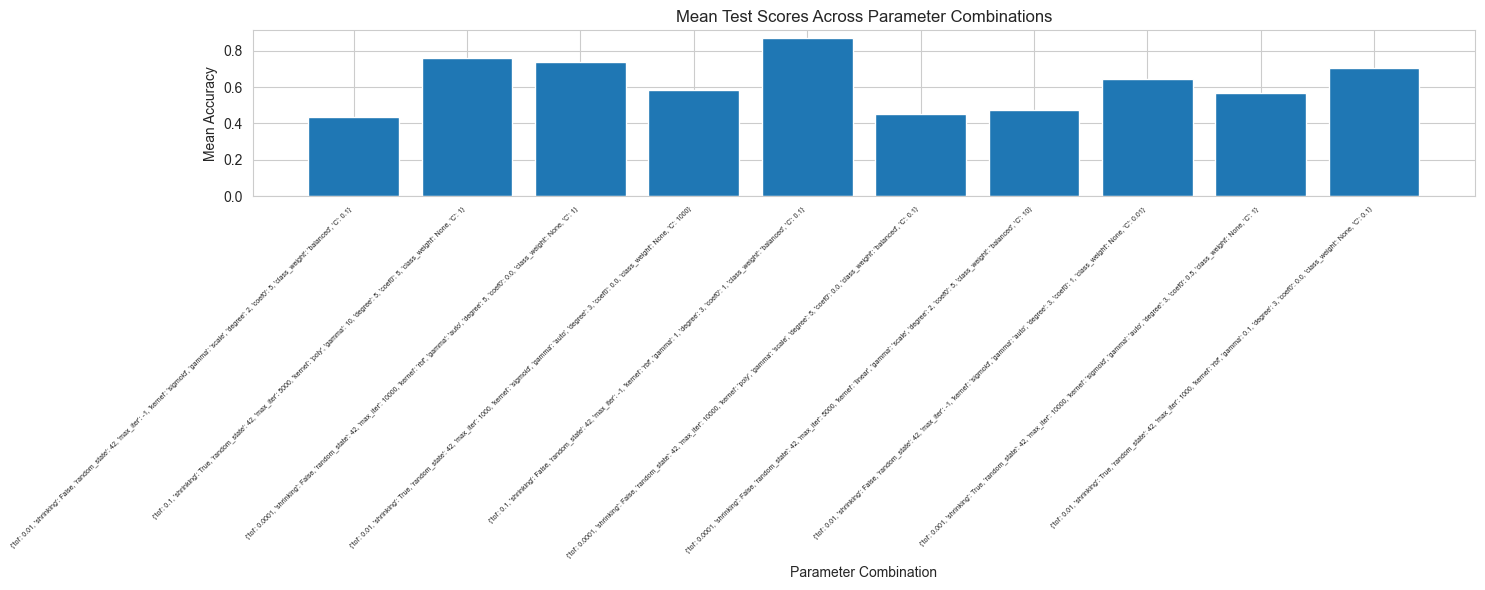

c:\Users\joell\anaconda3\envs\DTH\Lib\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Sampling Method: smote
Best parameters found: {'tol': 0.1, 'shrinking': True, 'random_state': 42, 'max_iter': 5000, 'kernel': 'poly', 'gamma': 10, 'degree': 5, 'coef0': 5, 'class_weight': None, 'C': 1}
Best score: 0.755074498458085


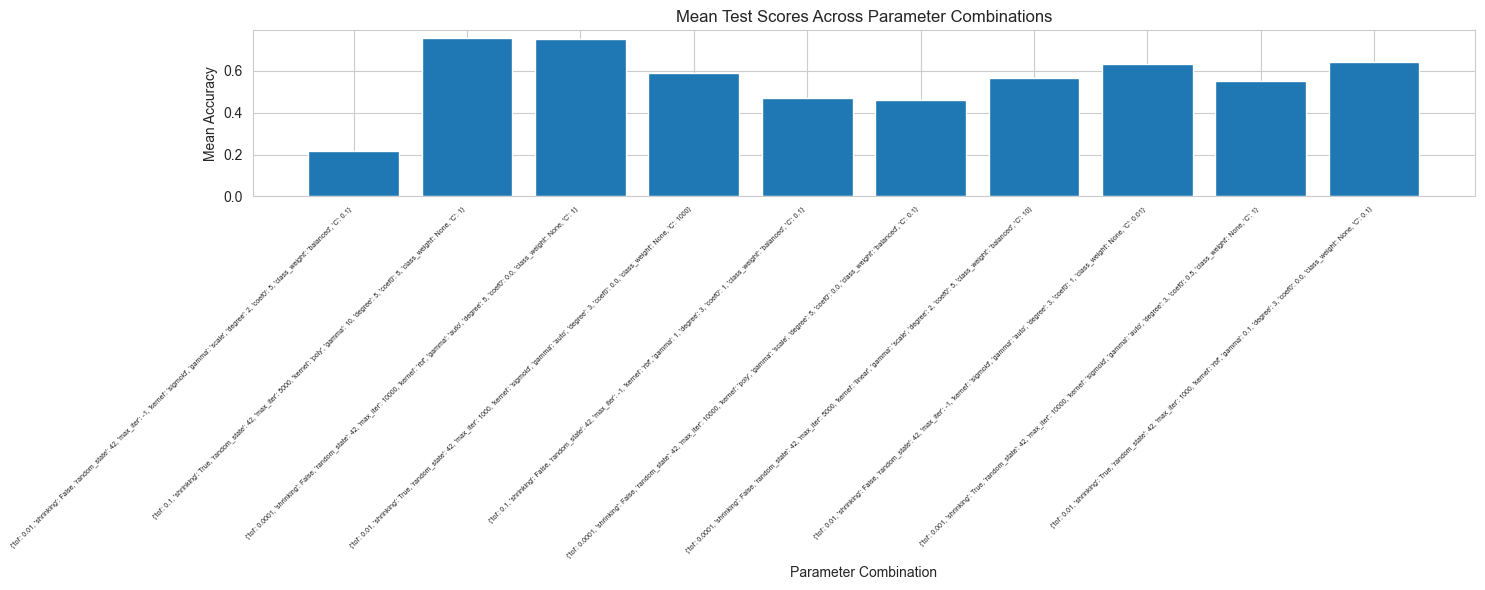

c:\Users\joell\anaconda3\envs\DTH\Lib\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Sampling Method: train
Best parameters found: {'tol': 0.0001, 'shrinking': False, 'random_state': 42, 'max_iter': 5000, 'kernel': 'linear', 'gamma': 'scale', 'degree': 2, 'coef0': 5, 'class_weight': 'balanced', 'C': 10}
Best score: 0.2568098932690271


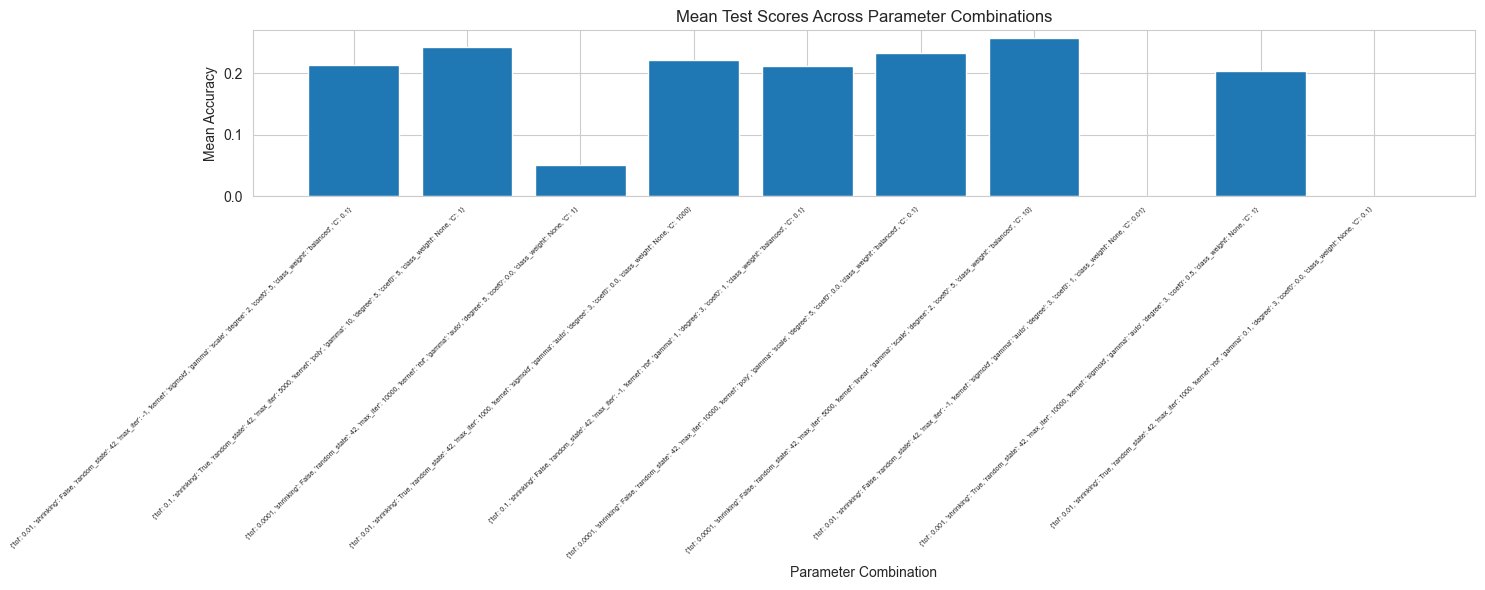

In [75]:
param_grid_svm = {
    "C": [0.001, 0.01, 0.1, 1, 10, 100, 1000],  # Regularization parameter
    "kernel": ["linear", "poly", "rbf", "sigmoid"],  # Specifies the kernel type
    "degree": [2, 3, 4, 5],  # Degree of the polynomial kernel function (used only with 'poly')
    "gamma": ["scale", "auto", 0.001, 0.01, 0.1, 1, 10],  # Kernel coefficient (for 'rbf', 'poly', and 'sigmoid')
    "coef0": [0.0, 0.1, 0.5, 1, 5, 10],  # Independent term in kernel function (for 'poly' and 'sigmoid')
    "class_weight": [None, "balanced"],  # Weights for each class to handle imbalance
    "shrinking": [True, False],  # Whether to use the shrinking heuristic
    "tol": [1e-4, 1e-3, 1e-2, 1e-1],  # Tolerance for stopping criterion
    "max_iter": [-1, 1000, 5000, 10000],  # Maximum number of iterations (use -1 for no limit)
    "random_state": [42]
}

model_optimizer(svc, X_train, y_train, X_test, y_test,"under", param_grid_svm)
model_optimizer(svc, X_train, y_train, X_test, y_test,"over", param_grid_svm)
model_optimizer(svc, X_train, y_train, X_test, y_test,"smote", param_grid_svm)
model_optimizer(svc, X_train, y_train, X_test, y_test,"train", param_grid_svm)

## Run optimized models

Test Set Performance:
Confusion Matrix (Test):
[[410 315]
 [ 32  91]]

Accuracy of Model (Test): 59.08018867924528 

              precision    recall  f1-score   support

           0       0.93      0.57      0.70       725
           1       0.22      0.74      0.34       123

    accuracy                           0.59       848
   macro avg       0.58      0.65      0.52       848
weighted avg       0.83      0.59      0.65       848

Test Set Performance:
Confusion Matrix (Test):
[[696  29]
 [118   5]]

Accuracy of Model (Test): 82.66509433962264 

              precision    recall  f1-score   support

           0       0.86      0.96      0.90       725
           1       0.15      0.04      0.06       123

    accuracy                           0.83       848
   macro avg       0.50      0.50      0.48       848
weighted avg       0.75      0.83      0.78       848



c:\Users\joell\anaconda3\envs\DTH\Lib\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Test Set Performance:
Confusion Matrix (Test):
[[444 281]
 [ 75  48]]

Accuracy of Model (Test): 58.01886792452831 

              precision    recall  f1-score   support

           0       0.86      0.61      0.71       725
           1       0.15      0.39      0.21       123

    accuracy                           0.58       848
   macro avg       0.50      0.50      0.46       848
weighted avg       0.75      0.58      0.64       848



c:\Users\joell\anaconda3\envs\DTH\Lib\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Test Set Performance:
Confusion Matrix (Test):
[[542 183]
 [ 85  38]]

Accuracy of Model (Test): 68.39622641509435 

              precision    recall  f1-score   support

           0       0.86      0.75      0.80       725
           1       0.17      0.31      0.22       123

    accuracy                           0.68       848
   macro avg       0.52      0.53      0.51       848
weighted avg       0.76      0.68      0.72       848



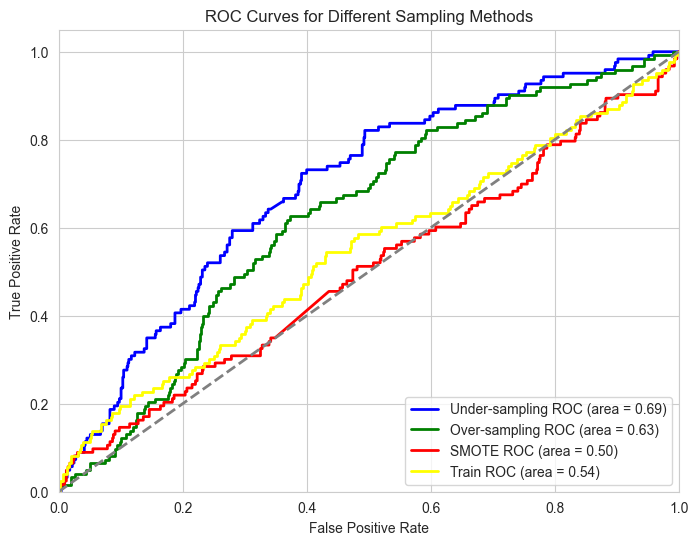

In [76]:
# create an instance of the model with the optimized hyperparameters
svc_under = SVC(C= 0.1, kernel= 'rbf', degree= 3, gamma= 0.1, coef0= 0.0, class_weight= None, shrinking= True, tol= 0.01, max_iter= 1000, probability= True, random_state= 42)
svc_over = SVC(C= 0.1, kernel= 'rbf', degree= 3, gamma= 1, coef0= 1, class_weight= "balanced", shrinking= False, tol= 0.1, max_iter= -1, probability= True, random_state= 42)
svc_smote = SVC(C= 1, kernel= 'poly', degree= 5, gamma= 10, coef0= 5, class_weight= None, shrinking= True, tol= 0.1, max_iter= 5000, probability= True, random_state= 42)
svc_train = SVC(C= 1, kernel= 'poly', degree= 5, gamma= 10, coef0= 5, class_weight= None, shrinking= True, tol= 0.1, max_iter= 5000, probability= True, random_state= 42)

y_proba_svc_under_opt = run_model(svc_under, X_train, y_train, X_test, y_test, "under", "optimized model")
y_proba_svc_over_opt = run_model(svc_over, X_train, y_train, X_test, y_test, "over", "optimized model")
y_proba_svc_smote_opt = run_model(svc_smote, X_train, y_train, X_test, y_test, "smote", "optimized model")
y_proba_svc_train_opt = run_model(svc_train, X_train, y_train, X_test, y_test, "train", "optimized model")

# plot roc curves for optimized models
plot_roc_curves(y_test, y_proba_svc_under_opt, y_proba_svc_over_opt, y_proba_svc_smote_opt, y_proba_svc_train_opt)

# MLP Classifier

## Base classifier without tuning

In [77]:
from sklearn.neural_network import MLPClassifier

mlp = MLPClassifier(random_state=42)
y_proba_mlp_under = run_model(mlp, X_train, y_train, X_test, y_test, "under", "base model")
y_proba_mlp_over = run_model(mlp, X_train, y_train, X_test, y_test, "over", "base model")
y_proba_mlp_smote = run_model(mlp, X_train, y_train, X_test, y_test, "smote", "base model")
y_proba_mlp_train = run_model(mlp, X_train, y_train, X_test, y_test, "train", "base model")

c:\Users\joell\anaconda3\envs\DTH\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Test Set Performance:
Confusion Matrix (Test):
[[501 224]
 [ 49  74]]

Accuracy of Model (Test): 67.80660377358491 

              precision    recall  f1-score   support

           0       0.91      0.69      0.79       725
           1       0.25      0.60      0.35       123

    accuracy                           0.68       848
   macro avg       0.58      0.65      0.57       848
weighted avg       0.81      0.68      0.72       848



c:\Users\joell\anaconda3\envs\DTH\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Test Set Performance:
Confusion Matrix (Test):
[[582 143]
 [ 81  42]]

Accuracy of Model (Test): 73.58490566037736 

              precision    recall  f1-score   support

           0       0.88      0.80      0.84       725
           1       0.23      0.34      0.27       123

    accuracy                           0.74       848
   macro avg       0.55      0.57      0.56       848
weighted avg       0.78      0.74      0.76       848



c:\Users\joell\anaconda3\envs\DTH\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Test Set Performance:
Confusion Matrix (Test):
[[599 126]
 [ 82  41]]

Accuracy of Model (Test): 75.47169811320755 

              precision    recall  f1-score   support

           0       0.88      0.83      0.85       725
           1       0.25      0.33      0.28       123

    accuracy                           0.75       848
   macro avg       0.56      0.58      0.57       848
weighted avg       0.79      0.75      0.77       848

Test Set Performance:
Confusion Matrix (Test):
[[704  21]
 [113  10]]

Accuracy of Model (Test): 84.19811320754717 

              precision    recall  f1-score   support

           0       0.86      0.97      0.91       725
           1       0.32      0.08      0.13       123

    accuracy                           0.84       848
   macro avg       0.59      0.53      0.52       848
weighted avg       0.78      0.84      0.80       848



c:\Users\joell\anaconda3\envs\DTH\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


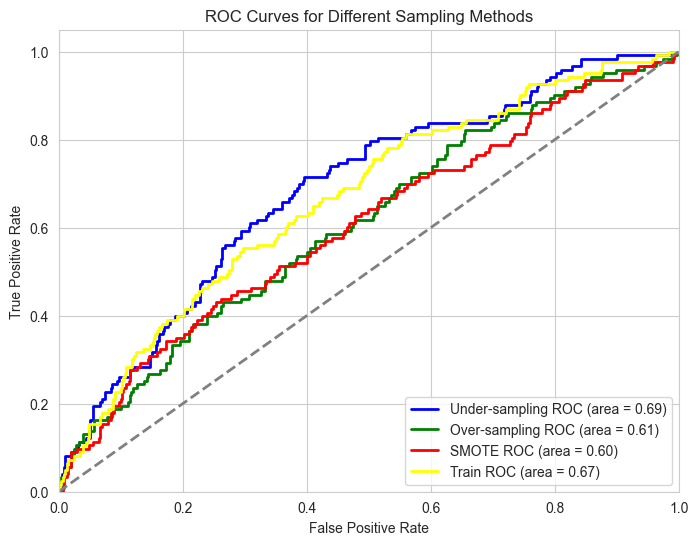

In [78]:
# plot roc curves of all base models
plot_roc_curves(y_test, y_proba_mlp_under, y_proba_mlp_over, y_proba_mlp_smote, y_proba_mlp_train)

## Optimization parameter for all 3 sampling techniques

Sampling Method: under
Best parameters found: {'tol': 0.01, 'solver': 'adam', 'random_state': 42, 'n_iter_no_change': 50, 'momentum': 0.9, 'max_iter': 200, 'learning_rate_init': 0.001, 'learning_rate': 'adaptive', 'hidden_layer_sizes': (50, 100, 50), 'epsilon': 1e-06, 'early_stopping': False, 'beta_2': 0.999, 'beta_1': 0.99, 'batch_size': 32, 'alpha': 1e-05, 'activation': 'logistic'}
Best score: 0.6663421039171874


C:\Users\joell\AppData\Local\Temp\ipykernel_41296\340764079.py:64: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


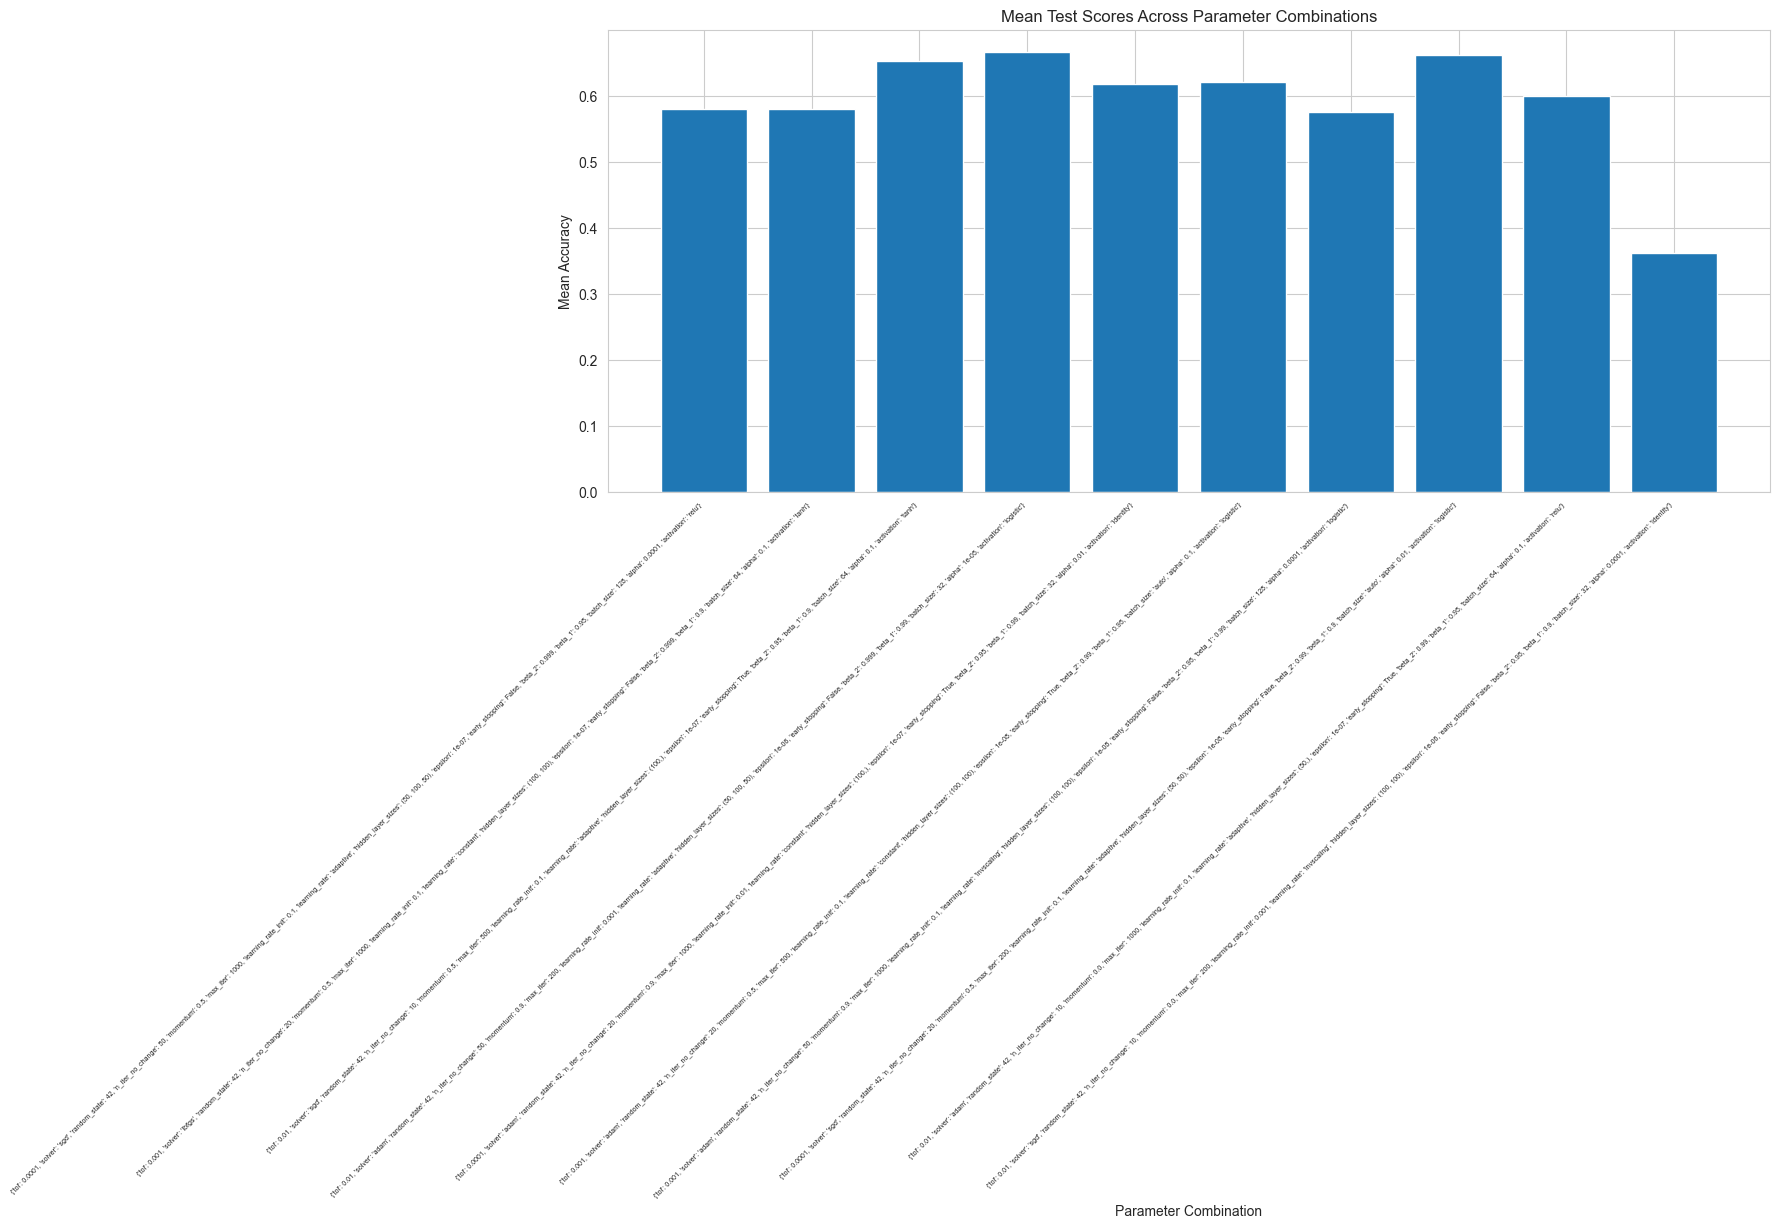

Sampling Method: over
Best parameters found: {'tol': 0.0001, 'solver': 'sgd', 'random_state': 42, 'n_iter_no_change': 50, 'momentum': 0.5, 'max_iter': 1000, 'learning_rate_init': 0.1, 'learning_rate': 'adaptive', 'hidden_layer_sizes': (50, 100, 50), 'epsilon': 1e-07, 'early_stopping': False, 'beta_2': 0.999, 'beta_1': 0.95, 'batch_size': 128, 'alpha': 0.0001, 'activation': 'relu'}
Best score: 0.9324041735747001


C:\Users\joell\AppData\Local\Temp\ipykernel_41296\340764079.py:64: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


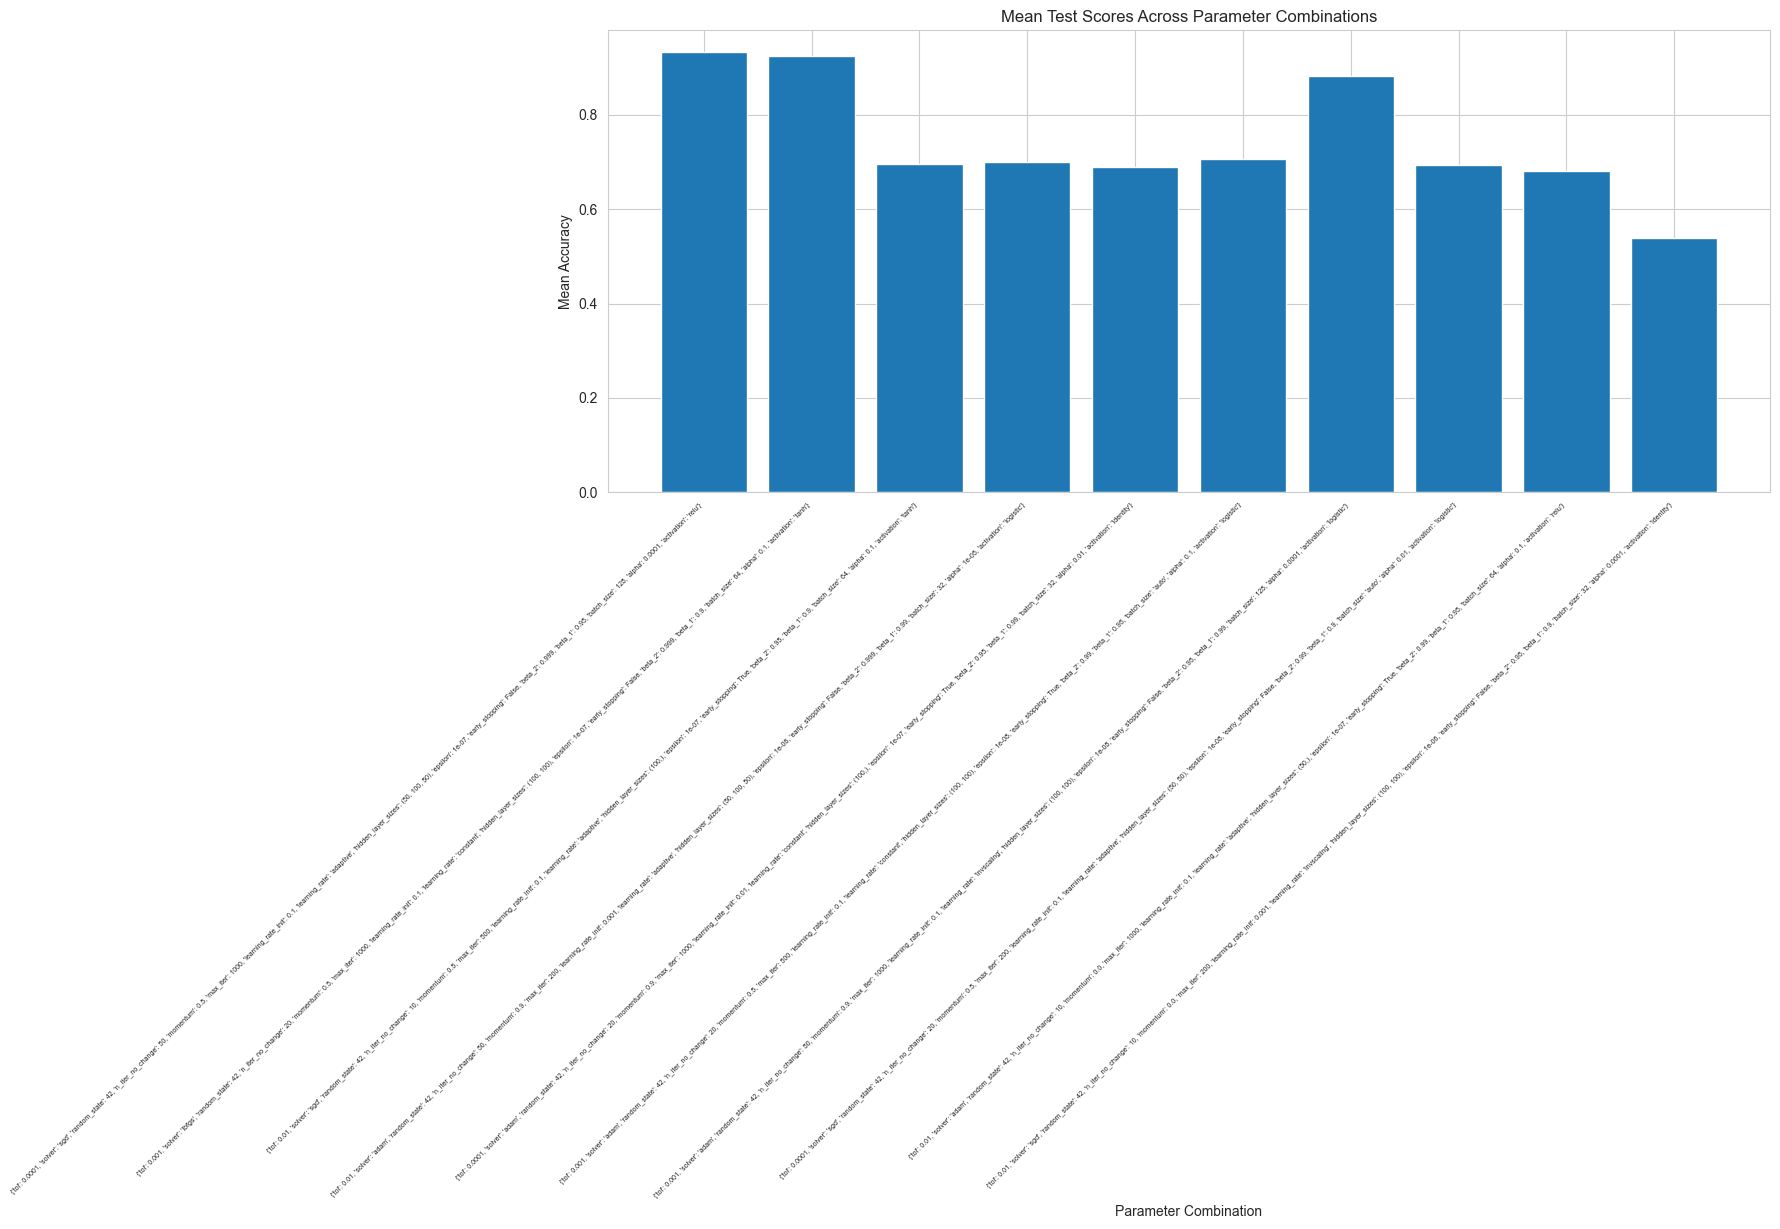

Sampling Method: smote
Best parameters found: {'tol': 0.0001, 'solver': 'sgd', 'random_state': 42, 'n_iter_no_change': 50, 'momentum': 0.5, 'max_iter': 1000, 'learning_rate_init': 0.1, 'learning_rate': 'adaptive', 'hidden_layer_sizes': (50, 100, 50), 'epsilon': 1e-07, 'early_stopping': False, 'beta_2': 0.999, 'beta_1': 0.95, 'batch_size': 128, 'alpha': 0.0001, 'activation': 'relu'}
Best score: 0.9031274096791849


C:\Users\joell\AppData\Local\Temp\ipykernel_41296\340764079.py:64: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


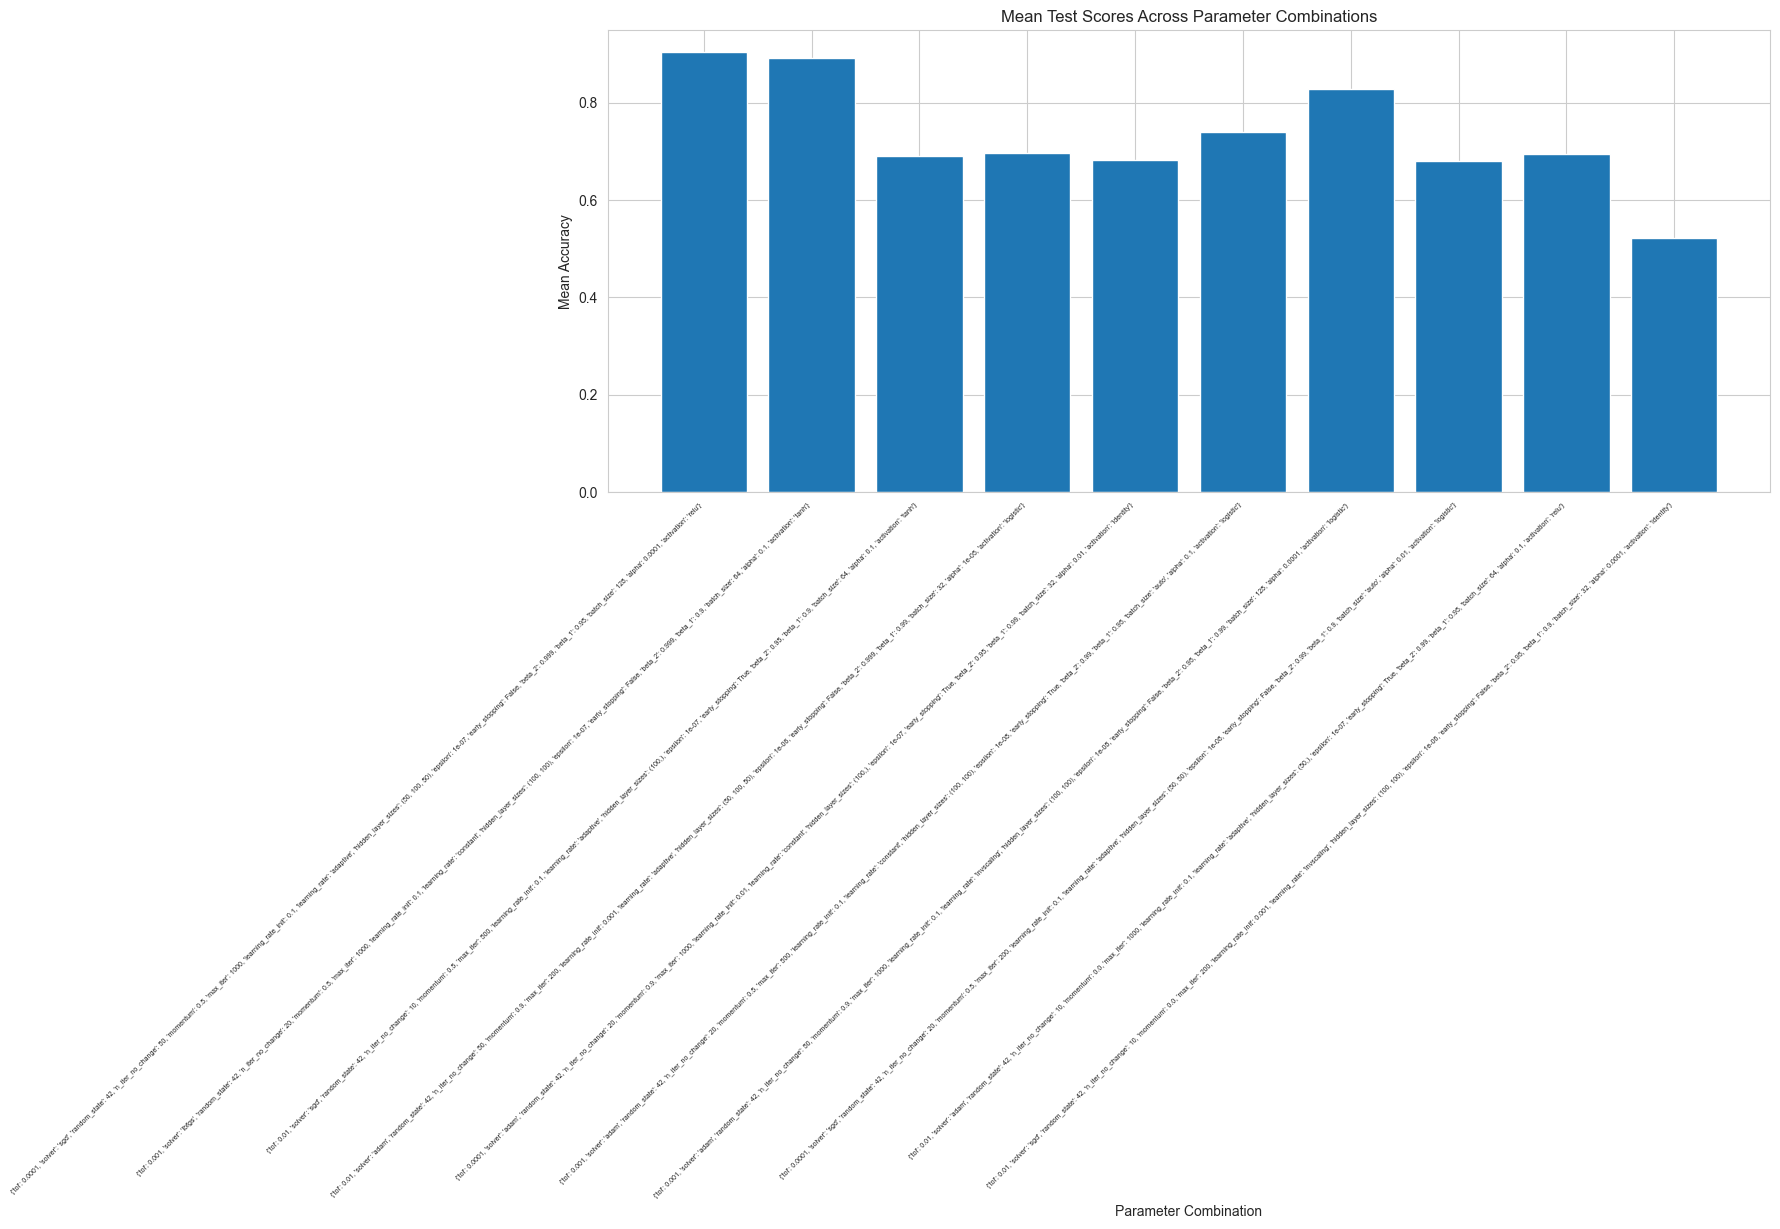

Sampling Method: train
Best parameters found: {'tol': 0.001, 'solver': 'lbfgs', 'random_state': 42, 'n_iter_no_change': 20, 'momentum': 0.5, 'max_iter': 1000, 'learning_rate_init': 0.1, 'learning_rate': 'constant', 'hidden_layer_sizes': (100, 100), 'epsilon': 1e-07, 'early_stopping': False, 'beta_2': 0.999, 'beta_1': 0.9, 'batch_size': 64, 'alpha': 0.1, 'activation': 'tanh'}
Best score: 0.24948009158389312


C:\Users\joell\AppData\Local\Temp\ipykernel_41296\340764079.py:64: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


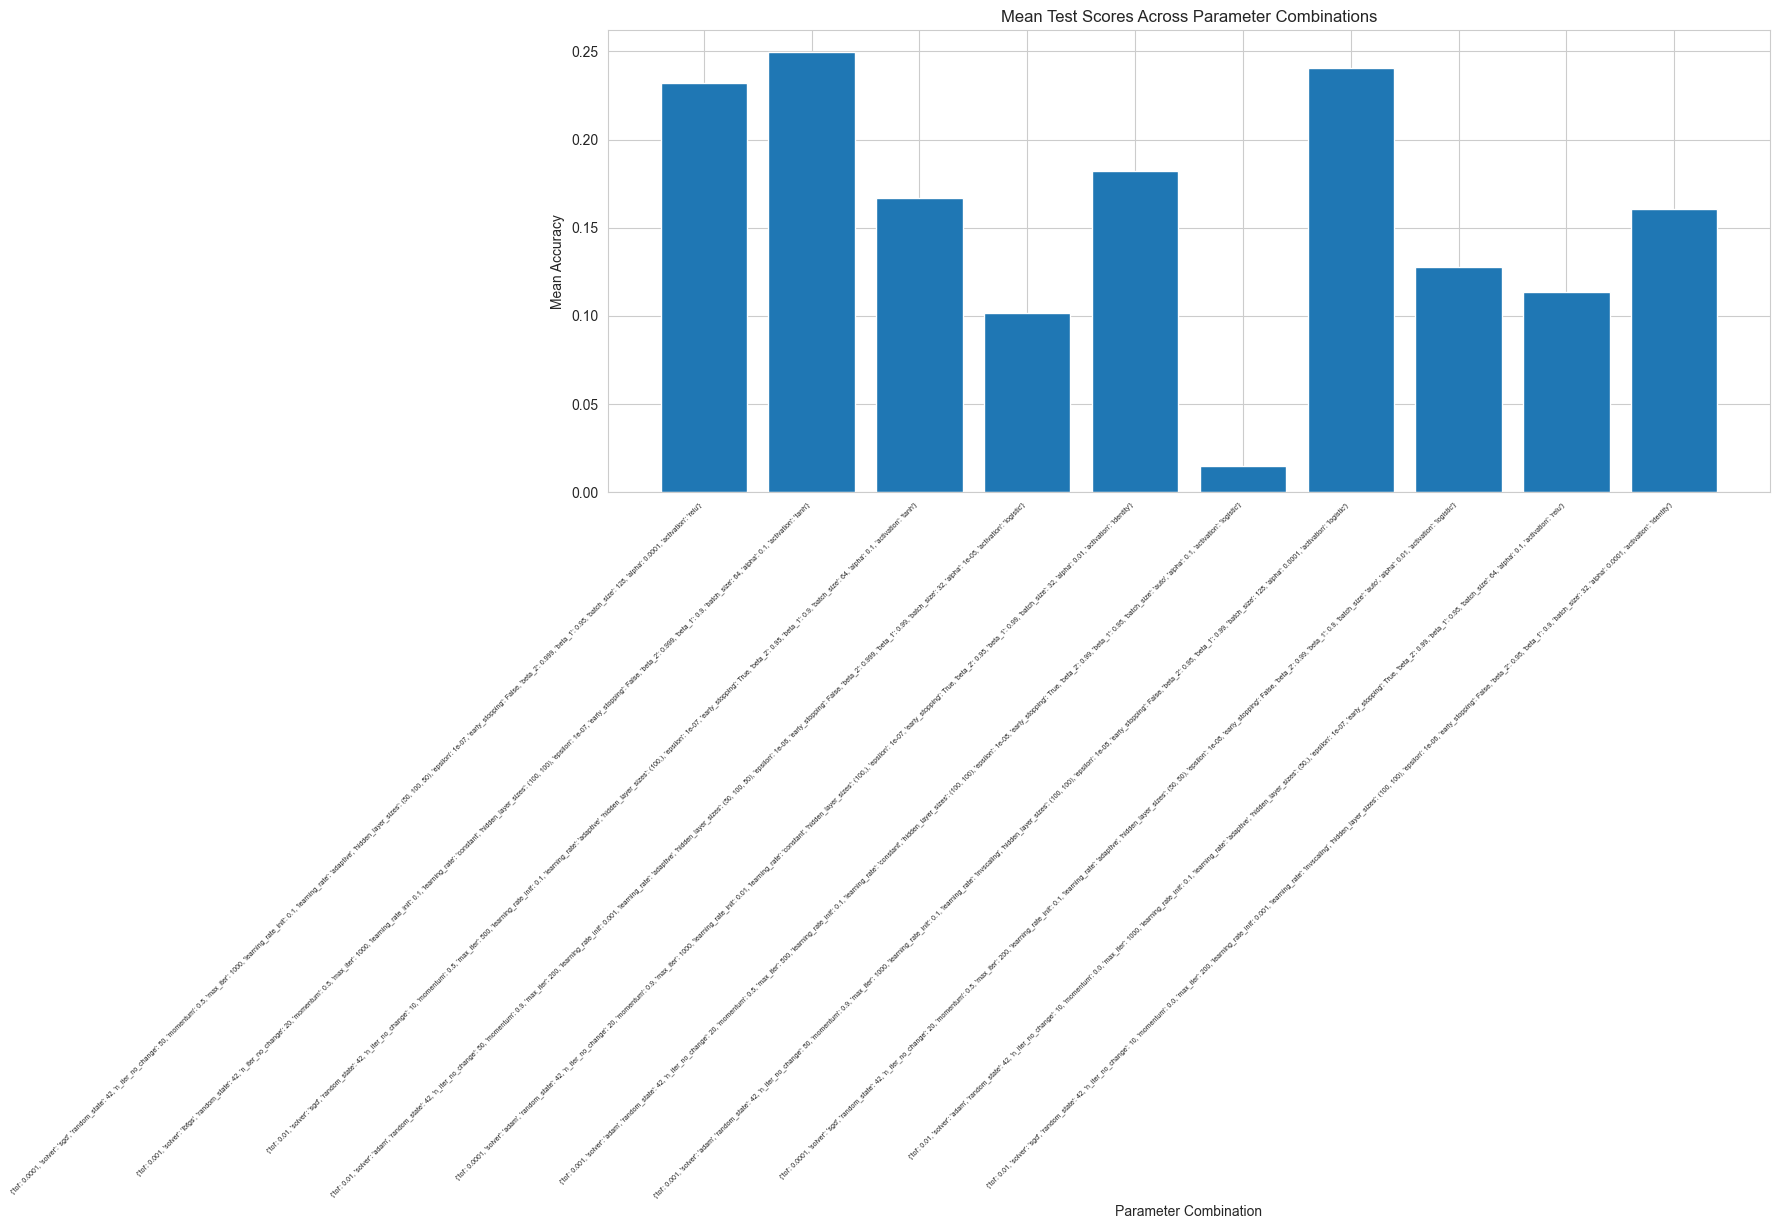

In [79]:
param_grid_mlp = {
    "hidden_layer_sizes": [(50,), (100,), (50, 50), (100, 100), (50, 100, 50)],  # Different layer configurations
    "activation": ["identity", "logistic", "tanh", "relu"],  # Activation functions
    "solver": ["lbfgs", "sgd", "adam"],  # Optimization algorithms
    "alpha": [1e-5, 1e-4, 1e-3, 1e-2, 0.1],  # Regularization term (L2 penalty)
    "learning_rate": ["constant", "invscaling", "adaptive"],  # Learning rate schedules
    "learning_rate_init": [0.001, 0.01, 0.1],  # Initial learning rate for weight updates
    "max_iter": [200, 300, 500, 1000],  # Maximum number of iterations
    "tol": [1e-4, 1e-3, 1e-2],  # Tolerance for the optimization stopping criterion
    "momentum": [0.0, 0.5, 0.9],  # Momentum factor (for 'sgd' solver)
    "n_iter_no_change": [10, 20, 50],  # Number of epochs with no improvement to stop training
    "early_stopping": [True, False],  # Whether to use early stopping
    "batch_size": ["auto", 32, 64, 128, 256],  # Size of minibatches for stochastic optimizers
    "beta_1": [0.9, 0.95, 0.99],  # Exponential decay rate for estimates of first-moment vector in Adam
    "beta_2": [0.999, 0.99, 0.95],  # Exponential decay rate for second-moment vector in Adam
    "epsilon": [1e-8, 1e-7, 1e-6],  # Value added for numerical stability in Adam optimizer
    "random_state": [42]
}

model_optimizer(mlp, X_train, y_train, X_test, y_test,"under", param_grid_mlp)
model_optimizer(mlp, X_train, y_train, X_test, y_test,"over", param_grid_mlp)
model_optimizer(mlp, X_train, y_train, X_test, y_test,"smote", param_grid_mlp)
model_optimizer(mlp, X_train, y_train, X_test, y_test,"train", param_grid_mlp)

## Run optimized models

Test Set Performance:
Confusion Matrix (Test):
[[476 249]
 [ 49  74]]

Accuracy of Model (Test): 64.85849056603774 

              precision    recall  f1-score   support

           0       0.91      0.66      0.76       725
           1       0.23      0.60      0.33       123

    accuracy                           0.65       848
   macro avg       0.57      0.63      0.55       848
weighted avg       0.81      0.65      0.70       848

Test Set Performance:
Confusion Matrix (Test):
[[653  72]
 [108  15]]

Accuracy of Model (Test): 78.77358490566037 

              precision    recall  f1-score   support

           0       0.86      0.90      0.88       725
           1       0.17      0.12      0.14       123

    accuracy                           0.79       848
   macro avg       0.52      0.51      0.51       848
weighted avg       0.76      0.79      0.77       848

Test Set Performance:
Confusion Matrix (Test):
[[641  84]
 [ 96  27]]

Accuracy of Model (Test): 78.773584905660

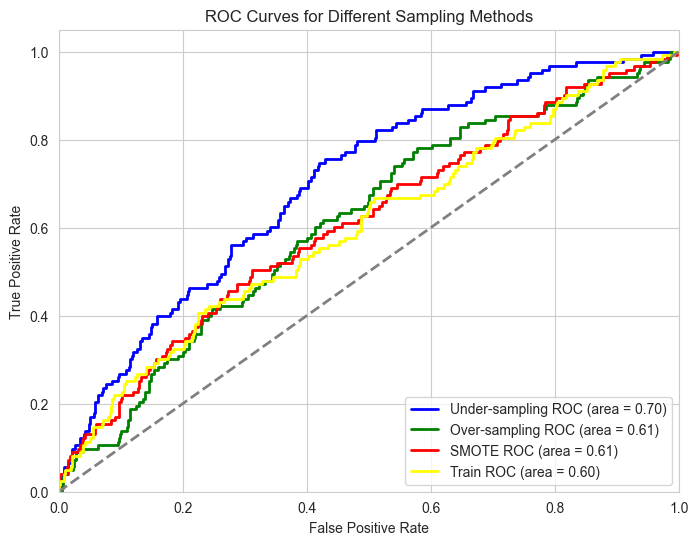

In [80]:
# create an instance of the model with the optimized hyperparameters
mlp_under = MLPClassifier(tol= 0.001, solver= 'adam', n_iter_no_change= 20, momentum= 0.5, max_iter= 500, learning_rate_init= 0.1, learning_rate= 'constant', hidden_layer_sizes= (100,100), epsilon= 1e-08, early_stopping= True, batch_size= 'auto', beta_2= 0.99, beta_1= 0.95, alpha= 0.01, activation= 'logistic', random_state= 42)
mlp_over = MLPClassifier(tol= 0.0001, solver= 'sgd', n_iter_no_change= 50, momentum= 0.5, max_iter= 1000, learning_rate_init= 0.1, learning_rate= 'adaptive', hidden_layer_sizes= (50, 100, 50), epsilon= 1e-07, early_stopping= False, beta_2= 0.999, beta_1= 0.95, batch_size= 128, alpha= 0.0001, activation= 'relu', random_state= 42)
mlp_smote = MLPClassifier(tol= 0.0001, solver= 'sgd', n_iter_no_change= 50, momentum= 0.5, max_iter= 1000, learning_rate_init= 0.1, learning_rate= 'adaptive', hidden_layer_sizes= (50, 100, 50), epsilon= 1e-07, early_stopping= False, beta_2= 0.999, beta_1= 0.95, batch_size= 128, alpha= 0.0001, activation= 'relu', random_state= 42)
mlp_train = MLPClassifier(tol= 0.001, solver= 'lbfgs', n_iter_no_change= 20, momentum= 0.5, max_iter= 1000, learning_rate_init= 0.1, learning_rate= 'constant', hidden_layer_sizes= (100, 100), epsilon= 1e-07, early_stopping= False, beta_2= 0.999, beta_1= 0.9, batch_size= 64, alpha= 0.1, activation= 'tanh', random_state= 42)

y_proba_mlp_under_opt = run_model(mlp_under, X_train, y_train, X_test, y_test, "under", "optimized model")
y_proba_mlp_over_opt = run_model(mlp_over, X_train, y_train, X_test, y_test, "over", "optimized model")
y_proba_mlp_smote_opt = run_model(mlp_smote, X_train, y_train, X_test, y_test, "smote", "optimized model")
y_proba_mlp_train_opt = run_model(mlp_smote, X_train, y_train, X_test, y_test, "train", "optimized model")


# plot roc curves for optimized models
plot_roc_curves(y_test, y_proba_mlp_under_opt, y_proba_mlp_over_opt, y_proba_mlp_smote_opt,y_proba_mlp_train_opt)

# Summary:

Non of the models either optimized or non- optimized have reached a very good f1 score for predicting df[df["TenYearCHD"]== 1].
The use/try of optimizing the models with a focus of predicting the positive target class has not brought a substential improvement.

It seems that the information present in the data, so that the model is struggeling to predict the positive target class.
The positive target class makes up the minority of test cases. Therefore the often "high" accuracy is not reflecting the situation correctely.

# Model selection

In [81]:
performance_df.head()

Model Sampling Method           Status  Accuracy  Precision  \
0  LogisticRegression           under       base model  0.663915   0.233553   
1  LogisticRegression            over       base model  0.659198   0.235669   
2  LogisticRegression           smote       base model  0.656840   0.239130   
3  LogisticRegression           train       base model  0.858491   0.588235   
4  LogisticRegression           under  optimized model  0.616745   0.225543   

     Recall  F1 Score   ROC AUC  
0  0.577236  0.332553  0.706801  
1  0.601626  0.338673  0.707766  
2  0.626016  0.346067  0.705041  
3  0.081301  0.142857  0.710199  
4  0.674797  0.338086  0.701990

In [82]:
performance_df.describe()

Accuracy  Precision     Recall   F1 Score    ROC AUC
count  64.000000  64.000000  64.000000  64.000000  64.000000
mean    0.726176   0.251571   0.351499   0.244166   0.644899
std     0.114409   0.096455   0.226467   0.087773   0.057666
min     0.148585   0.000000   0.000000   0.000000   0.501671
25%     0.659198   0.201435   0.154472   0.200000   0.604791
50%     0.739387   0.231539   0.304878   0.263982   0.658004
75%     0.817217   0.268424   0.571138   0.317856   0.701957
max     0.858491   0.588235   1.000000   0.354545   0.713160

<Axes: >

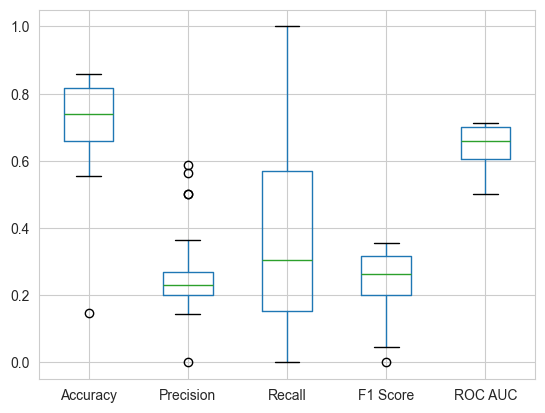

In [83]:
performance_df.boxplot()

In [84]:
performance_df.sort_values(by="F1 Score", ascending=False)
performance_df.head()

Model Sampling Method           Status  Accuracy  Precision  \
0  LogisticRegression           under       base model  0.663915   0.233553   
1  LogisticRegression            over       base model  0.659198   0.235669   
2  LogisticRegression           smote       base model  0.656840   0.239130   
3  LogisticRegression           train       base model  0.858491   0.588235   
4  LogisticRegression           under  optimized model  0.616745   0.225543   

     Recall  F1 Score   ROC AUC  
0  0.577236  0.332553  0.706801  
1  0.601626  0.338673  0.707766  
2  0.626016  0.346067  0.705041  
3  0.081301  0.142857  0.710199  
4  0.674797  0.338086  0.701990

In [85]:
# USe ixmax to find the best model for each sampling method
best_model = performance_df.loc[performance_df.groupby("Model")["F1 Score"].idxmax()]

# find the best overall model based on the F1 Score
best_overall_model = performance_df.loc[performance_df["F1 Score"].idxmax()]

# Display the best models
print("Best model per sampling method:")
print(best_model)

print("\nOverall best model based on F1 Score:")
print(best_overall_model)

Best model per sampling method:
                     Model Sampling Method           Status  Accuracy  \
23  DecisionTreeClassifier           train  optimized model  0.614387   
10              GaussianNB           smote       base model  0.814858   
36    KNeighborsClassifier           under  optimized model  0.685142   
5       LogisticRegression            over  optimized model  0.665094   
56           MLPClassifier           under       base model  0.678066   
28  RandomForestClassifier           under  optimized model  0.665094   
52                     SVC           under  optimized model  0.590802   
40           XGBClassifier           under       base model  0.623821   

    Precision    Recall  F1 Score   ROC AUC  
23   0.216667  0.634146  0.322981  0.635997  
10   0.333333  0.276423  0.302222  0.703095  
36   0.250000  0.585366  0.350365  0.680847  
5    0.246057  0.634146  0.354545  0.712016  
56   0.248322  0.601626  0.351544  0.686986  
28   0.232558  0.569106  0.330189 

In [86]:
### Maybe make a trade off and not necessarly only go for the best F1 score, but also consider other metrics like precision, recall, accuracy, and ROC AUC

# Add weights to the performance metrics, we want to prevent false negatives, so we give recall a higher weight
# Weights for each metric is stored in a dictionary
weights = {
    "Recall": 0.3,
    "F1 Score": 0.25,
    "ROC AUC": 0.2,
    "Precision": 0.15,
    "Accuracy": 0.1
}
# To make the model choice more clear, we store the weighted score in a new column to sort the models
performance_df["Weighted Score"] = (
    weights["Recall"] * performance_df["Recall"] +
    weights["F1 Score"] * performance_df["F1 Score"] +
    weights["ROC AUC"] * performance_df["ROC AUC"] +
    weights["Precision"] * performance_df["Precision"] +
    weights["Accuracy"] * performance_df["Accuracy"]
)
# Sort the DataFrame by Weighted Score to find the best model
performance_df = performance_df.sort_values(by="Weighted Score", ascending=False)

In [87]:
performance_df.head()

Model Sampling Method           Status  Accuracy  Precision  \
52                 SVC           under  optimized model  0.590802   0.224138   
44       XGBClassifier           under  optimized model  0.148585   0.145562   
5   LogisticRegression            over  optimized model  0.665094   0.246057   
4   LogisticRegression           under  optimized model  0.616745   0.225543   
2   LogisticRegression           smote       base model  0.656840   0.239130   

      Recall  F1 Score   ROC AUC  Weighted Score  
52  0.739837  0.344045  0.693412        0.539346  
44  1.000000  0.254132  0.671253        0.534476  
5   0.634146  0.354545  0.712016        0.524701  
4   0.674797  0.338086  0.701990        0.522865  
2   0.626016  0.346067  0.705041        0.516883

In [88]:
# safe perfromance df to csv

# performance_df.to_csv("performance_df.csv", index=False)

# Safe model for predictions in app

In [89]:
# safe model
import joblib

# Save the optimized model (svc_under)
joblib.dump(svc_under, 'svc_under_optimized_model.joblib')
print("Model saved successfully!")

Model saved successfully!


In [90]:
joblib.dump(svc_under, 'svc_under_optimized_model.joblib')
print("Model saved successfully!")

Model saved successfully!


# load file

In [91]:
import pandas as pd
performance_df = pd.read_csv("performance_df.csv")

# USe ixmax to find the best model for each sampling method
best_model = performance_df.loc[performance_df.groupby("Model")["F1 Score"].idxmax()]

# find the best overall model based on the F1 Score
best_overall_model = performance_df.loc[performance_df["F1 Score"].idxmax()]
best_model.head()

Model Sampling Method           Status  Accuracy  \
13  DecisionTreeClassifier            over  optimized model  0.689858   
23              GaussianNB           smote  optimized model  0.814858   
18    KNeighborsClassifier           under  optimized model  0.674528   
3       LogisticRegression            over  optimized model  0.658019   
8            MLPClassifier           under       base model  0.665094   

    Precision    Recall  F1 Score   ROC AUC  Weighted Score  
13   0.248201  0.560976  0.344140  0.633064        0.487157  
23   0.333333  0.276423  0.302222  0.703095        0.430587  
18   0.229682  0.528455  0.320197  0.663398        0.473171  
3    0.243077  0.642276  0.352679  0.713462        0.525808  
8    0.237785  0.593496  0.339535  0.673944        0.499899

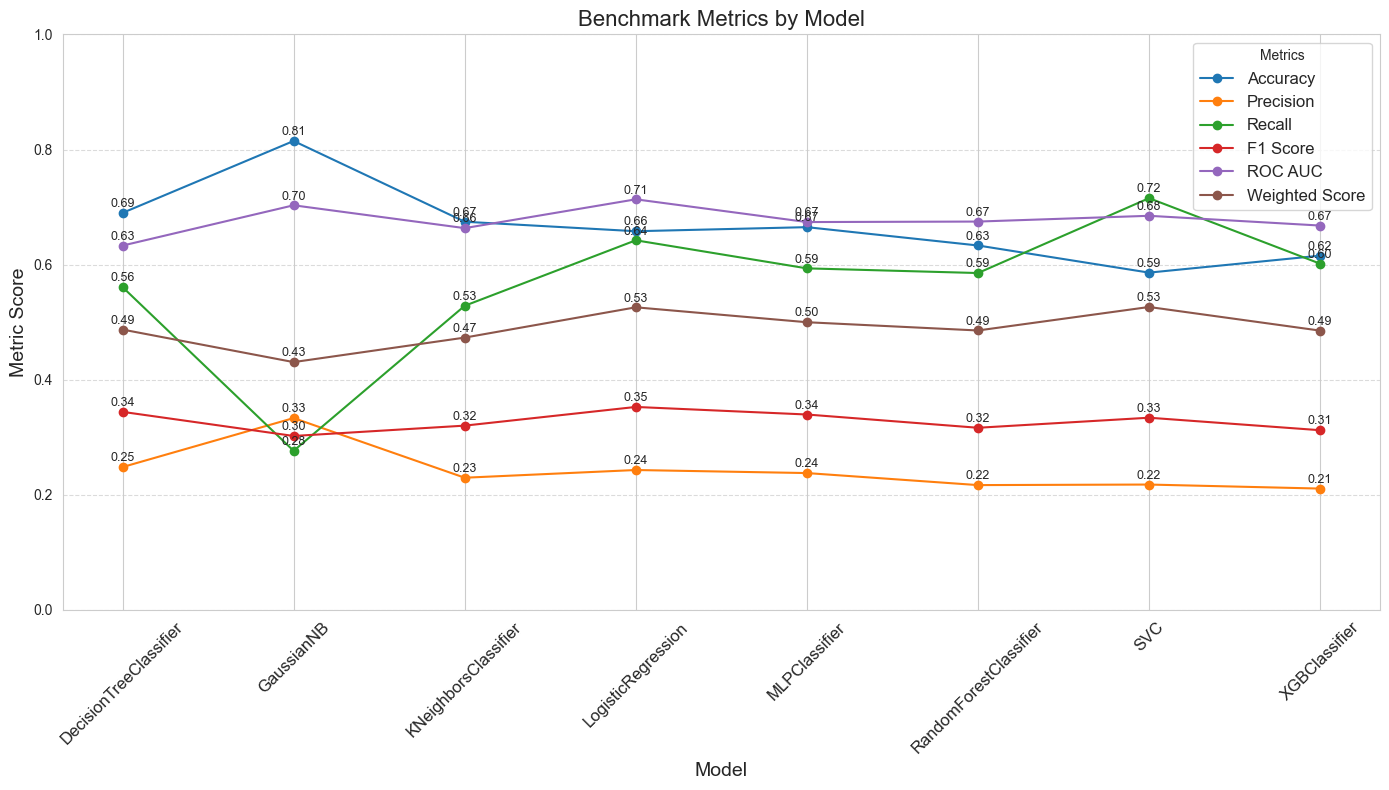

In [92]:
# ChatGPT code
import matplotlib.pyplot as plt
df = best_model

# Plot the benchmarks for each model
plt.figure(figsize=(14, 8))
metrics = ["Accuracy", "Precision", "Recall", "F1 Score", "ROC AUC", "Weighted Score"]
for metric in metrics:
    plt.plot(df["Model"], df[metric], marker='o', label=metric)
    for i, value in enumerate(df[metric]):
        plt.text(i, value + 0.01, f"{value:.2f}", fontsize=9, ha='center')

plt.title("Benchmark Metrics by Model", fontsize=16)
plt.xlabel("Model", fontsize=14)
plt.ylabel("Metric Score", fontsize=14)
plt.ylim([0,1])

plt.xticks(rotation=45, fontsize=12)
plt.legend(title="Metrics", fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()